In [1]:
# Basics
from glob import glob # finds pathnames
import os # Miscellaneous operating system interfaces
import sys
import random
import timeit
import imp
import gc

# Processing
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from scipy.ndimage import label as scipy_label
from scipy.ndimage import generate_binary_structure

# Image manipulation
import skimage

# Import Mask RCNN
sys.path.append('mrcnn')  # To find local version of the library
from config import Config
# Imp import to ensure loading the correct utils package
fp, pathname, description = imp.find_module('utils',['mrcnn'])
utils = imp.load_module('utils',fp,pathname,description)
import model as modellib
import visualize
from model import log

# Plotting
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
# Paths
ROOT_DIR = 'C:/Users/HPDQ/Mask_RCNN/DATASET/severstal'
Train_Dir = os.path.join(ROOT_DIR, 'train_images/')
Test_Dir = os.path.join(ROOT_DIR, 'test_images/')

# Directory to save logs and trained model
MODEL_DIR = 'logs'

# Local path to trained weights file
# Trained_Weights = '../input/????.h5'

In [3]:
print (Train_Dir)

C:/Users/HPDQ/Mask_RCNN/DATASET/severstal\train_images/


In [4]:
class SteelConfig(Config):
    """Configuration for training on the steel dataset.
    Derives from the base Config class and overrides values specific
    to the steel dataset.
    """
    # Give the configuration a recognizable name
    NAME = "steel"

    # Train on 1 GPU and 1 image per GPU.
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 4  # background + 4 defect classes

    # Use small images (128x128) for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 1024

    # Use smaller anchors because our objects tend to be small 
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images have few objects.
    # Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Minimum probability value to accept a detected instance
    # ROIs below this threshold are skipped
    DETECTION_MIN_CONFIDENCE = 0.7
    
    # Number of epochs
    EPOCHS = 20
    
    # Steps per epoch
    STEPS_PER_EPOCH = 100

    # validation steps per epoch
    VALIDATION_STEPS = 5
    
    # Non-maximum suppression threshold for detection, default 0.3
    DETECTION_NMS_THRESHOLD = 0.3
    
    # Non-max suppression threshold to filter RPN proposals. default 0.7
    # You can increase this during training to generate more propsals.
    RPN_NMS_THRESHOLD = 0.7
    
config = SteelConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
EPOCHS                         20
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                17
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE     

In [5]:
class SteelDataset(utils.Dataset):

    def load_steel(self, dataset_dir, files):
        """Load a subset of the Steel dataset.
        
        Input:
        dataset_dir: Root directory of the dataset.
        files: filenames of images to load
        
        Creates:
        image objects:
            source: source label
            image_id: id, used filename
            path: path + filename
            rle: rle mask encoded pixels, required for mask conversion
            classes: classes for the rle masks, required for mask conversion        
        """
        # Add classes.
        self.add_class("steel", 1, "defect1")
        self.add_class("steel", 2, "defect2")
        self.add_class("steel", 3, "defect3")
        self.add_class("steel", 4, "defect4")
        
        # Load annotations CSV
        annotations_train = pd.read_csv(r'C:\Users\HPDQ\Mask_RCNN\DATASET\severstal\train.csv')

        # Remove images without Encoding
        annotations_train_Encoded = annotations_train[annotations_train['EncodedPixels'].notna()].copy()        
        
        # Split ImageId_ClassId
        #ImageId_ClassId_split = annotations_train_Encoded["ImageId_ClassId"].str.split("_", n = 1, expand = True)
        #annotations_train_Encoded['ImageId'] = ImageId_ClassId_split.loc[:,0]
        #annotations_train_Encoded['ClassId'] = ImageId_ClassId_split.loc[:,1]     

        for file in files:
            EncodedPixels = [annotations_train_Encoded['EncodedPixels'][annotations_train_Encoded['ImageId'] == file]]
            ClassID = (annotations_train_Encoded['ClassId'][annotations_train_Encoded['ImageId'] == file])

            self.add_image(
                source = "steel",
                image_id = file,  # use filename as a unique image id
                path = Train_Dir + '/' + file,
                rle = EncodedPixels,
                classes = ClassID)

    def load_mask(self, image_id):
        """Generate instance masks for an image.
        Input:
        image_id: id of the image
        
        Returns:
        masks: A bool array of shape [height, width, instance count] with one mask per instance.
        class_ids: a 1D int array of class IDs of the instance masks.
        """
        # If not a steel dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "steel":
            return super(self.__class__, self).load_mask(image_id)
        
        # Convert rle to single mask
        ClassIDIndex = 0
        ClassID = np.empty(0, dtype = int)
        maskarray = np.empty((256, 1600, 0), dtype = int)
        for rlelist in image_info['rle']:
            for row in rlelist:
                mask= np.zeros(1600 * 256 ,dtype=np.uint8)
                array = np.asarray([int(x) for x in row.split()])
                starts = array[0::2]-1
                lengths = array[1::2]    
                for index, start in enumerate(starts):
                    mask[int(start):int(start+lengths[index])] = 1
                mask = mask.reshape((256,1600), order='F')
                # Label mask elements
                structure = generate_binary_structure(2,2)
                labeled_array, labels = scipy_label(mask, structure)
                # Convert labeled_array elements to bitmap mask array
                for label in range(labels):
                    labelmask = np.copy(labeled_array)    
                    labelmask[labelmask != label + 1] = 0
                    if label == 0:
                        labelmask = np.expand_dims(labelmask, axis = 2)
                        maskarray = np.concatenate((maskarray, labelmask), axis = 2)
                    else:
                        labelmask[labelmask == label + 1] = 1
                        labelmask = np.expand_dims(labelmask, axis = 2)
                        maskarray = np.concatenate((maskarray, labelmask), axis = 2)
                    # Update ClassID list
                    ClassID = np.append(ClassID,int(image_info['classes'].iloc[ClassIDIndex]))
                ClassIDIndex = ClassIDIndex + 1

        # Return mask, and array of class IDs of each instance.
        return maskarray.astype(np.bool), ClassID

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "steel":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

C:/Users/HPDQ/Mask_RCNN/DATASET/severstal
image_id  0 C:/Users/HPDQ/Mask_RCNN/DATASET/severstal\train_images//000a4bcdd.jpg
image                    shape: (256, 1600, 3)        min:   24.00000  max:  255.00000  uint8
mask                     shape: (256, 1600, 10)       min:    0.00000  max:    1.00000  bool
class_ids                shape: (10,)                 min:    1.00000  max:    1.00000  int32
bbox                     shape: (10, 4)               min:   55.00000  max:  462.00000  int32


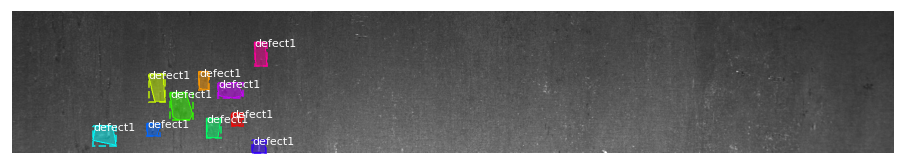

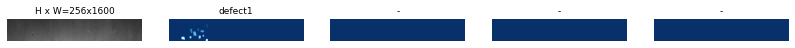

image_id  1 C:/Users/HPDQ/Mask_RCNN/DATASET/severstal\train_images//000f6bf48.jpg
image                    shape: (256, 1600, 3)        min:   16.00000  max:  255.00000  uint8
mask                     shape: (256, 1600, 2)        min:    0.00000  max:    1.00000  bool
class_ids                shape: (2,)                  min:    4.00000  max:    4.00000  int32
bbox                     shape: (2, 4)                min:    0.00000  max: 1132.00000  int32


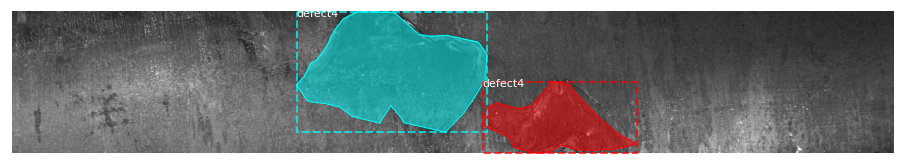

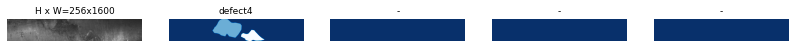

image_id  2 C:/Users/HPDQ/Mask_RCNN/DATASET/severstal\train_images//00ac8372f.jpg
image                    shape: (256, 1600, 3)        min:    1.00000  max:  253.00000  uint8
mask                     shape: (256, 1600, 3)        min:    0.00000  max:    1.00000  bool
class_ids                shape: (3,)                  min:    1.00000  max:    2.00000  int32
bbox                     shape: (3, 4)                min:    0.00000  max:  451.00000  int32


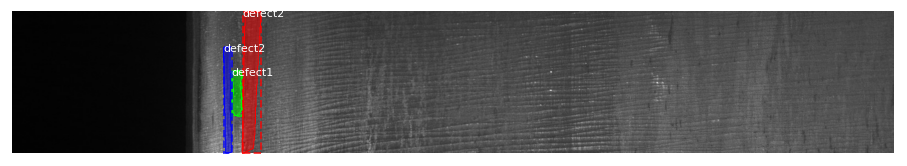

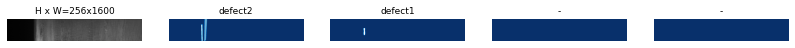

image_id  3 C:/Users/HPDQ/Mask_RCNN/DATASET/severstal\train_images//00af2671f.jpg
image                    shape: (256, 1600, 3)        min:   26.00000  max:  255.00000  uint8
mask                     shape: (256, 1600, 5)        min:    0.00000  max:    1.00000  bool
class_ids                shape: (5,)                  min:    3.00000  max:    3.00000  int32
bbox                     shape: (5, 4)                min:    0.00000  max: 1121.00000  int32


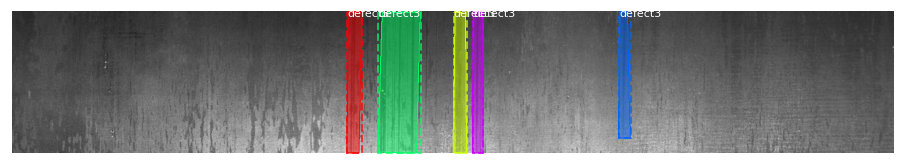

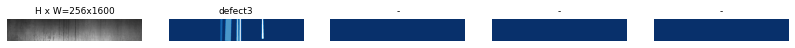

In [6]:
# Load example images and masks.
files = ['000a4bcdd.jpg', '000f6bf48.jpg', '00ac8372f.jpg', '00af2671f.jpg']
dataset = SteelDataset()
print(ROOT_DIR)
dataset.load_steel(ROOT_DIR, files)
dataset.prepare()

image_ids = [0,1,2,3] 
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    # Compute Bounding box
    bbox = utils.extract_bboxes(mask)
    # Display image and additional stats
    print("image_id ", image_id, dataset.image_reference(image_id))
    log("image", image)
    log("mask", mask)
    log("class_ids", class_ids)
    log("bbox", bbox)
    # Display image and instances
    visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

In [7]:
# select files for test and validation dataset
# Load annotations CSV
annotations_train = pd.read_csv(r'C:\Users\HPDQ\Mask_RCNN\DATASET\severstal\train.csv')

# Remove images without Encoding
annotations_train_Encoded = annotations_train[annotations_train['EncodedPixels'].notna()].copy()        

# Split ImageId_ClassId
#ImageId_ClassId_split = annotations_train_Encoded["ImageId_ClassId"].str.split("_", n = 1, expand = True)
#annotations_train_Encoded['ImageId'] = ImageId_ClassId_split.loc[:,0]
#annotations_train_Encoded['ClassId'] = ImageId_ClassId_split.loc[:,1]

# Split dataframe
msk = np.random.rand(len(annotations_train_Encoded)) < 0.85
train_msk = annotations_train_Encoded[msk]
val_msk = annotations_train_Encoded[~msk]
train = train_msk['ImageId'].unique().copy()
val = val_msk['ImageId'].unique().copy()
print('Train images: ' + str(len(train)))
print('Test images: ' + str(len(val)))
# Cleanup
del annotations_train, annotations_train_Encoded, msk, train_msk, val_msk 
gc.collect()

Train images: 5704
Test images: 1078


55913

In [8]:
# Training preperations
# Training dataset
dataset_train = SteelDataset()
dataset_train.load_steel(ROOT_DIR, train)
dataset_train.prepare()

# Validation dataset
dataset_val = SteelDataset()
dataset_val.load_steel(ROOT_DIR, val)
dataset_val.prepare()

# Build training model
model = modellib.MaskRCNN(mode="training", config=config, model_dir=MODEL_DIR)
# Required due to change in new Tensorflow / Keras version
model.keras_model.metrics_tensors = []
# Load weights to continue training
# model.load_weights(Trained_Weights, by_name=True)






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [ ]:
# Train model
timestart = timeit.default_timer()
print("Training")
model.train(dataset_train, 
            dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=config.EPOCHS,
            layers='all')
print ('Total run time: ' + str(runtime) + ' minutes')

Training

Starting at epoch 0. LR=0.001

Checkpoint Path: logs\steel20211010T0747\mask_rcnn_steel_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b          (B

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "












Epoch 1/20


c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/100 [..............................] - ETA: 1:46:00 - loss: 37.3761 - rpn_class_loss: 24.3117 - rpn_bbox_loss: 13.0143 - mrcnn_class_loss: 0.0500 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/100 [..............................] - ETA: 1:25:21 - loss: 29.3384 - rpn_class_loss: 20.3518 - rpn_bbox_loss: 8.9419 - mrcnn_class_loss: 0.0447 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/100 [..............................] - ETA: 1:16:47 - loss: 25.2111 - rpn_class_loss: 14.9378 - rpn_bbox_loss: 10.2353 - mrcnn_class_loss: 0.0379 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/100 [>.............................] - ETA: 1:11:40 - loss: 22.8827 - rpn_class_loss: 11.6029 - rpn_bbox_loss: 11.2478 - mrcnn_class_loss: 0.0320 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/100 [>.............................] - ETA: 1:08:20 - loss: 19.9493 - rpn_class_loss: 9.4896 - rpn_bbox_loss: 10.4325 - mrcnn_class_loss: 0.0272 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/100 [>.............................] - ETA: 1:06:08 - loss: 18.1616 - rpn_class_loss: 8.1240 - rpn_bbox_loss: 10.0142 - mrcnn_class_loss: 0.0234 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/100 [=>............................] - ETA: 1:04:11 - loss: 16.3733 - rpn_class_loss: 7.1566 - rpn_bbox_loss: 9.1963 - mrcnn_class_loss: 0.0203 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/100 [=>............................] - ETA: 1:02:42 - loss: 16.1715 - rpn_class_loss: 6.4312 - rpn_bbox_loss: 8.6284 - mrcnn_class_loss: 0.0892 - mrcnn_bbox_loss: 0.8621 - mrcnn_mask_loss: 0.1606        

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/100 [=>............................] - ETA: 1:01:38 - loss: 15.8602 - rpn_class_loss: 5.7669 - rpn_bbox_loss: 9.1049 - mrcnn_class_loss: 0.0794 - mrcnn_bbox_loss: 0.7663 - mrcnn_mask_loss: 0.1427

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/100 [==>...........................] - ETA: 1:00:37 - loss: 14.8222 - rpn_class_loss: 5.2467 - rpn_bbox_loss: 8.6859 - mrcnn_class_loss: 0.0715 - mrcnn_bbox_loss: 0.6896 - mrcnn_mask_loss: 0.1285

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/100 [==>...........................] - ETA: 1:00:21 - loss: 13.9213 - rpn_class_loss: 4.8145 - rpn_bbox_loss: 8.2980 - mrcnn_class_loss: 0.0650 - mrcnn_bbox_loss: 0.6270 - mrcnn_mask_loss: 0.1168

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/100 [==>...........................] - ETA: 59:50 - loss: 13.5250 - rpn_class_loss: 4.4386 - rpn_bbox_loss: 7.9952 - mrcnn_class_loss: 0.2233 - mrcnn_bbox_loss: 0.6936 - mrcnn_mask_loss: 0.1742  

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/100 [==>...........................] - ETA: 59:19 - loss: 12.9347 - rpn_class_loss: 4.1187 - rpn_bbox_loss: 7.8088 - mrcnn_class_loss: 0.2061 - mrcnn_bbox_loss: 0.6402 - mrcnn_mask_loss: 0.1608

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/100 [===>..........................] - ETA: 58:48 - loss: 12.2013 - rpn_class_loss: 3.8329 - rpn_bbox_loss: 7.4331 - mrcnn_class_loss: 0.1914 - mrcnn_bbox_loss: 0.5945 - mrcnn_mask_loss: 0.1493

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/100 [===>..........................] - ETA: 58:05 - loss: 11.7338 - rpn_class_loss: 3.5821 - rpn_bbox_loss: 7.2787 - mrcnn_class_loss: 0.1787 - mrcnn_bbox_loss: 0.5549 - mrcnn_mask_loss: 0.1394

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/100 [===>..........................] - ETA: 57:06 - loss: 11.3179 - rpn_class_loss: 3.3608 - rpn_bbox_loss: 7.1387 - mrcnn_class_loss: 0.1675 - mrcnn_bbox_loss: 0.5202 - mrcnn_mask_loss: 0.1307

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/100 [====>.........................] - ETA: 56:04 - loss: 10.8331 - rpn_class_loss: 3.1666 - rpn_bbox_loss: 6.8961 - mrcnn_class_loss: 0.1577 - mrcnn_bbox_loss: 0.4896 - mrcnn_mask_loss: 0.1230

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/100 [====>.........................] - ETA: 55:06 - loss: 10.6559 - rpn_class_loss: 2.9930 - rpn_bbox_loss: 6.9354 - mrcnn_class_loss: 0.1489 - mrcnn_bbox_loss: 0.4624 - mrcnn_mask_loss: 0.1162

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/100 [====>.........................] - ETA: 54:11 - loss: 10.2183 - rpn_class_loss: 2.8391 - rpn_bbox_loss: 6.6899 - mrcnn_class_loss: 0.1411 - mrcnn_bbox_loss: 0.4381 - mrcnn_mask_loss: 0.1100

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/100 [=====>........................] - ETA: 53:16 - loss: 9.8575 - rpn_class_loss: 2.6987 - rpn_bbox_loss: 6.5040 - mrcnn_class_loss: 0.1341 - mrcnn_bbox_loss: 0.4162 - mrcnn_mask_loss: 0.1045 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/100 [=====>........................] - ETA: 52:28 - loss: 9.5651 - rpn_class_loss: 2.5713 - rpn_bbox_loss: 6.3702 - mrcnn_class_loss: 0.1277 - mrcnn_bbox_loss: 0.3963 - mrcnn_mask_loss: 0.0996

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/100 [=====>........................] - ETA: 51:40 - loss: 9.2698 - rpn_class_loss: 2.4550 - rpn_bbox_loss: 6.2194 - mrcnn_class_loss: 0.1220 - mrcnn_bbox_loss: 0.3783 - mrcnn_mask_loss: 0.0950

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/100 [=====>........................] - ETA: 50:50 - loss: 9.9246 - rpn_class_loss: 2.3572 - rpn_bbox_loss: 6.9979 - mrcnn_class_loss: 0.1167 - mrcnn_bbox_loss: 0.3619 - mrcnn_mask_loss: 0.0909

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/100 [======>.......................] - ETA: 50:04 - loss: 9.6224 - rpn_class_loss: 2.2617 - rpn_bbox_loss: 6.8148 - mrcnn_class_loss: 0.1119 - mrcnn_bbox_loss: 0.3468 - mrcnn_mask_loss: 0.0871

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/100 [======>.......................] - ETA: 49:16 - loss: 9.3240 - rpn_class_loss: 2.1718 - rpn_bbox_loss: 6.6281 - mrcnn_class_loss: 0.1074 - mrcnn_bbox_loss: 0.3329 - mrcnn_mask_loss: 0.0836

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/100 [======>.......................] - ETA: 48:32 - loss: 9.0842 - rpn_class_loss: 2.0904 - rpn_bbox_loss: 6.4899 - mrcnn_class_loss: 0.1033 - mrcnn_bbox_loss: 0.3201 - mrcnn_mask_loss: 0.0804

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/100 [=======>......................] - ETA: 47:46 - loss: 8.8258 - rpn_class_loss: 2.0137 - rpn_bbox_loss: 6.3268 - mrcnn_class_loss: 0.0995 - mrcnn_bbox_loss: 0.3083 - mrcnn_mask_loss: 0.0774

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/100 [=======>......................] - ETA: 47:00 - loss: 8.6970 - rpn_class_loss: 1.9431 - rpn_bbox_loss: 6.2859 - mrcnn_class_loss: 0.0960 - mrcnn_bbox_loss: 0.2973 - mrcnn_mask_loss: 0.0747

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/100 [=======>......................] - ETA: 46:17 - loss: 8.4527 - rpn_class_loss: 1.8773 - rpn_bbox_loss: 6.1235 - mrcnn_class_loss: 0.0928 - mrcnn_bbox_loss: 0.2870 - mrcnn_mask_loss: 0.0721

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/100 [========>.....................] - ETA: 45:36 - loss: 8.2398 - rpn_class_loss: 1.8158 - rpn_bbox_loss: 5.9872 - mrcnn_class_loss: 0.0898 - mrcnn_bbox_loss: 0.2774 - mrcnn_mask_loss: 0.0697

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/100 [========>.....................] - ETA: 44:56 - loss: 8.1521 - rpn_class_loss: 1.7585 - rpn_bbox_loss: 5.9708 - mrcnn_class_loss: 0.0869 - mrcnn_bbox_loss: 0.2685 - mrcnn_mask_loss: 0.0674

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/100 [========>.....................] - ETA: 44:14 - loss: 7.9879 - rpn_class_loss: 1.7054 - rpn_bbox_loss: 5.8728 - mrcnn_class_loss: 0.0843 - mrcnn_bbox_loss: 0.2601 - mrcnn_mask_loss: 0.0653

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/100 [========>.....................] - ETA: 43:33 - loss: 7.7980 - rpn_class_loss: 1.6548 - rpn_bbox_loss: 5.7459 - mrcnn_class_loss: 0.0818 - mrcnn_bbox_loss: 0.2522 - mrcnn_mask_loss: 0.0634

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/100 [=========>....................] - ETA: 42:57 - loss: 7.6298 - rpn_class_loss: 1.6070 - rpn_bbox_loss: 5.6371 - mrcnn_class_loss: 0.0794 - mrcnn_bbox_loss: 0.2448 - mrcnn_mask_loss: 0.0615

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/100 [=========>....................] - ETA: 42:15 - loss: 7.5277 - rpn_class_loss: 1.5625 - rpn_bbox_loss: 5.4856 - mrcnn_class_loss: 0.0891 - mrcnn_bbox_loss: 0.3073 - mrcnn_mask_loss: 0.0832

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/100 [=========>....................] - ETA: 41:33 - loss: 7.3513 - rpn_class_loss: 1.5208 - rpn_bbox_loss: 5.3641 - mrcnn_class_loss: 0.0867 - mrcnn_bbox_loss: 0.2988 - mrcnn_mask_loss: 0.0809

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/100 [==========>...................] - ETA: 40:51 - loss: 7.2382 - rpn_class_loss: 1.4809 - rpn_bbox_loss: 5.3035 - mrcnn_class_loss: 0.0844 - mrcnn_bbox_loss: 0.2907 - mrcnn_mask_loss: 0.0787

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/100 [==========>...................] - ETA: 40:10 - loss: 7.1011 - rpn_class_loss: 1.4440 - rpn_bbox_loss: 5.2152 - mrcnn_class_loss: 0.0823 - mrcnn_bbox_loss: 0.2830 - mrcnn_mask_loss: 0.0766

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/100 [==========>...................] - ETA: 39:28 - loss: 6.9710 - rpn_class_loss: 1.4085 - rpn_bbox_loss: 5.1318 - mrcnn_class_loss: 0.0802 - mrcnn_bbox_loss: 0.2758 - mrcnn_mask_loss: 0.0746

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/100 [===========>..................] - ETA: 38:46 - loss: 6.9598 - rpn_class_loss: 1.3815 - rpn_bbox_loss: 5.1583 - mrcnn_class_loss: 0.0783 - mrcnn_bbox_loss: 0.2689 - mrcnn_mask_loss: 0.0728

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/100 [===========>..................] - ETA: 38:06 - loss: 6.8309 - rpn_class_loss: 1.3482 - rpn_bbox_loss: 5.0729 - mrcnn_class_loss: 0.0765 - mrcnn_bbox_loss: 0.2623 - mrcnn_mask_loss: 0.0710

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/100 [===========>..................] - ETA: 37:25 - loss: 6.7364 - rpn_class_loss: 1.3171 - rpn_bbox_loss: 5.0192 - mrcnn_class_loss: 0.0748 - mrcnn_bbox_loss: 0.2561 - mrcnn_mask_loss: 0.0693

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/100 [===========>..................] - ETA: 36:44 - loss: 6.7114 - rpn_class_loss: 1.2873 - rpn_bbox_loss: 5.0331 - mrcnn_class_loss: 0.0731 - mrcnn_bbox_loss: 0.2501 - mrcnn_mask_loss: 0.0677

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/100 [============>.................] - ETA: 36:04 - loss: 6.7268 - rpn_class_loss: 1.2585 - rpn_bbox_loss: 5.0861 - mrcnn_class_loss: 0.0716 - mrcnn_bbox_loss: 0.2445 - mrcnn_mask_loss: 0.0662

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/100 [============>.................] - ETA: 35:23 - loss: 6.7510 - rpn_class_loss: 1.2374 - rpn_bbox_loss: 5.0933 - mrcnn_class_loss: 0.0742 - mrcnn_bbox_loss: 0.2652 - mrcnn_mask_loss: 0.0807

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/100 [============>.................] - ETA: 34:42 - loss: 6.6571 - rpn_class_loss: 1.2114 - rpn_bbox_loss: 5.0345 - mrcnn_class_loss: 0.0727 - mrcnn_bbox_loss: 0.2595 - mrcnn_mask_loss: 0.0790

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/100 [=============>................] - ETA: 34:03 - loss: 6.5584 - rpn_class_loss: 1.1861 - rpn_bbox_loss: 4.9698 - mrcnn_class_loss: 0.0713 - mrcnn_bbox_loss: 0.2540 - mrcnn_mask_loss: 0.0773

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/100 [=============>................] - ETA: 33:22 - loss: 6.4592 - rpn_class_loss: 1.1619 - rpn_bbox_loss: 4.9030 - mrcnn_class_loss: 0.0699 - mrcnn_bbox_loss: 0.2487 - mrcnn_mask_loss: 0.0757

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/100 [=============>................] - ETA: 32:42 - loss: 6.3716 - rpn_class_loss: 1.1399 - rpn_bbox_loss: 4.8454 - mrcnn_class_loss: 0.0685 - mrcnn_bbox_loss: 0.2436 - mrcnn_mask_loss: 0.0741

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/100 [==============>...............] - ETA: 32:02 - loss: 6.2775 - rpn_class_loss: 1.1180 - rpn_bbox_loss: 4.7810 - mrcnn_class_loss: 0.0672 - mrcnn_bbox_loss: 0.2387 - mrcnn_mask_loss: 0.0727

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/100 [==============>...............] - ETA: 31:22 - loss: 6.2698 - rpn_class_loss: 1.0970 - rpn_bbox_loss: 4.7257 - mrcnn_class_loss: 0.0798 - mrcnn_bbox_loss: 0.2811 - mrcnn_mask_loss: 0.0861

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/100 [==============>...............] - ETA: 30:43 - loss: 6.1806 - rpn_class_loss: 1.0783 - rpn_bbox_loss: 4.6637 - mrcnn_class_loss: 0.0783 - mrcnn_bbox_loss: 0.2757 - mrcnn_mask_loss: 0.0845

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/100 [==============>...............] - ETA: 30:03 - loss: 6.1729 - rpn_class_loss: 1.0586 - rpn_bbox_loss: 4.6839 - mrcnn_class_loss: 0.0769 - mrcnn_bbox_loss: 0.2705 - mrcnn_mask_loss: 0.0829

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/100 [===============>..............] - ETA: 29:25 - loss: 6.1216 - rpn_class_loss: 1.0401 - rpn_bbox_loss: 4.6209 - mrcnn_class_loss: 0.0786 - mrcnn_bbox_loss: 0.2880 - mrcnn_mask_loss: 0.0941

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/100 [===============>..............] - ETA: 28:45 - loss: 6.0372 - rpn_class_loss: 1.0216 - rpn_bbox_loss: 4.5633 - mrcnn_class_loss: 0.0772 - mrcnn_bbox_loss: 0.2827 - mrcnn_mask_loss: 0.0924

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/100 [===============>..............] - ETA: 28:06 - loss: 5.9901 - rpn_class_loss: 1.0094 - rpn_bbox_loss: 4.5363 - mrcnn_class_loss: 0.0759 - mrcnn_bbox_loss: 0.2777 - mrcnn_mask_loss: 0.0907

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/100 [================>.............] - ETA: 27:27 - loss: 5.9380 - rpn_class_loss: 0.9933 - rpn_bbox_loss: 4.5082 - mrcnn_class_loss: 0.0746 - mrcnn_bbox_loss: 0.2728 - mrcnn_mask_loss: 0.0891

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/100 [================>.............] - ETA: 26:48 - loss: 5.8732 - rpn_class_loss: 0.9770 - rpn_bbox_loss: 4.4671 - mrcnn_class_loss: 0.0733 - mrcnn_bbox_loss: 0.2681 - mrcnn_mask_loss: 0.0876

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/100 [================>.............] - ETA: 26:09 - loss: 5.7899 - rpn_class_loss: 0.9610 - rpn_bbox_loss: 4.4071 - mrcnn_class_loss: 0.0721 - mrcnn_bbox_loss: 0.2636 - mrcnn_mask_loss: 0.0861

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/100 [=================>............] - ETA: 25:30 - loss: 5.7461 - rpn_class_loss: 0.9455 - rpn_bbox_loss: 4.3858 - mrcnn_class_loss: 0.0710 - mrcnn_bbox_loss: 0.2592 - mrcnn_mask_loss: 0.0847

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/100 [=================>............] - ETA: 24:52 - loss: 5.7235 - rpn_class_loss: 0.9306 - rpn_bbox_loss: 4.3849 - mrcnn_class_loss: 0.0698 - mrcnn_bbox_loss: 0.2549 - mrcnn_mask_loss: 0.0833

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/100 [=================>............] - ETA: 24:13 - loss: 5.6434 - rpn_class_loss: 0.9163 - rpn_bbox_loss: 4.3255 - mrcnn_class_loss: 0.0688 - mrcnn_bbox_loss: 0.2508 - mrcnn_mask_loss: 0.0819

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/100 [=================>............] - ETA: 23:34 - loss: 5.5887 - rpn_class_loss: 0.9022 - rpn_bbox_loss: 4.2913 - mrcnn_class_loss: 0.0677 - mrcnn_bbox_loss: 0.2468 - mrcnn_mask_loss: 0.0806

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/100 [==================>...........] - ETA: 22:55 - loss: 5.5273 - rpn_class_loss: 0.8896 - rpn_bbox_loss: 4.2487 - mrcnn_class_loss: 0.0667 - mrcnn_bbox_loss: 0.2430 - mrcnn_mask_loss: 0.0794

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/100 [==================>...........] - ETA: 22:16 - loss: 5.4634 - rpn_class_loss: 0.8765 - rpn_bbox_loss: 4.2037 - mrcnn_class_loss: 0.0657 - mrcnn_bbox_loss: 0.2392 - mrcnn_mask_loss: 0.0782

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/100 [==================>...........] - ETA: 21:37 - loss: 5.4289 - rpn_class_loss: 0.8635 - rpn_bbox_loss: 4.1587 - mrcnn_class_loss: 0.0665 - mrcnn_bbox_loss: 0.2522 - mrcnn_mask_loss: 0.0878

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/100 [===================>..........] - ETA: 20:59 - loss: 5.4144 - rpn_class_loss: 0.8512 - rpn_bbox_loss: 4.1194 - mrcnn_class_loss: 0.0672 - mrcnn_bbox_loss: 0.2798 - mrcnn_mask_loss: 0.0968

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/100 [===================>..........] - ETA: 20:21 - loss: 5.3974 - rpn_class_loss: 0.8407 - rpn_bbox_loss: 4.0887 - mrcnn_class_loss: 0.0760 - mrcnn_bbox_loss: 0.2864 - mrcnn_mask_loss: 0.1056

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/100 [===================>..........] - ETA: 19:42 - loss: 5.3741 - rpn_class_loss: 0.8291 - rpn_bbox_loss: 4.0495 - mrcnn_class_loss: 0.0779 - mrcnn_bbox_loss: 0.3036 - mrcnn_mask_loss: 0.1140

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/100 [====================>.........] - ETA: 19:04 - loss: 5.3684 - rpn_class_loss: 0.8187 - rpn_bbox_loss: 4.0375 - mrcnn_class_loss: 0.0787 - mrcnn_bbox_loss: 0.3110 - mrcnn_mask_loss: 0.1225

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/100 [====================>.........] - ETA: 18:25 - loss: 5.3166 - rpn_class_loss: 0.8075 - rpn_bbox_loss: 4.0041 - mrcnn_class_loss: 0.0776 - mrcnn_bbox_loss: 0.3067 - mrcnn_mask_loss: 0.1207

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/100 [====================>.........] - ETA: 17:47 - loss: 5.2956 - rpn_class_loss: 0.7967 - rpn_bbox_loss: 4.0008 - mrcnn_class_loss: 0.0766 - mrcnn_bbox_loss: 0.3024 - mrcnn_mask_loss: 0.1191

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/100 [====================>.........] - ETA: 17:08 - loss: 5.2480 - rpn_class_loss: 0.7863 - rpn_bbox_loss: 3.9705 - mrcnn_class_loss: 0.0755 - mrcnn_bbox_loss: 0.2983 - mrcnn_mask_loss: 0.1174

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/100 [=====================>........] - ETA: 16:30 - loss: 5.2183 - rpn_class_loss: 0.7760 - rpn_bbox_loss: 3.9576 - mrcnn_class_loss: 0.0745 - mrcnn_bbox_loss: 0.2942 - mrcnn_mask_loss: 0.1158

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/100 [=====================>........] - ETA: 15:52 - loss: 5.1705 - rpn_class_loss: 0.7660 - rpn_bbox_loss: 3.9263 - mrcnn_class_loss: 0.0735 - mrcnn_bbox_loss: 0.2903 - mrcnn_mask_loss: 0.1143

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/100 [=====================>........] - ETA: 15:13 - loss: 5.1353 - rpn_class_loss: 0.7564 - rpn_bbox_loss: 3.9070 - mrcnn_class_loss: 0.0726 - mrcnn_bbox_loss: 0.2865 - mrcnn_mask_loss: 0.1128

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/100 [======================>.......] - ETA: 14:35 - loss: 5.1168 - rpn_class_loss: 0.7472 - rpn_bbox_loss: 3.8703 - mrcnn_class_loss: 0.0749 - mrcnn_bbox_loss: 0.3034 - mrcnn_mask_loss: 0.1210

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/100 [======================>.......] - ETA: 13:57 - loss: 5.0630 - rpn_class_loss: 0.7381 - rpn_bbox_loss: 3.8319 - mrcnn_class_loss: 0.0740 - mrcnn_bbox_loss: 0.2995 - mrcnn_mask_loss: 0.1194

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/100 [======================>.......] - ETA: 13:19 - loss: 5.0261 - rpn_class_loss: 0.7294 - rpn_bbox_loss: 3.8100 - mrcnn_class_loss: 0.0730 - mrcnn_bbox_loss: 0.2957 - mrcnn_mask_loss: 0.1179

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/100 [=======================>......] - ETA: 12:41 - loss: 4.9765 - rpn_class_loss: 0.7206 - rpn_bbox_loss: 3.7752 - mrcnn_class_loss: 0.0721 - mrcnn_bbox_loss: 0.2920 - mrcnn_mask_loss: 0.1165

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/100 [=======================>......] - ETA: 12:02 - loss: 4.9502 - rpn_class_loss: 0.7120 - rpn_bbox_loss: 3.7634 - mrcnn_class_loss: 0.0712 - mrcnn_bbox_loss: 0.2884 - mrcnn_mask_loss: 0.1150

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/100 [=======================>......] - ETA: 11:24 - loss: 4.9307 - rpn_class_loss: 0.7042 - rpn_bbox_loss: 3.7576 - mrcnn_class_loss: 0.0704 - mrcnn_bbox_loss: 0.2849 - mrcnn_mask_loss: 0.1136

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/100 [=======================>......] - ETA: 10:46 - loss: 4.8890 - rpn_class_loss: 0.6962 - rpn_bbox_loss: 3.7295 - mrcnn_class_loss: 0.0695 - mrcnn_bbox_loss: 0.2815 - mrcnn_mask_loss: 0.1122

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/100 [========================>.....] - ETA: 10:08 - loss: 4.8374 - rpn_class_loss: 0.6885 - rpn_bbox_loss: 3.6911 - mrcnn_class_loss: 0.0687 - mrcnn_bbox_loss: 0.2781 - mrcnn_mask_loss: 0.1109

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/100 [========================>.....] - ETA: 9:30 - loss: 4.8169 - rpn_class_loss: 0.6815 - rpn_bbox_loss: 3.6830 - mrcnn_class_loss: 0.0679 - mrcnn_bbox_loss: 0.2749 - mrcnn_mask_loss: 0.1096 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/100 [========================>.....] - ETA: 8:52 - loss: 4.7940 - rpn_class_loss: 0.6742 - rpn_bbox_loss: 3.6727 - mrcnn_class_loss: 0.0671 - mrcnn_bbox_loss: 0.2717 - mrcnn_mask_loss: 0.1083

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/100 [=========================>....] - ETA: 8:14 - loss: 4.7574 - rpn_class_loss: 0.6665 - rpn_bbox_loss: 3.6489 - mrcnn_class_loss: 0.0663 - mrcnn_bbox_loss: 0.2685 - mrcnn_mask_loss: 0.1071

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/100 [=========================>....] - ETA: 7:35 - loss: 4.7139 - rpn_class_loss: 0.6591 - rpn_bbox_loss: 3.6179 - mrcnn_class_loss: 0.0656 - mrcnn_bbox_loss: 0.2655 - mrcnn_mask_loss: 0.1059

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/100 [=========================>....] - ETA: 6:57 - loss: 4.6751 - rpn_class_loss: 0.6520 - rpn_bbox_loss: 3.5911 - mrcnn_class_loss: 0.0648 - mrcnn_bbox_loss: 0.2625 - mrcnn_mask_loss: 0.1047

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/100 [==========================>...] - ETA: 6:20 - loss: 4.6770 - rpn_class_loss: 0.6451 - rpn_bbox_loss: 3.5764 - mrcnn_class_loss: 0.0646 - mrcnn_bbox_loss: 0.2794 - mrcnn_mask_loss: 0.1115

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/100 [==========================>...] - ETA: 5:42 - loss: 4.6816 - rpn_class_loss: 0.6406 - rpn_bbox_loss: 3.5693 - mrcnn_class_loss: 0.0640 - mrcnn_bbox_loss: 0.2888 - mrcnn_mask_loss: 0.1188

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/100 [==========================>...] - ETA: 5:04 - loss: 4.6638 - rpn_class_loss: 0.6344 - rpn_bbox_loss: 3.5629 - mrcnn_class_loss: 0.0633 - mrcnn_bbox_loss: 0.2857 - mrcnn_mask_loss: 0.1175

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/100 [==========================>...] - ETA: 4:26 - loss: 4.6397 - rpn_class_loss: 0.6279 - rpn_bbox_loss: 3.5502 - mrcnn_class_loss: 0.0626 - mrcnn_bbox_loss: 0.2826 - mrcnn_mask_loss: 0.1163

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/100 [===========================>..] - ETA: 3:48 - loss: 4.6437 - rpn_class_loss: 0.6216 - rpn_bbox_loss: 3.5284 - mrcnn_class_loss: 0.0642 - mrcnn_bbox_loss: 0.3070 - mrcnn_mask_loss: 0.1225

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/100 [===========================>..] - ETA: 3:10 - loss: 4.6213 - rpn_class_loss: 0.6160 - rpn_bbox_loss: 3.5168 - mrcnn_class_loss: 0.0635 - mrcnn_bbox_loss: 0.3037 - mrcnn_mask_loss: 0.1213

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/100 [===========================>..] - ETA: 2:32 - loss: 4.5780 - rpn_class_loss: 0.6099 - rpn_bbox_loss: 3.4846 - mrcnn_class_loss: 0.0628 - mrcnn_bbox_loss: 0.3006 - mrcnn_mask_loss: 0.1200

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/100 [============================>.] - ETA: 1:54 - loss: 4.5456 - rpn_class_loss: 0.6041 - rpn_bbox_loss: 3.4630 - mrcnn_class_loss: 0.0622 - mrcnn_bbox_loss: 0.2975 - mrcnn_mask_loss: 0.1188

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/100 [============================>.] - ETA: 1:16 - loss: 4.5413 - rpn_class_loss: 0.5982 - rpn_bbox_loss: 3.4695 - mrcnn_class_loss: 0.0616 - mrcnn_bbox_loss: 0.2944 - mrcnn_mask_loss: 0.1175

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/100 [============================>.] - ETA: 38s - loss: 4.5427 - rpn_class_loss: 0.5939 - rpn_bbox_loss: 3.4596 - mrcnn_class_loss: 0.0612 - mrcnn_bbox_loss: 0.3041 - mrcnn_mask_loss: 0.1239 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or 

100/100 [==============================] - 3858s 39s/step - loss: 4.5157 - rpn_class_loss: 0.5889 - rpn_bbox_loss: 3.4425 - mrcnn_class_loss: 0.0606 - mrcnn_bbox_loss: 0.3010 - mrcnn_mask_loss: 0.1226 - val_loss: 1.8620 - val_rpn_class_loss: 0.0500 - val_rpn_bbox_loss: 1.4474 - val_mrcnn_class_loss: 0.0360 - val_mrcnn_bbox_loss: 0.1880 - val_mrcnn_mask_loss: 0.1405

Epoch 2/20


c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/100 [..............................] - ETA: 1:06:29 - loss: 1.8104 - rpn_class_loss: 0.0328 - rpn_bbox_loss: 1.7765 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/100 [..............................] - ETA: 1:04:12 - loss: 2.6460 - rpn_class_loss: 0.0827 - rpn_bbox_loss: 2.5622 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/100 [..............................] - ETA: 1:03:30 - loss: 2.3637 - rpn_class_loss: 0.0843 - rpn_bbox_loss: 2.2783 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/100 [>.............................] - ETA: 1:02:28 - loss: 2.0644 - rpn_class_loss: 0.0772 - rpn_bbox_loss: 1.9862 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/100 [>.............................] - ETA: 1:02:00 - loss: 1.9601 - rpn_class_loss: 0.0752 - rpn_bbox_loss: 1.8839 - mrcnn_class_loss: 9.4323e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/100 [>.............................] - ETA: 1:01:04 - loss: 2.4246 - rpn_class_loss: 0.0710 - rpn_bbox_loss: 1.8703 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.3569 - mrcnn_mask_loss: 0.1166            

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/100 [=>............................] - ETA: 1:00:19 - loss: 2.1794 - rpn_class_loss: 0.0665 - rpn_bbox_loss: 1.6985 - mrcnn_class_loss: 0.0085 - mrcnn_bbox_loss: 0.3059 - mrcnn_mask_loss: 0.1000

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/100 [=>............................] - ETA: 59:34 - loss: 2.3985 - rpn_class_loss: 0.0655 - rpn_bbox_loss: 1.6347 - mrcnn_class_loss: 0.0206 - mrcnn_bbox_loss: 0.4882 - mrcnn_mask_loss: 0.1894  

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/100 [=>............................] - ETA: 58:53 - loss: 2.2971 - rpn_class_loss: 0.0637 - rpn_bbox_loss: 1.6125 - mrcnn_class_loss: 0.0184 - mrcnn_bbox_loss: 0.4340 - mrcnn_mask_loss: 0.1684

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/100 [==>...........................] - ETA: 58:13 - loss: 2.2220 - rpn_class_loss: 0.0606 - rpn_bbox_loss: 1.6026 - mrcnn_class_loss: 0.0166 - mrcnn_bbox_loss: 0.3906 - mrcnn_mask_loss: 0.1516

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/100 [==>...........................] - ETA: 57:28 - loss: 2.2808 - rpn_class_loss: 0.0593 - rpn_bbox_loss: 1.5410 - mrcnn_class_loss: 0.0383 - mrcnn_bbox_loss: 0.4410 - mrcnn_mask_loss: 0.2011

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/100 [==>...........................] - ETA: 56:44 - loss: 2.2108 - rpn_class_loss: 0.0574 - rpn_bbox_loss: 1.5295 - mrcnn_class_loss: 0.0352 - mrcnn_bbox_loss: 0.4043 - mrcnn_mask_loss: 0.1844

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/100 [==>...........................] - ETA: 55:58 - loss: 2.2010 - rpn_class_loss: 0.0551 - rpn_bbox_loss: 1.5700 - mrcnn_class_loss: 0.0325 - mrcnn_bbox_loss: 0.3732 - mrcnn_mask_loss: 0.1702

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/100 [===>..........................] - ETA: 55:13 - loss: 2.2214 - rpn_class_loss: 0.0548 - rpn_bbox_loss: 1.6319 - mrcnn_class_loss: 0.0302 - mrcnn_bbox_loss: 0.3465 - mrcnn_mask_loss: 0.1580

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/100 [===>..........................] - ETA: 54:29 - loss: 2.4564 - rpn_class_loss: 0.0532 - rpn_bbox_loss: 1.9041 - mrcnn_class_loss: 0.0282 - mrcnn_bbox_loss: 0.3234 - mrcnn_mask_loss: 0.1475

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/100 [===>..........................] - ETA: 53:48 - loss: 2.6487 - rpn_class_loss: 0.0517 - rpn_bbox_loss: 1.8805 - mrcnn_class_loss: 0.0379 - mrcnn_bbox_loss: 0.4943 - mrcnn_mask_loss: 0.1843

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/100 [====>.........................] - ETA: 53:06 - loss: 2.5594 - rpn_class_loss: 0.0518 - rpn_bbox_loss: 1.8332 - mrcnn_class_loss: 0.0357 - mrcnn_bbox_loss: 0.4653 - mrcnn_mask_loss: 0.1734

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/100 [====>.........................] - ETA: 52:34 - loss: 2.5132 - rpn_class_loss: 0.0527 - rpn_bbox_loss: 1.8236 - mrcnn_class_loss: 0.0337 - mrcnn_bbox_loss: 0.4394 - mrcnn_mask_loss: 0.1638

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/100 [====>.........................] - ETA: 51:57 - loss: 2.5068 - rpn_class_loss: 0.0558 - rpn_bbox_loss: 1.8477 - mrcnn_class_loss: 0.0320 - mrcnn_bbox_loss: 0.4163 - mrcnn_mask_loss: 0.1552

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/100 [=====>........................] - ETA: 51:39 - loss: 2.7023 - rpn_class_loss: 0.0540 - rpn_bbox_loss: 1.8334 - mrcnn_class_loss: 0.0391 - mrcnn_bbox_loss: 0.5916 - mrcnn_mask_loss: 0.1844

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/100 [=====>........................] - ETA: 51:01 - loss: 2.6584 - rpn_class_loss: 0.0536 - rpn_bbox_loss: 1.8286 - mrcnn_class_loss: 0.0372 - mrcnn_bbox_loss: 0.5634 - mrcnn_mask_loss: 0.1756

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/100 [=====>........................] - ETA: 50:23 - loss: 2.6962 - rpn_class_loss: 0.0539 - rpn_bbox_loss: 1.8117 - mrcnn_class_loss: 0.0462 - mrcnn_bbox_loss: 0.5857 - mrcnn_mask_loss: 0.1987

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/100 [=====>........................] - ETA: 49:44 - loss: 2.6735 - rpn_class_loss: 0.0539 - rpn_bbox_loss: 1.7669 - mrcnn_class_loss: 0.0535 - mrcnn_bbox_loss: 0.5789 - mrcnn_mask_loss: 0.2203

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/100 [======>.......................] - ETA: 49:04 - loss: 2.6644 - rpn_class_loss: 0.0538 - rpn_bbox_loss: 1.7934 - mrcnn_class_loss: 0.0513 - mrcnn_bbox_loss: 0.5547 - mrcnn_mask_loss: 0.2111

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/100 [======>.......................] - ETA: 48:23 - loss: 2.6225 - rpn_class_loss: 0.0529 - rpn_bbox_loss: 1.7851 - mrcnn_class_loss: 0.0493 - mrcnn_bbox_loss: 0.5326 - mrcnn_mask_loss: 0.2027

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/100 [======>.......................] - ETA: 47:46 - loss: 2.6588 - rpn_class_loss: 0.0523 - rpn_bbox_loss: 1.7703 - mrcnn_class_loss: 0.0575 - mrcnn_bbox_loss: 0.5574 - mrcnn_mask_loss: 0.2214

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/100 [=======>......................] - ETA: 47:07 - loss: 2.6835 - rpn_class_loss: 0.0511 - rpn_bbox_loss: 1.7695 - mrcnn_class_loss: 0.0575 - mrcnn_bbox_loss: 0.5668 - mrcnn_mask_loss: 0.2386

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/100 [=======>......................] - ETA: 46:28 - loss: 2.6866 - rpn_class_loss: 0.0499 - rpn_bbox_loss: 1.7505 - mrcnn_class_loss: 0.0561 - mrcnn_bbox_loss: 0.5736 - mrcnn_mask_loss: 0.2565

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/100 [=======>......................] - ETA: 45:46 - loss: 2.6466 - rpn_class_loss: 0.0489 - rpn_bbox_loss: 1.7420 - mrcnn_class_loss: 0.0542 - mrcnn_bbox_loss: 0.5538 - mrcnn_mask_loss: 0.2477

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/100 [========>.....................] - ETA: 45:05 - loss: 2.6198 - rpn_class_loss: 0.0477 - rpn_bbox_loss: 1.7449 - mrcnn_class_loss: 0.0524 - mrcnn_bbox_loss: 0.5354 - mrcnn_mask_loss: 0.2394

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/100 [========>.....................] - ETA: 44:25 - loss: 2.6185 - rpn_class_loss: 0.0471 - rpn_bbox_loss: 1.7709 - mrcnn_class_loss: 0.0507 - mrcnn_bbox_loss: 0.5181 - mrcnn_mask_loss: 0.2317

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/100 [========>.....................] - ETA: 43:45 - loss: 2.5651 - rpn_class_loss: 0.0466 - rpn_bbox_loss: 1.7430 - mrcnn_class_loss: 0.0492 - mrcnn_bbox_loss: 0.5019 - mrcnn_mask_loss: 0.2244

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/100 [========>.....................] - ETA: 43:06 - loss: 2.5907 - rpn_class_loss: 0.0458 - rpn_bbox_loss: 1.7235 - mrcnn_class_loss: 0.0499 - mrcnn_bbox_loss: 0.5322 - mrcnn_mask_loss: 0.2392

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/100 [=========>....................] - ETA: 42:27 - loss: 2.5636 - rpn_class_loss: 0.0453 - rpn_bbox_loss: 1.7211 - mrcnn_class_loss: 0.0484 - mrcnn_bbox_loss: 0.5166 - mrcnn_mask_loss: 0.2322

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/100 [=========>....................] - ETA: 41:47 - loss: 2.5659 - rpn_class_loss: 0.0449 - rpn_bbox_loss: 1.7466 - mrcnn_class_loss: 0.0471 - mrcnn_bbox_loss: 0.5018 - mrcnn_mask_loss: 0.2255

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/100 [=========>....................] - ETA: 41:08 - loss: 2.5924 - rpn_class_loss: 0.0441 - rpn_bbox_loss: 1.7954 - mrcnn_class_loss: 0.0458 - mrcnn_bbox_loss: 0.4879 - mrcnn_mask_loss: 0.2193

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/100 [==========>...................] - ETA: 40:28 - loss: 2.5791 - rpn_class_loss: 0.0460 - rpn_bbox_loss: 1.8006 - mrcnn_class_loss: 0.0445 - mrcnn_bbox_loss: 0.4747 - mrcnn_mask_loss: 0.2133

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/100 [==========>...................] - ETA: 39:48 - loss: 2.5509 - rpn_class_loss: 0.0449 - rpn_bbox_loss: 1.7927 - mrcnn_class_loss: 0.0434 - mrcnn_bbox_loss: 0.4622 - mrcnn_mask_loss: 0.2077

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/100 [==========>...................] - ETA: 39:08 - loss: 2.5911 - rpn_class_loss: 0.0443 - rpn_bbox_loss: 1.7598 - mrcnn_class_loss: 0.0659 - mrcnn_bbox_loss: 0.5014 - mrcnn_mask_loss: 0.2197

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/100 [===========>..................] - ETA: 38:28 - loss: 2.5613 - rpn_class_loss: 0.0439 - rpn_bbox_loss: 1.7500 - mrcnn_class_loss: 0.0642 - mrcnn_bbox_loss: 0.4889 - mrcnn_mask_loss: 0.2142

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/100 [===========>..................] - ETA: 37:49 - loss: 2.5399 - rpn_class_loss: 0.0438 - rpn_bbox_loss: 1.7475 - mrcnn_class_loss: 0.0627 - mrcnn_bbox_loss: 0.4769 - mrcnn_mask_loss: 0.2090

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/100 [===========>..................] - ETA: 37:09 - loss: 2.5642 - rpn_class_loss: 0.0437 - rpn_bbox_loss: 1.7301 - mrcnn_class_loss: 0.0712 - mrcnn_bbox_loss: 0.4975 - mrcnn_mask_loss: 0.2216

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/100 [===========>..................] - ETA: 36:31 - loss: 2.5407 - rpn_class_loss: 0.0433 - rpn_bbox_loss: 1.7254 - mrcnn_class_loss: 0.0696 - mrcnn_bbox_loss: 0.4859 - mrcnn_mask_loss: 0.2164

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/100 [============>.................] - ETA: 35:52 - loss: 2.5287 - rpn_class_loss: 0.0427 - rpn_bbox_loss: 1.7316 - mrcnn_class_loss: 0.0680 - mrcnn_bbox_loss: 0.4749 - mrcnn_mask_loss: 0.2115

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/100 [============>.................] - ETA: 35:13 - loss: 2.5344 - rpn_class_loss: 0.0423 - rpn_bbox_loss: 1.7148 - mrcnn_class_loss: 0.0687 - mrcnn_bbox_loss: 0.4864 - mrcnn_mask_loss: 0.2221

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/100 [============>.................] - ETA: 34:33 - loss: 2.5262 - rpn_class_loss: 0.0418 - rpn_bbox_loss: 1.7240 - mrcnn_class_loss: 0.0673 - mrcnn_bbox_loss: 0.4759 - mrcnn_mask_loss: 0.2172

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/100 [=============>................] - ETA: 33:55 - loss: 2.4937 - rpn_class_loss: 0.0412 - rpn_bbox_loss: 1.7083 - mrcnn_class_loss: 0.0659 - mrcnn_bbox_loss: 0.4657 - mrcnn_mask_loss: 0.2126

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/100 [=============>................] - ETA: 33:16 - loss: 2.4901 - rpn_class_loss: 0.0413 - rpn_bbox_loss: 1.7200 - mrcnn_class_loss: 0.0645 - mrcnn_bbox_loss: 0.4560 - mrcnn_mask_loss: 0.2082

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/100 [=============>................] - ETA: 32:37 - loss: 2.4974 - rpn_class_loss: 0.0409 - rpn_bbox_loss: 1.7426 - mrcnn_class_loss: 0.0632 - mrcnn_bbox_loss: 0.4467 - mrcnn_mask_loss: 0.2039

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/100 [==============>...............] - ETA: 31:57 - loss: 2.4914 - rpn_class_loss: 0.0407 - rpn_bbox_loss: 1.7241 - mrcnn_class_loss: 0.0656 - mrcnn_bbox_loss: 0.4473 - mrcnn_mask_loss: 0.2136

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/100 [==============>...............] - ETA: 31:18 - loss: 2.4739 - rpn_class_loss: 0.0403 - rpn_bbox_loss: 1.7213 - mrcnn_class_loss: 0.0644 - mrcnn_bbox_loss: 0.4385 - mrcnn_mask_loss: 0.2094

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/100 [==============>...............] - ETA: 30:39 - loss: 2.4640 - rpn_class_loss: 0.0401 - rpn_bbox_loss: 1.7253 - mrcnn_class_loss: 0.0631 - mrcnn_bbox_loss: 0.4301 - mrcnn_mask_loss: 0.2054

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/100 [==============>...............] - ETA: 30:00 - loss: 2.4780 - rpn_class_loss: 0.0400 - rpn_bbox_loss: 1.7035 - mrcnn_class_loss: 0.0631 - mrcnn_bbox_loss: 0.4572 - mrcnn_mask_loss: 0.2142

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/100 [===============>..............] - ETA: 29:21 - loss: 2.5133 - rpn_class_loss: 0.0397 - rpn_bbox_loss: 1.7527 - mrcnn_class_loss: 0.0620 - mrcnn_bbox_loss: 0.4487 - mrcnn_mask_loss: 0.2102

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/100 [===============>..............] - ETA: 28:42 - loss: 2.5190 - rpn_class_loss: 0.0395 - rpn_bbox_loss: 1.7414 - mrcnn_class_loss: 0.0644 - mrcnn_bbox_loss: 0.4551 - mrcnn_mask_loss: 0.2186

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/100 [===============>..............] - ETA: 28:04 - loss: 2.5384 - rpn_class_loss: 0.0396 - rpn_bbox_loss: 1.7301 - mrcnn_class_loss: 0.0652 - mrcnn_bbox_loss: 0.4765 - mrcnn_mask_loss: 0.2269

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/100 [================>.............] - ETA: 27:25 - loss: 2.5455 - rpn_class_loss: 0.0397 - rpn_bbox_loss: 1.7507 - mrcnn_class_loss: 0.0641 - mrcnn_bbox_loss: 0.4682 - mrcnn_mask_loss: 0.2229

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/100 [================>.............] - ETA: 26:46 - loss: 2.5521 - rpn_class_loss: 0.0398 - rpn_bbox_loss: 1.7415 - mrcnn_class_loss: 0.0644 - mrcnn_bbox_loss: 0.4758 - mrcnn_mask_loss: 0.2306

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/100 [================>.............] - ETA: 26:08 - loss: 2.5809 - rpn_class_loss: 0.0402 - rpn_bbox_loss: 1.7406 - mrcnn_class_loss: 0.0668 - mrcnn_bbox_loss: 0.4940 - mrcnn_mask_loss: 0.2393

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/100 [=================>............] - ETA: 25:29 - loss: 2.5695 - rpn_class_loss: 0.0403 - rpn_bbox_loss: 1.7424 - mrcnn_class_loss: 0.0657 - mrcnn_bbox_loss: 0.4858 - mrcnn_mask_loss: 0.2353

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/100 [=================>............] - ETA: 24:50 - loss: 2.5551 - rpn_class_loss: 0.0402 - rpn_bbox_loss: 1.7410 - mrcnn_class_loss: 0.0646 - mrcnn_bbox_loss: 0.4778 - mrcnn_mask_loss: 0.2315

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/100 [=================>............] - ETA: 24:12 - loss: 2.5630 - rpn_class_loss: 0.0401 - rpn_bbox_loss: 1.7474 - mrcnn_class_loss: 0.0659 - mrcnn_bbox_loss: 0.4702 - mrcnn_mask_loss: 0.2394

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/100 [=================>............] - ETA: 23:35 - loss: 2.5401 - rpn_class_loss: 0.0409 - rpn_bbox_loss: 1.7360 - mrcnn_class_loss: 0.0649 - mrcnn_bbox_loss: 0.4627 - mrcnn_mask_loss: 0.2356

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/100 [==================>...........] - ETA: 22:56 - loss: 2.5385 - rpn_class_loss: 0.0409 - rpn_bbox_loss: 1.7463 - mrcnn_class_loss: 0.0639 - mrcnn_bbox_loss: 0.4555 - mrcnn_mask_loss: 0.2319

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/100 [==================>...........] - ETA: 22:21 - loss: 2.5229 - rpn_class_loss: 0.0451 - rpn_bbox_loss: 1.7380 - mrcnn_class_loss: 0.0629 - mrcnn_bbox_loss: 0.4485 - mrcnn_mask_loss: 0.2284

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/100 [==================>...........] - ETA: 21:45 - loss: 2.4945 - rpn_class_loss: 0.0453 - rpn_bbox_loss: 1.7207 - mrcnn_class_loss: 0.0619 - mrcnn_bbox_loss: 0.4417 - mrcnn_mask_loss: 0.2249

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/100 [===================>..........] - ETA: 21:09 - loss: 2.4774 - rpn_class_loss: 0.0450 - rpn_bbox_loss: 1.7147 - mrcnn_class_loss: 0.0610 - mrcnn_bbox_loss: 0.4351 - mrcnn_mask_loss: 0.2216

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/100 [===================>..........] - ETA: 20:31 - loss: 2.4688 - rpn_class_loss: 0.0448 - rpn_bbox_loss: 1.7169 - mrcnn_class_loss: 0.0601 - mrcnn_bbox_loss: 0.4287 - mrcnn_mask_loss: 0.2183

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/100 [===================>..........] - ETA: 19:52 - loss: 2.4840 - rpn_class_loss: 0.0444 - rpn_bbox_loss: 1.7427 - mrcnn_class_loss: 0.0592 - mrcnn_bbox_loss: 0.4225 - mrcnn_mask_loss: 0.2151

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/100 [====================>.........] - ETA: 19:14 - loss: 2.4732 - rpn_class_loss: 0.0442 - rpn_bbox_loss: 1.7421 - mrcnn_class_loss: 0.0584 - mrcnn_bbox_loss: 0.4164 - mrcnn_mask_loss: 0.2121

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/100 [====================>.........] - ETA: 18:35 - loss: 2.4556 - rpn_class_loss: 0.0439 - rpn_bbox_loss: 1.7345 - mrcnn_class_loss: 0.0576 - mrcnn_bbox_loss: 0.4106 - mrcnn_mask_loss: 0.2091

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/100 [====================>.........] - ETA: 17:56 - loss: 2.4448 - rpn_class_loss: 0.0444 - rpn_bbox_loss: 1.7326 - mrcnn_class_loss: 0.0568 - mrcnn_bbox_loss: 0.4049 - mrcnn_mask_loss: 0.2062

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/100 [====================>.........] - ETA: 17:18 - loss: 2.4417 - rpn_class_loss: 0.0454 - rpn_bbox_loss: 1.7376 - mrcnn_class_loss: 0.0560 - mrcnn_bbox_loss: 0.3993 - mrcnn_mask_loss: 0.2034

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/100 [=====================>........] - ETA: 16:40 - loss: 2.4449 - rpn_class_loss: 0.0479 - rpn_bbox_loss: 1.7472 - mrcnn_class_loss: 0.0553 - mrcnn_bbox_loss: 0.3939 - mrcnn_mask_loss: 0.2006

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/100 [=====================>........] - ETA: 16:01 - loss: 2.4612 - rpn_class_loss: 0.0495 - rpn_bbox_loss: 1.7410 - mrcnn_class_loss: 0.0567 - mrcnn_bbox_loss: 0.4066 - mrcnn_mask_loss: 0.2074

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/100 [=====================>........] - ETA: 15:23 - loss: 2.4660 - rpn_class_loss: 0.0494 - rpn_bbox_loss: 1.7309 - mrcnn_class_loss: 0.0574 - mrcnn_bbox_loss: 0.4150 - mrcnn_mask_loss: 0.2133

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/100 [======================>.......] - ETA: 14:45 - loss: 2.4492 - rpn_class_loss: 0.0493 - rpn_bbox_loss: 1.7231 - mrcnn_class_loss: 0.0566 - mrcnn_bbox_loss: 0.4096 - mrcnn_mask_loss: 0.2105

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/100 [======================>.......] - ETA: 14:06 - loss: 2.4604 - rpn_class_loss: 0.0489 - rpn_bbox_loss: 1.7171 - mrcnn_class_loss: 0.0569 - mrcnn_bbox_loss: 0.4216 - mrcnn_mask_loss: 0.2158

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/100 [======================>.......] - ETA: 13:28 - loss: 2.5124 - rpn_class_loss: 0.0488 - rpn_bbox_loss: 1.7121 - mrcnn_class_loss: 0.0563 - mrcnn_bbox_loss: 0.4736 - mrcnn_mask_loss: 0.2215

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/100 [=======================>......] - ETA: 12:49 - loss: 2.5144 - rpn_class_loss: 0.0489 - rpn_bbox_loss: 1.7080 - mrcnn_class_loss: 0.0569 - mrcnn_bbox_loss: 0.4734 - mrcnn_mask_loss: 0.2271

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/100 [=======================>......] - ETA: 12:11 - loss: 2.5026 - rpn_class_loss: 0.0491 - rpn_bbox_loss: 1.7054 - mrcnn_class_loss: 0.0562 - mrcnn_bbox_loss: 0.4675 - mrcnn_mask_loss: 0.2243

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/100 [=======================>......] - ETA: 11:32 - loss: 2.5152 - rpn_class_loss: 0.0494 - rpn_bbox_loss: 1.7049 - mrcnn_class_loss: 0.0559 - mrcnn_bbox_loss: 0.4748 - mrcnn_mask_loss: 0.2302

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/100 [=======================>......] - ETA: 10:54 - loss: 2.5147 - rpn_class_loss: 0.0490 - rpn_bbox_loss: 1.7140 - mrcnn_class_loss: 0.0552 - mrcnn_bbox_loss: 0.4691 - mrcnn_mask_loss: 0.2275

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/100 [========================>.....] - ETA: 10:15 - loss: 2.5458 - rpn_class_loss: 0.0487 - rpn_bbox_loss: 1.7178 - mrcnn_class_loss: 0.0572 - mrcnn_bbox_loss: 0.4889 - mrcnn_mask_loss: 0.2332

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/100 [========================>.....] - ETA: 9:37 - loss: 2.5886 - rpn_class_loss: 0.0489 - rpn_bbox_loss: 1.7695 - mrcnn_class_loss: 0.0565 - mrcnn_bbox_loss: 0.4831 - mrcnn_mask_loss: 0.2305 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/100 [========================>.....] - ETA: 8:58 - loss: 2.6058 - rpn_class_loss: 0.0507 - rpn_bbox_loss: 1.7630 - mrcnn_class_loss: 0.0624 - mrcnn_bbox_loss: 0.4932 - mrcnn_mask_loss: 0.2365

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/100 [=========================>....] - ETA: 8:20 - loss: 2.5972 - rpn_class_loss: 0.0503 - rpn_bbox_loss: 1.7639 - mrcnn_class_loss: 0.0616 - mrcnn_bbox_loss: 0.4875 - mrcnn_mask_loss: 0.2338

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/100 [=========================>....] - ETA: 7:42 - loss: 2.5793 - rpn_class_loss: 0.0502 - rpn_bbox_loss: 1.7551 - mrcnn_class_loss: 0.0609 - mrcnn_bbox_loss: 0.4820 - mrcnn_mask_loss: 0.2311

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/100 [=========================>....] - ETA: 7:03 - loss: 2.5744 - rpn_class_loss: 0.0501 - rpn_bbox_loss: 1.7402 - mrcnn_class_loss: 0.0630 - mrcnn_bbox_loss: 0.4849 - mrcnn_mask_loss: 0.2363

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/100 [==========================>...] - ETA: 6:25 - loss: 2.5668 - rpn_class_loss: 0.0499 - rpn_bbox_loss: 1.7415 - mrcnn_class_loss: 0.0623 - mrcnn_bbox_loss: 0.4795 - mrcnn_mask_loss: 0.2337

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/100 [==========================>...] - ETA: 5:46 - loss: 2.5733 - rpn_class_loss: 0.0494 - rpn_bbox_loss: 1.7569 - mrcnn_class_loss: 0.0616 - mrcnn_bbox_loss: 0.4742 - mrcnn_mask_loss: 0.2311

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/100 [==========================>...] - ETA: 5:08 - loss: 2.5740 - rpn_class_loss: 0.0491 - rpn_bbox_loss: 1.7664 - mrcnn_class_loss: 0.0609 - mrcnn_bbox_loss: 0.4691 - mrcnn_mask_loss: 0.2286

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/100 [==========================>...] - ETA: 4:29 - loss: 2.5743 - rpn_class_loss: 0.0490 - rpn_bbox_loss: 1.7503 - mrcnn_class_loss: 0.0630 - mrcnn_bbox_loss: 0.4786 - mrcnn_mask_loss: 0.2333

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/100 [===========================>..] - ETA: 3:51 - loss: 2.5576 - rpn_class_loss: 0.0487 - rpn_bbox_loss: 1.7422 - mrcnn_class_loss: 0.0624 - mrcnn_bbox_loss: 0.4735 - mrcnn_mask_loss: 0.2308

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/100 [===========================>..] - ETA: 3:12 - loss: 2.5522 - rpn_class_loss: 0.0509 - rpn_bbox_loss: 1.7427 - mrcnn_class_loss: 0.0617 - mrcnn_bbox_loss: 0.4686 - mrcnn_mask_loss: 0.2284

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/100 [===========================>..] - ETA: 2:34 - loss: 2.5459 - rpn_class_loss: 0.0505 - rpn_bbox_loss: 1.7446 - mrcnn_class_loss: 0.0611 - mrcnn_bbox_loss: 0.4637 - mrcnn_mask_loss: 0.2260

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/100 [============================>.] - ETA: 1:55 - loss: 2.5366 - rpn_class_loss: 0.0512 - rpn_bbox_loss: 1.7424 - mrcnn_class_loss: 0.0605 - mrcnn_bbox_loss: 0.4589 - mrcnn_mask_loss: 0.2237

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/100 [============================>.] - ETA: 1:17 - loss: 2.5566 - rpn_class_loss: 0.0514 - rpn_bbox_loss: 1.7384 - mrcnn_class_loss: 0.0609 - mrcnn_bbox_loss: 0.4772 - mrcnn_mask_loss: 0.2287

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/100 [============================>.] - ETA: 38s - loss: 2.5392 - rpn_class_loss: 0.0511 - rpn_bbox_loss: 1.7289 - mrcnn_class_loss: 0.0603 - mrcnn_bbox_loss: 0.4724 - mrcnn_mask_loss: 0.2264 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or 

100/100 [==============================] - 3911s 39s/step - loss: 2.5345 - rpn_class_loss: 0.0511 - rpn_bbox_loss: 1.7319 - mrcnn_class_loss: 0.0597 - mrcnn_bbox_loss: 0.4677 - mrcnn_mask_loss: 0.2241 - val_loss: 1.9811 - val_rpn_class_loss: 0.0611 - val_rpn_bbox_loss: 1.6644 - val_mrcnn_class_loss: 0.0351 - val_mrcnn_bbox_loss: 0.0791 - val_mrcnn_mask_loss: 0.1414
Epoch 3/20


c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/100 [..............................] - ETA: 1:02:39 - loss: 2.4311 - rpn_class_loss: 0.0265 - rpn_bbox_loss: 0.6168 - mrcnn_class_loss: 0.0451 - mrcnn_bbox_loss: 1.0530 - mrcnn_mask_loss: 0.6897

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/100 [..............................] - ETA: 1:02:06 - loss: 2.4603 - rpn_class_loss: 0.0310 - rpn_bbox_loss: 0.7385 - mrcnn_class_loss: 0.0654 - mrcnn_bbox_loss: 0.9586 - mrcnn_mask_loss: 0.6667

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/100 [..............................] - ETA: 1:01:51 - loss: 2.7265 - rpn_class_loss: 0.0369 - rpn_bbox_loss: 0.8546 - mrcnn_class_loss: 0.1585 - mrcnn_bbox_loss: 1.0039 - mrcnn_mask_loss: 0.6726

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/100 [>.............................] - ETA: 1:01:12 - loss: 2.3307 - rpn_class_loss: 0.0371 - rpn_bbox_loss: 0.9172 - mrcnn_class_loss: 0.1191 - mrcnn_bbox_loss: 0.7529 - mrcnn_mask_loss: 0.5044

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/100 [>.............................] - ETA: 1:00:28 - loss: 2.3873 - rpn_class_loss: 0.0388 - rpn_bbox_loss: 0.8710 - mrcnn_class_loss: 0.1278 - mrcnn_bbox_loss: 0.8228 - mrcnn_mask_loss: 0.5268

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/100 [>.............................] - ETA: 59:49 - loss: 2.4806 - rpn_class_loss: 0.0390 - rpn_bbox_loss: 0.9289 - mrcnn_class_loss: 0.1285 - mrcnn_bbox_loss: 0.8352 - mrcnn_mask_loss: 0.5490  

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/100 [=>............................] - ETA: 59:21 - loss: 2.2315 - rpn_class_loss: 0.0384 - rpn_bbox_loss: 0.8964 - mrcnn_class_loss: 0.1102 - mrcnn_bbox_loss: 0.7159 - mrcnn_mask_loss: 0.4705

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/100 [=>............................] - ETA: 59:04 - loss: 1.9965 - rpn_class_loss: 0.0350 - rpn_bbox_loss: 0.8268 - mrcnn_class_loss: 0.0965 - mrcnn_bbox_loss: 0.6264 - mrcnn_mask_loss: 0.4117

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/100 [=>............................] - ETA: 58:40 - loss: 1.9961 - rpn_class_loss: 0.0472 - rpn_bbox_loss: 0.9402 - mrcnn_class_loss: 0.0859 - mrcnn_bbox_loss: 0.5568 - mrcnn_mask_loss: 0.3660

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/100 [==>...........................] - ETA: 57:53 - loss: 2.3543 - rpn_class_loss: 0.0460 - rpn_bbox_loss: 1.0498 - mrcnn_class_loss: 0.1008 - mrcnn_bbox_loss: 0.7532 - mrcnn_mask_loss: 0.4044

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/100 [==>...........................] - ETA: 57:23 - loss: 2.2853 - rpn_class_loss: 0.0482 - rpn_bbox_loss: 1.0930 - mrcnn_class_loss: 0.0917 - mrcnn_bbox_loss: 0.6847 - mrcnn_mask_loss: 0.3677

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/100 [==>...........................] - ETA: 56:43 - loss: 2.3484 - rpn_class_loss: 0.0471 - rpn_bbox_loss: 1.0701 - mrcnn_class_loss: 0.1171 - mrcnn_bbox_loss: 0.7211 - mrcnn_mask_loss: 0.3929

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/100 [==>...........................] - ETA: 55:59 - loss: 2.4192 - rpn_class_loss: 0.0529 - rpn_bbox_loss: 1.2297 - mrcnn_class_loss: 0.1081 - mrcnn_bbox_loss: 0.6657 - mrcnn_mask_loss: 0.3627

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/100 [===>..........................] - ETA: 55:17 - loss: 2.4720 - rpn_class_loss: 0.0548 - rpn_bbox_loss: 1.2434 - mrcnn_class_loss: 0.1169 - mrcnn_bbox_loss: 0.6743 - mrcnn_mask_loss: 0.3825

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/100 [===>..........................] - ETA: 54:40 - loss: 2.4133 - rpn_class_loss: 0.0537 - rpn_bbox_loss: 1.2641 - mrcnn_class_loss: 0.1091 - mrcnn_bbox_loss: 0.6294 - mrcnn_mask_loss: 0.3570

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/100 [===>..........................] - ETA: 54:01 - loss: 2.3975 - rpn_class_loss: 0.0539 - rpn_bbox_loss: 1.3166 - mrcnn_class_loss: 0.1023 - mrcnn_bbox_loss: 0.5900 - mrcnn_mask_loss: 0.3347

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/100 [====>.........................] - ETA: 53:22 - loss: 2.4520 - rpn_class_loss: 0.0582 - rpn_bbox_loss: 1.3298 - mrcnn_class_loss: 0.0978 - mrcnn_bbox_loss: 0.6089 - mrcnn_mask_loss: 0.3572

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/100 [====>.........................] - ETA: 52:43 - loss: 2.5345 - rpn_class_loss: 0.0575 - rpn_bbox_loss: 1.3634 - mrcnn_class_loss: 0.0938 - mrcnn_bbox_loss: 0.6443 - mrcnn_mask_loss: 0.3754

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/100 [====>.........................] - ETA: 52:02 - loss: 2.4584 - rpn_class_loss: 0.0565 - rpn_bbox_loss: 1.3470 - mrcnn_class_loss: 0.0889 - mrcnn_bbox_loss: 0.6104 - mrcnn_mask_loss: 0.3557

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/100 [=====>........................] - ETA: 51:26 - loss: 2.4139 - rpn_class_loss: 0.0552 - rpn_bbox_loss: 1.3565 - mrcnn_class_loss: 0.0845 - mrcnn_bbox_loss: 0.5798 - mrcnn_mask_loss: 0.3379

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/100 [=====>........................] - ETA: 50:46 - loss: 2.3677 - rpn_class_loss: 0.0548 - rpn_bbox_loss: 1.3585 - mrcnn_class_loss: 0.0805 - mrcnn_bbox_loss: 0.5522 - mrcnn_mask_loss: 0.3218

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/100 [=====>........................] - ETA: 50:04 - loss: 2.3217 - rpn_class_loss: 0.0533 - rpn_bbox_loss: 1.3573 - mrcnn_class_loss: 0.0768 - mrcnn_bbox_loss: 0.5271 - mrcnn_mask_loss: 0.3072

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/100 [=====>........................] - ETA: 49:25 - loss: 2.2873 - rpn_class_loss: 0.0552 - rpn_bbox_loss: 1.3606 - mrcnn_class_loss: 0.0735 - mrcnn_bbox_loss: 0.5042 - mrcnn_mask_loss: 0.2938

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/100 [======>.......................] - ETA: 48:44 - loss: 2.3205 - rpn_class_loss: 0.0562 - rpn_bbox_loss: 1.3395 - mrcnn_class_loss: 0.0716 - mrcnn_bbox_loss: 0.5447 - mrcnn_mask_loss: 0.3085

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/100 [======>.......................] - ETA: 48:08 - loss: 2.2942 - rpn_class_loss: 0.0556 - rpn_bbox_loss: 1.3507 - mrcnn_class_loss: 0.0687 - mrcnn_bbox_loss: 0.5229 - mrcnn_mask_loss: 0.2961

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/100 [======>.......................] - ETA: 47:31 - loss: 2.2631 - rpn_class_loss: 0.0547 - rpn_bbox_loss: 1.3548 - mrcnn_class_loss: 0.0661 - mrcnn_bbox_loss: 0.5028 - mrcnn_mask_loss: 0.2847

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/100 [=======>......................] - ETA: 46:51 - loss: 2.2793 - rpn_class_loss: 0.0535 - rpn_bbox_loss: 1.3238 - mrcnn_class_loss: 0.0771 - mrcnn_bbox_loss: 0.5260 - mrcnn_mask_loss: 0.2988

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/100 [=======>......................] - ETA: 46:13 - loss: 2.2863 - rpn_class_loss: 0.0524 - rpn_bbox_loss: 1.3642 - mrcnn_class_loss: 0.0744 - mrcnn_bbox_loss: 0.5072 - mrcnn_mask_loss: 0.2882

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/100 [=======>......................] - ETA: 45:34 - loss: 2.3466 - rpn_class_loss: 0.0537 - rpn_bbox_loss: 1.3653 - mrcnn_class_loss: 0.0747 - mrcnn_bbox_loss: 0.5519 - mrcnn_mask_loss: 0.3010

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/100 [========>.....................] - ETA: 44:54 - loss: 2.3829 - rpn_class_loss: 0.0598 - rpn_bbox_loss: 1.4265 - mrcnn_class_loss: 0.0722 - mrcnn_bbox_loss: 0.5335 - mrcnn_mask_loss: 0.2909

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/100 [========>.....................] - ETA: 44:15 - loss: 2.4242 - rpn_class_loss: 0.0588 - rpn_bbox_loss: 1.4211 - mrcnn_class_loss: 0.0725 - mrcnn_bbox_loss: 0.5680 - mrcnn_mask_loss: 0.3038

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/100 [========>.....................] - ETA: 43:36 - loss: 2.4394 - rpn_class_loss: 0.0573 - rpn_bbox_loss: 1.4673 - mrcnn_class_loss: 0.0702 - mrcnn_bbox_loss: 0.5502 - mrcnn_mask_loss: 0.2943

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/100 [========>.....................] - ETA: 42:56 - loss: 2.4771 - rpn_class_loss: 0.0585 - rpn_bbox_loss: 1.4584 - mrcnn_class_loss: 0.0716 - mrcnn_bbox_loss: 0.5829 - mrcnn_mask_loss: 0.3056

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/100 [=========>....................] - ETA: 42:16 - loss: 2.4877 - rpn_class_loss: 0.0576 - rpn_bbox_loss: 1.4428 - mrcnn_class_loss: 0.0714 - mrcnn_bbox_loss: 0.6010 - mrcnn_mask_loss: 0.3148

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/100 [=========>....................] - ETA: 41:37 - loss: 2.5093 - rpn_class_loss: 0.0569 - rpn_bbox_loss: 1.4472 - mrcnn_class_loss: 0.0696 - mrcnn_bbox_loss: 0.6095 - mrcnn_mask_loss: 0.3262

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/100 [=========>....................] - ETA: 40:59 - loss: 2.4699 - rpn_class_loss: 0.0557 - rpn_bbox_loss: 1.4368 - mrcnn_class_loss: 0.0676 - mrcnn_bbox_loss: 0.5926 - mrcnn_mask_loss: 0.3171

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/100 [==========>...................] - ETA: 40:22 - loss: 2.4798 - rpn_class_loss: 0.0558 - rpn_bbox_loss: 1.4095 - mrcnn_class_loss: 0.0707 - mrcnn_bbox_loss: 0.6151 - mrcnn_mask_loss: 0.3287

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/100 [==========>...................] - ETA: 39:43 - loss: 2.4725 - rpn_class_loss: 0.0564 - rpn_bbox_loss: 1.4283 - mrcnn_class_loss: 0.0688 - mrcnn_bbox_loss: 0.5989 - mrcnn_mask_loss: 0.3200

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/100 [==========>...................] - ETA: 39:05 - loss: 2.4355 - rpn_class_loss: 0.0566 - rpn_bbox_loss: 1.4164 - mrcnn_class_loss: 0.0671 - mrcnn_bbox_loss: 0.5836 - mrcnn_mask_loss: 0.3118

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/100 [===========>..................] - ETA: 38:26 - loss: 2.4538 - rpn_class_loss: 0.0559 - rpn_bbox_loss: 1.4594 - mrcnn_class_loss: 0.0654 - mrcnn_bbox_loss: 0.5690 - mrcnn_mask_loss: 0.3040

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/100 [===========>..................] - ETA: 37:46 - loss: 2.4295 - rpn_class_loss: 0.0555 - rpn_bbox_loss: 1.4584 - mrcnn_class_loss: 0.0638 - mrcnn_bbox_loss: 0.5551 - mrcnn_mask_loss: 0.2966

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/100 [===========>..................] - ETA: 37:07 - loss: 2.3816 - rpn_class_loss: 0.0551 - rpn_bbox_loss: 1.4327 - mrcnn_class_loss: 0.0623 - mrcnn_bbox_loss: 0.5419 - mrcnn_mask_loss: 0.2896

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/100 [===========>..................] - ETA: 36:29 - loss: 2.3527 - rpn_class_loss: 0.0548 - rpn_bbox_loss: 1.4249 - mrcnn_class_loss: 0.0609 - mrcnn_bbox_loss: 0.5293 - mrcnn_mask_loss: 0.2828

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/100 [============>.................] - ETA: 35:52 - loss: 2.3200 - rpn_class_loss: 0.0546 - rpn_bbox_loss: 1.4122 - mrcnn_class_loss: 0.0595 - mrcnn_bbox_loss: 0.5173 - mrcnn_mask_loss: 0.2764

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/100 [============>.................] - ETA: 35:13 - loss: 2.2943 - rpn_class_loss: 0.0541 - rpn_bbox_loss: 1.4060 - mrcnn_class_loss: 0.0582 - mrcnn_bbox_loss: 0.5058 - mrcnn_mask_loss: 0.2702

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/100 [============>.................] - ETA: 34:34 - loss: 2.2602 - rpn_class_loss: 0.0538 - rpn_bbox_loss: 1.3903 - mrcnn_class_loss: 0.0569 - mrcnn_bbox_loss: 0.4948 - mrcnn_mask_loss: 0.2644

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/100 [=============>................] - ETA: 33:55 - loss: 2.2349 - rpn_class_loss: 0.0533 - rpn_bbox_loss: 1.3829 - mrcnn_class_loss: 0.0557 - mrcnn_bbox_loss: 0.4843 - mrcnn_mask_loss: 0.2587

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/100 [=============>................] - ETA: 33:17 - loss: 2.2576 - rpn_class_loss: 0.0539 - rpn_bbox_loss: 1.3869 - mrcnn_class_loss: 0.0561 - mrcnn_bbox_loss: 0.4926 - mrcnn_mask_loss: 0.2682

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/100 [=============>................] - ETA: 32:38 - loss: 2.2705 - rpn_class_loss: 0.0585 - rpn_bbox_loss: 1.4119 - mrcnn_class_loss: 0.0549 - mrcnn_bbox_loss: 0.4826 - mrcnn_mask_loss: 0.2627

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/100 [==============>...............] - ETA: 31:59 - loss: 2.2590 - rpn_class_loss: 0.0586 - rpn_bbox_loss: 1.4163 - mrcnn_class_loss: 0.0538 - mrcnn_bbox_loss: 0.4729 - mrcnn_mask_loss: 0.2574

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/100 [==============>...............] - ETA: 31:20 - loss: 2.2559 - rpn_class_loss: 0.0585 - rpn_bbox_loss: 1.4286 - mrcnn_class_loss: 0.0528 - mrcnn_bbox_loss: 0.4636 - mrcnn_mask_loss: 0.2524

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/100 [==============>...............] - ETA: 30:43 - loss: 2.2907 - rpn_class_loss: 0.0581 - rpn_bbox_loss: 1.4453 - mrcnn_class_loss: 0.0561 - mrcnn_bbox_loss: 0.4699 - mrcnn_mask_loss: 0.2612

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/100 [==============>...............] - ETA: 30:04 - loss: 2.2854 - rpn_class_loss: 0.0579 - rpn_bbox_loss: 1.4287 - mrcnn_class_loss: 0.0566 - mrcnn_bbox_loss: 0.4731 - mrcnn_mask_loss: 0.2690

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/100 [===============>..............] - ETA: 29:26 - loss: 2.3320 - rpn_class_loss: 0.0574 - rpn_bbox_loss: 1.4177 - mrcnn_class_loss: 0.0557 - mrcnn_bbox_loss: 0.5251 - mrcnn_mask_loss: 0.2762

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/100 [===============>..............] - ETA: 28:47 - loss: 2.3297 - rpn_class_loss: 0.0575 - rpn_bbox_loss: 1.4308 - mrcnn_class_loss: 0.0546 - mrcnn_bbox_loss: 0.5156 - mrcnn_mask_loss: 0.2711

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/100 [===============>..............] - ETA: 28:08 - loss: 2.3275 - rpn_class_loss: 0.0568 - rpn_bbox_loss: 1.4443 - mrcnn_class_loss: 0.0537 - mrcnn_bbox_loss: 0.5064 - mrcnn_mask_loss: 0.2663

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/100 [================>.............] - ETA: 27:29 - loss: 2.3137 - rpn_class_loss: 0.0564 - rpn_bbox_loss: 1.4454 - mrcnn_class_loss: 0.0527 - mrcnn_bbox_loss: 0.4975 - mrcnn_mask_loss: 0.2616

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/100 [================>.............] - ETA: 26:51 - loss: 2.3004 - rpn_class_loss: 0.0565 - rpn_bbox_loss: 1.4461 - mrcnn_class_loss: 0.0518 - mrcnn_bbox_loss: 0.4889 - mrcnn_mask_loss: 0.2571

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/100 [================>.............] - ETA: 26:13 - loss: 2.3050 - rpn_class_loss: 0.0563 - rpn_bbox_loss: 1.4643 - mrcnn_class_loss: 0.0509 - mrcnn_bbox_loss: 0.4806 - mrcnn_mask_loss: 0.2528

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/100 [=================>............] - ETA: 25:34 - loss: 2.3026 - rpn_class_loss: 0.0572 - rpn_bbox_loss: 1.4741 - mrcnn_class_loss: 0.0501 - mrcnn_bbox_loss: 0.4726 - mrcnn_mask_loss: 0.2485

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/100 [=================>............] - ETA: 24:57 - loss: 2.3232 - rpn_class_loss: 0.0565 - rpn_bbox_loss: 1.5080 - mrcnn_class_loss: 0.0493 - mrcnn_bbox_loss: 0.4649 - mrcnn_mask_loss: 0.2445

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/100 [=================>............] - ETA: 24:18 - loss: 2.3074 - rpn_class_loss: 0.0564 - rpn_bbox_loss: 1.5047 - mrcnn_class_loss: 0.0485 - mrcnn_bbox_loss: 0.4574 - mrcnn_mask_loss: 0.2405

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/100 [=================>............] - ETA: 23:40 - loss: 2.2946 - rpn_class_loss: 0.0577 - rpn_bbox_loss: 1.5024 - mrcnn_class_loss: 0.0477 - mrcnn_bbox_loss: 0.4501 - mrcnn_mask_loss: 0.2367

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/100 [==================>...........] - ETA: 23:02 - loss: 2.2723 - rpn_class_loss: 0.0579 - rpn_bbox_loss: 1.4913 - mrcnn_class_loss: 0.0470 - mrcnn_bbox_loss: 0.4431 - mrcnn_mask_loss: 0.2330

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/100 [==================>...........] - ETA: 22:24 - loss: 2.2551 - rpn_class_loss: 0.0603 - rpn_bbox_loss: 1.4828 - mrcnn_class_loss: 0.0462 - mrcnn_bbox_loss: 0.4363 - mrcnn_mask_loss: 0.2294

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/100 [==================>...........] - ETA: 21:45 - loss: 2.2444 - rpn_class_loss: 0.0600 - rpn_bbox_loss: 1.4832 - mrcnn_class_loss: 0.0455 - mrcnn_bbox_loss: 0.4297 - mrcnn_mask_loss: 0.2259

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/100 [===================>..........] - ETA: 21:07 - loss: 2.2254 - rpn_class_loss: 0.0599 - rpn_bbox_loss: 1.4747 - mrcnn_class_loss: 0.0449 - mrcnn_bbox_loss: 0.4233 - mrcnn_mask_loss: 0.2226

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/100 [===================>..........] - ETA: 20:28 - loss: 2.2041 - rpn_class_loss: 0.0599 - rpn_bbox_loss: 1.4636 - mrcnn_class_loss: 0.0442 - mrcnn_bbox_loss: 0.4170 - mrcnn_mask_loss: 0.2193

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/100 [===================>..........] - ETA: 19:50 - loss: 2.1888 - rpn_class_loss: 0.0595 - rpn_bbox_loss: 1.4586 - mrcnn_class_loss: 0.0436 - mrcnn_bbox_loss: 0.4110 - mrcnn_mask_loss: 0.2161

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/100 [====================>.........] - ETA: 19:11 - loss: 2.1956 - rpn_class_loss: 0.0589 - rpn_bbox_loss: 1.4494 - mrcnn_class_loss: 0.0444 - mrcnn_bbox_loss: 0.4202 - mrcnn_mask_loss: 0.2227

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/100 [====================>.........] - ETA: 18:33 - loss: 2.2198 - rpn_class_loss: 0.0585 - rpn_bbox_loss: 1.4384 - mrcnn_class_loss: 0.0443 - mrcnn_bbox_loss: 0.4498 - mrcnn_mask_loss: 0.2288

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/100 [====================>.........] - ETA: 17:55 - loss: 2.2036 - rpn_class_loss: 0.0583 - rpn_bbox_loss: 1.4324 - mrcnn_class_loss: 0.0437 - mrcnn_bbox_loss: 0.4435 - mrcnn_mask_loss: 0.2257

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/100 [====================>.........] - ETA: 17:16 - loss: 2.1863 - rpn_class_loss: 0.0579 - rpn_bbox_loss: 1.4253 - mrcnn_class_loss: 0.0431 - mrcnn_bbox_loss: 0.4374 - mrcnn_mask_loss: 0.2226

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/100 [=====================>........] - ETA: 16:38 - loss: 2.2102 - rpn_class_loss: 0.0594 - rpn_bbox_loss: 1.4275 - mrcnn_class_loss: 0.0436 - mrcnn_bbox_loss: 0.4514 - mrcnn_mask_loss: 0.2282

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/100 [=====================>........] - ETA: 15:59 - loss: 2.1916 - rpn_class_loss: 0.0592 - rpn_bbox_loss: 1.4188 - mrcnn_class_loss: 0.0431 - mrcnn_bbox_loss: 0.4454 - mrcnn_mask_loss: 0.2251

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/100 [=====================>........] - ETA: 15:21 - loss: 2.2213 - rpn_class_loss: 0.0593 - rpn_bbox_loss: 1.4577 - mrcnn_class_loss: 0.0425 - mrcnn_bbox_loss: 0.4396 - mrcnn_mask_loss: 0.2222

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/100 [======================>.......] - ETA: 14:42 - loss: 2.2070 - rpn_class_loss: 0.0590 - rpn_bbox_loss: 1.4529 - mrcnn_class_loss: 0.0419 - mrcnn_bbox_loss: 0.4338 - mrcnn_mask_loss: 0.2193

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/100 [======================>.......] - ETA: 14:03 - loss: 2.1944 - rpn_class_loss: 0.0587 - rpn_bbox_loss: 1.4495 - mrcnn_class_loss: 0.0414 - mrcnn_bbox_loss: 0.4283 - mrcnn_mask_loss: 0.2165

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/100 [======================>.......] - ETA: 13:25 - loss: 2.2149 - rpn_class_loss: 0.0588 - rpn_bbox_loss: 1.4786 - mrcnn_class_loss: 0.0409 - mrcnn_bbox_loss: 0.4229 - mrcnn_mask_loss: 0.2137

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/100 [=======================>......] - ETA: 12:46 - loss: 2.2131 - rpn_class_loss: 0.0583 - rpn_bbox_loss: 1.4858 - mrcnn_class_loss: 0.0404 - mrcnn_bbox_loss: 0.4176 - mrcnn_mask_loss: 0.2111

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/100 [=======================>......] - ETA: 12:08 - loss: 2.2171 - rpn_class_loss: 0.0578 - rpn_bbox_loss: 1.4783 - mrcnn_class_loss: 0.0420 - mrcnn_bbox_loss: 0.4225 - mrcnn_mask_loss: 0.2165

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/100 [=======================>......] - ETA: 11:30 - loss: 2.2092 - rpn_class_loss: 0.0581 - rpn_bbox_loss: 1.4784 - mrcnn_class_loss: 0.0414 - mrcnn_bbox_loss: 0.4174 - mrcnn_mask_loss: 0.2138

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/100 [=======================>......] - ETA: 10:51 - loss: 2.2073 - rpn_class_loss: 0.0583 - rpn_bbox_loss: 1.4844 - mrcnn_class_loss: 0.0410 - mrcnn_bbox_loss: 0.4123 - mrcnn_mask_loss: 0.2112

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/100 [========================>.....] - ETA: 10:13 - loss: 2.1962 - rpn_class_loss: 0.0585 - rpn_bbox_loss: 1.4811 - mrcnn_class_loss: 0.0405 - mrcnn_bbox_loss: 0.4074 - mrcnn_mask_loss: 0.2087

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/100 [========================>.....] - ETA: 9:35 - loss: 2.1906 - rpn_class_loss: 0.0604 - rpn_bbox_loss: 1.4813 - mrcnn_class_loss: 0.0400 - mrcnn_bbox_loss: 0.4026 - mrcnn_mask_loss: 0.2063 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/100 [========================>.....] - ETA: 8:57 - loss: 2.1876 - rpn_class_loss: 0.0608 - rpn_bbox_loss: 1.4855 - mrcnn_class_loss: 0.0395 - mrcnn_bbox_loss: 0.3980 - mrcnn_mask_loss: 0.2039

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/100 [=========================>....] - ETA: 8:18 - loss: 2.1906 - rpn_class_loss: 0.0603 - rpn_bbox_loss: 1.4962 - mrcnn_class_loss: 0.0391 - mrcnn_bbox_loss: 0.3934 - mrcnn_mask_loss: 0.2015

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/100 [=========================>....] - ETA: 7:40 - loss: 2.1765 - rpn_class_loss: 0.0598 - rpn_bbox_loss: 1.4899 - mrcnn_class_loss: 0.0386 - mrcnn_bbox_loss: 0.3889 - mrcnn_mask_loss: 0.1992

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/100 [=========================>....] - ETA: 7:01 - loss: 2.1766 - rpn_class_loss: 0.0600 - rpn_bbox_loss: 1.4969 - mrcnn_class_loss: 0.0382 - mrcnn_bbox_loss: 0.3845 - mrcnn_mask_loss: 0.1970

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/100 [==========================>...] - ETA: 6:23 - loss: 2.2097 - rpn_class_loss: 0.0597 - rpn_bbox_loss: 1.5371 - mrcnn_class_loss: 0.0378 - mrcnn_bbox_loss: 0.3803 - mrcnn_mask_loss: 0.1948

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/100 [==========================>...] - ETA: 5:45 - loss: 2.1960 - rpn_class_loss: 0.0594 - rpn_bbox_loss: 1.5304 - mrcnn_class_loss: 0.0374 - mrcnn_bbox_loss: 0.3761 - mrcnn_mask_loss: 0.1927

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/100 [==========================>...] - ETA: 5:06 - loss: 2.1833 - rpn_class_loss: 0.0593 - rpn_bbox_loss: 1.5245 - mrcnn_class_loss: 0.0370 - mrcnn_bbox_loss: 0.3720 - mrcnn_mask_loss: 0.1906

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/100 [==========================>...] - ETA: 4:28 - loss: 2.2023 - rpn_class_loss: 0.0590 - rpn_bbox_loss: 1.5197 - mrcnn_class_loss: 0.0381 - mrcnn_bbox_loss: 0.3903 - mrcnn_mask_loss: 0.1952

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/100 [===========================>..] - ETA: 3:50 - loss: 2.2065 - rpn_class_loss: 0.0595 - rpn_bbox_loss: 1.5301 - mrcnn_class_loss: 0.0377 - mrcnn_bbox_loss: 0.3861 - mrcnn_mask_loss: 0.1931

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/100 [===========================>..] - ETA: 3:11 - loss: 2.2139 - rpn_class_loss: 0.0590 - rpn_bbox_loss: 1.5443 - mrcnn_class_loss: 0.0373 - mrcnn_bbox_loss: 0.3821 - mrcnn_mask_loss: 0.1911

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/100 [===========================>..] - ETA: 2:33 - loss: 2.2203 - rpn_class_loss: 0.0590 - rpn_bbox_loss: 1.5412 - mrcnn_class_loss: 0.0376 - mrcnn_bbox_loss: 0.3864 - mrcnn_mask_loss: 0.1960

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/100 [============================>.] - ETA: 1:55 - loss: 2.2334 - rpn_class_loss: 0.0589 - rpn_bbox_loss: 1.5417 - mrcnn_class_loss: 0.0397 - mrcnn_bbox_loss: 0.3923 - mrcnn_mask_loss: 0.2007

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/100 [============================>.] - ETA: 1:16 - loss: 2.2341 - rpn_class_loss: 0.0586 - rpn_bbox_loss: 1.5367 - mrcnn_class_loss: 0.0396 - mrcnn_bbox_loss: 0.3933 - mrcnn_mask_loss: 0.2058

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/100 [============================>.] - ETA: 38s - loss: 2.2277 - rpn_class_loss: 0.0584 - rpn_bbox_loss: 1.5371 - mrcnn_class_loss: 0.0392 - mrcnn_bbox_loss: 0.3893 - mrcnn_mask_loss: 0.2037 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or 

100/100 [==============================] - 3888s 39s/step - loss: 2.2252 - rpn_class_loss: 0.0590 - rpn_bbox_loss: 1.5403 - mrcnn_class_loss: 0.0388 - mrcnn_bbox_loss: 0.3854 - mrcnn_mask_loss: 0.2017 - val_loss: 2.6804 - val_rpn_class_loss: 0.0936 - val_rpn_bbox_loss: 2.0652 - val_mrcnn_class_loss: 0.0016 - val_mrcnn_bbox_loss: 0.3925 - val_mrcnn_mask_loss: 0.1274
Epoch 4/20


c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/100 [..............................] - ETA: 1:02:01 - loss: 1.5361 - rpn_class_loss: 0.0540 - rpn_bbox_loss: 1.4820 - mrcnn_class_loss: 6.4967e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/100 [..............................] - ETA: 1:01:32 - loss: 1.7309 - rpn_class_loss: 0.0489 - rpn_bbox_loss: 1.6820 - mrcnn_class_loss: 6.1689e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/100 [..............................] - ETA: 1:01:25 - loss: 1.4278 - rpn_class_loss: 0.0385 - rpn_bbox_loss: 1.3892 - mrcnn_class_loss: 5.9364e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/100 [>.............................] - ETA: 1:00:48 - loss: 1.3279 - rpn_class_loss: 0.0394 - rpn_bbox_loss: 1.2885 - mrcnn_class_loss: 5.4894e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/100 [>.............................] - ETA: 1:00:08 - loss: 1.6612 - rpn_class_loss: 0.0362 - rpn_bbox_loss: 1.6250 - mrcnn_class_loss: 5.0543e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/100 [>.............................] - ETA: 59:32 - loss: 1.6326 - rpn_class_loss: 0.0561 - rpn_bbox_loss: 1.5764 - mrcnn_class_loss: 4.7424e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00  

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/100 [=>............................] - ETA: 59:48 - loss: 1.6086 - rpn_class_loss: 0.0535 - rpn_bbox_loss: 1.5551 - mrcnn_class_loss: 4.5758e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/100 [=>............................] - ETA: 59:10 - loss: 1.4572 - rpn_class_loss: 0.0495 - rpn_bbox_loss: 1.4077 - mrcnn_class_loss: 4.5671e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/100 [=>............................] - ETA: 58:28 - loss: 1.5752 - rpn_class_loss: 0.0493 - rpn_bbox_loss: 1.3513 - mrcnn_class_loss: 0.0306 - mrcnn_bbox_loss: 0.0678 - mrcnn_mask_loss: 0.0762            

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/100 [==>...........................] - ETA: 57:45 - loss: 1.5301 - rpn_class_loss: 0.0550 - rpn_bbox_loss: 1.3180 - mrcnn_class_loss: 0.0275 - mrcnn_bbox_loss: 0.0610 - mrcnn_mask_loss: 0.0686

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/100 [==>...........................] - ETA: 57:05 - loss: 1.7017 - rpn_class_loss: 0.0528 - rpn_bbox_loss: 1.3470 - mrcnn_class_loss: 0.0323 - mrcnn_bbox_loss: 0.1442 - mrcnn_mask_loss: 0.1254

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/100 [==>...........................] - ETA: 56:22 - loss: 1.7937 - rpn_class_loss: 0.0526 - rpn_bbox_loss: 1.3267 - mrcnn_class_loss: 0.0506 - mrcnn_bbox_loss: 0.1912 - mrcnn_mask_loss: 0.1726

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/100 [==>...........................] - ETA: 55:40 - loss: 1.8723 - rpn_class_loss: 0.0510 - rpn_bbox_loss: 1.3101 - mrcnn_class_loss: 0.0562 - mrcnn_bbox_loss: 0.2426 - mrcnn_mask_loss: 0.2124

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/100 [===>..........................] - ETA: 54:58 - loss: 1.9821 - rpn_class_loss: 0.0494 - rpn_bbox_loss: 1.2537 - mrcnn_class_loss: 0.0623 - mrcnn_bbox_loss: 0.3684 - mrcnn_mask_loss: 0.2483

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/100 [===>..........................] - ETA: 54:32 - loss: 1.8895 - rpn_class_loss: 0.0484 - rpn_bbox_loss: 1.2073 - mrcnn_class_loss: 0.0582 - mrcnn_bbox_loss: 0.3439 - mrcnn_mask_loss: 0.2317

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/100 [===>..........................] - ETA: 53:57 - loss: 2.0003 - rpn_class_loss: 0.0480 - rpn_bbox_loss: 1.2013 - mrcnn_class_loss: 0.0569 - mrcnn_bbox_loss: 0.4353 - mrcnn_mask_loss: 0.2587

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/100 [====>.........................] - ETA: 53:20 - loss: 1.9315 - rpn_class_loss: 0.0497 - rpn_bbox_loss: 1.1750 - mrcnn_class_loss: 0.0536 - mrcnn_bbox_loss: 0.4097 - mrcnn_mask_loss: 0.2435

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/100 [====>.........................] - ETA: 52:42 - loss: 1.9185 - rpn_class_loss: 0.0492 - rpn_bbox_loss: 1.2017 - mrcnn_class_loss: 0.0507 - mrcnn_bbox_loss: 0.3869 - mrcnn_mask_loss: 0.2299

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/100 [====>.........................] - ETA: 52:04 - loss: 1.9290 - rpn_class_loss: 0.0481 - rpn_bbox_loss: 1.2484 - mrcnn_class_loss: 0.0481 - mrcnn_bbox_loss: 0.3666 - mrcnn_mask_loss: 0.2178

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/100 [=====>........................] - ETA: 51:27 - loss: 2.0014 - rpn_class_loss: 0.0481 - rpn_bbox_loss: 1.2877 - mrcnn_class_loss: 0.0574 - mrcnn_bbox_loss: 0.3664 - mrcnn_mask_loss: 0.2418

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/100 [=====>........................] - ETA: 50:52 - loss: 2.0739 - rpn_class_loss: 0.0513 - rpn_bbox_loss: 1.2929 - mrcnn_class_loss: 0.0565 - mrcnn_bbox_loss: 0.4146 - mrcnn_mask_loss: 0.2586

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/100 [=====>........................] - ETA: 50:16 - loss: 2.1057 - rpn_class_loss: 0.0515 - rpn_bbox_loss: 1.2890 - mrcnn_class_loss: 0.0667 - mrcnn_bbox_loss: 0.4202 - mrcnn_mask_loss: 0.2784

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/100 [=====>........................] - ETA: 49:42 - loss: 2.1257 - rpn_class_loss: 0.0520 - rpn_bbox_loss: 1.2937 - mrcnn_class_loss: 0.0693 - mrcnn_bbox_loss: 0.4145 - mrcnn_mask_loss: 0.2962

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/100 [======>.......................] - ETA: 49:04 - loss: 2.1428 - rpn_class_loss: 0.0522 - rpn_bbox_loss: 1.2736 - mrcnn_class_loss: 0.0726 - mrcnn_bbox_loss: 0.4300 - mrcnn_mask_loss: 0.3142

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/100 [======>.......................] - ETA: 48:25 - loss: 2.1645 - rpn_class_loss: 0.0531 - rpn_bbox_loss: 1.2573 - mrcnn_class_loss: 0.0735 - mrcnn_bbox_loss: 0.4511 - mrcnn_mask_loss: 0.3295

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/100 [======>.......................] - ETA: 47:44 - loss: 2.1404 - rpn_class_loss: 0.0556 - rpn_bbox_loss: 1.2634 - mrcnn_class_loss: 0.0708 - mrcnn_bbox_loss: 0.4338 - mrcnn_mask_loss: 0.3168

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/100 [=======>......................] - ETA: 47:04 - loss: 2.1029 - rpn_class_loss: 0.0562 - rpn_bbox_loss: 1.2557 - mrcnn_class_loss: 0.0682 - mrcnn_bbox_loss: 0.4177 - mrcnn_mask_loss: 0.3050

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/100 [=======>......................] - ETA: 46:24 - loss: 2.0702 - rpn_class_loss: 0.0558 - rpn_bbox_loss: 1.2515 - mrcnn_class_loss: 0.0659 - mrcnn_bbox_loss: 0.4028 - mrcnn_mask_loss: 0.2942

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/100 [=======>......................] - ETA: 45:43 - loss: 2.0629 - rpn_class_loss: 0.0563 - rpn_bbox_loss: 1.2699 - mrcnn_class_loss: 0.0637 - mrcnn_bbox_loss: 0.3889 - mrcnn_mask_loss: 0.2840

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/100 [========>.....................] - ETA: 45:04 - loss: 2.0160 - rpn_class_loss: 0.0563 - rpn_bbox_loss: 1.2476 - mrcnn_class_loss: 0.0616 - mrcnn_bbox_loss: 0.3759 - mrcnn_mask_loss: 0.2745

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/100 [========>.....................] - ETA: 44:32 - loss: 2.0324 - rpn_class_loss: 0.0567 - rpn_bbox_loss: 1.2339 - mrcnn_class_loss: 0.0658 - mrcnn_bbox_loss: 0.3882 - mrcnn_mask_loss: 0.2878

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/100 [========>.....................] - ETA: 43:55 - loss: 2.0292 - rpn_class_loss: 0.0573 - rpn_bbox_loss: 1.2532 - mrcnn_class_loss: 0.0637 - mrcnn_bbox_loss: 0.3761 - mrcnn_mask_loss: 0.2788

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/100 [========>.....................] - ETA: 43:15 - loss: 2.0158 - rpn_class_loss: 0.0568 - rpn_bbox_loss: 1.2621 - mrcnn_class_loss: 0.0618 - mrcnn_bbox_loss: 0.3647 - mrcnn_mask_loss: 0.2704

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/100 [=========>....................] - ETA: 42:35 - loss: 1.9887 - rpn_class_loss: 0.0559 - rpn_bbox_loss: 1.2564 - mrcnn_class_loss: 0.0600 - mrcnn_bbox_loss: 0.3539 - mrcnn_mask_loss: 0.2624

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/100 [=========>....................] - ETA: 41:55 - loss: 1.9843 - rpn_class_loss: 0.0575 - rpn_bbox_loss: 1.2698 - mrcnn_class_loss: 0.0583 - mrcnn_bbox_loss: 0.3438 - mrcnn_mask_loss: 0.2549

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/100 [=========>....................] - ETA: 41:15 - loss: 2.0446 - rpn_class_loss: 0.0564 - rpn_bbox_loss: 1.2776 - mrcnn_class_loss: 0.0603 - mrcnn_bbox_loss: 0.3831 - mrcnn_mask_loss: 0.2671

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/100 [==========>...................] - ETA: 40:37 - loss: 2.0146 - rpn_class_loss: 0.0568 - rpn_bbox_loss: 1.2664 - mrcnn_class_loss: 0.0587 - mrcnn_bbox_loss: 0.3727 - mrcnn_mask_loss: 0.2599

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/100 [==========>...................] - ETA: 39:59 - loss: 1.9982 - rpn_class_loss: 0.0559 - rpn_bbox_loss: 1.2691 - mrcnn_class_loss: 0.0572 - mrcnn_bbox_loss: 0.3629 - mrcnn_mask_loss: 0.2531

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/100 [==========>...................] - ETA: 39:20 - loss: 2.0090 - rpn_class_loss: 0.0550 - rpn_bbox_loss: 1.2492 - mrcnn_class_loss: 0.0595 - mrcnn_bbox_loss: 0.3805 - mrcnn_mask_loss: 0.2647

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/100 [===========>..................] - ETA: 38:42 - loss: 2.0540 - rpn_class_loss: 0.0542 - rpn_bbox_loss: 1.3127 - mrcnn_class_loss: 0.0580 - mrcnn_bbox_loss: 0.3710 - mrcnn_mask_loss: 0.2581

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/100 [===========>..................] - ETA: 38:02 - loss: 2.0947 - rpn_class_loss: 0.0557 - rpn_bbox_loss: 1.3083 - mrcnn_class_loss: 0.0625 - mrcnn_bbox_loss: 0.3987 - mrcnn_mask_loss: 0.2695

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/100 [===========>..................] - ETA: 37:22 - loss: 2.0622 - rpn_class_loss: 0.0548 - rpn_bbox_loss: 1.2941 - mrcnn_class_loss: 0.0610 - mrcnn_bbox_loss: 0.3892 - mrcnn_mask_loss: 0.2631

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/100 [===========>..................] - ETA: 36:43 - loss: 2.0377 - rpn_class_loss: 0.0538 - rpn_bbox_loss: 1.2872 - mrcnn_class_loss: 0.0596 - mrcnn_bbox_loss: 0.3801 - mrcnn_mask_loss: 0.2570

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/100 [============>.................] - ETA: 36:04 - loss: 2.0928 - rpn_class_loss: 0.0566 - rpn_bbox_loss: 1.3047 - mrcnn_class_loss: 0.0625 - mrcnn_bbox_loss: 0.4023 - mrcnn_mask_loss: 0.2666

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/100 [============>.................] - ETA: 35:24 - loss: 2.0730 - rpn_class_loss: 0.0563 - rpn_bbox_loss: 1.3015 - mrcnn_class_loss: 0.0612 - mrcnn_bbox_loss: 0.3934 - mrcnn_mask_loss: 0.2607

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/100 [============>.................] - ETA: 34:45 - loss: 2.0564 - rpn_class_loss: 0.0560 - rpn_bbox_loss: 1.3007 - mrcnn_class_loss: 0.0598 - mrcnn_bbox_loss: 0.3848 - mrcnn_mask_loss: 0.2550

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/100 [=============>................] - ETA: 34:07 - loss: 2.0563 - rpn_class_loss: 0.0557 - rpn_bbox_loss: 1.3157 - mrcnn_class_loss: 0.0586 - mrcnn_bbox_loss: 0.3766 - mrcnn_mask_loss: 0.2496

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/100 [=============>................] - ETA: 33:28 - loss: 2.0579 - rpn_class_loss: 0.0550 - rpn_bbox_loss: 1.3324 - mrcnn_class_loss: 0.0573 - mrcnn_bbox_loss: 0.3688 - mrcnn_mask_loss: 0.2444

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/100 [=============>................] - ETA: 32:49 - loss: 2.0285 - rpn_class_loss: 0.0544 - rpn_bbox_loss: 1.3173 - mrcnn_class_loss: 0.0562 - mrcnn_bbox_loss: 0.3613 - mrcnn_mask_loss: 0.2394

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/100 [==============>...............] - ETA: 32:10 - loss: 2.0486 - rpn_class_loss: 0.0538 - rpn_bbox_loss: 1.3106 - mrcnn_class_loss: 0.0591 - mrcnn_bbox_loss: 0.3765 - mrcnn_mask_loss: 0.2486

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/100 [==============>...............] - ETA: 31:31 - loss: 2.0489 - rpn_class_loss: 0.0530 - rpn_bbox_loss: 1.3027 - mrcnn_class_loss: 0.0610 - mrcnn_bbox_loss: 0.3748 - mrcnn_mask_loss: 0.2574

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/100 [==============>...............] - ETA: 30:51 - loss: 2.0737 - rpn_class_loss: 0.0563 - rpn_bbox_loss: 1.3376 - mrcnn_class_loss: 0.0598 - mrcnn_bbox_loss: 0.3675 - mrcnn_mask_loss: 0.2525

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/100 [==============>...............] - ETA: 30:13 - loss: 2.0556 - rpn_class_loss: 0.0585 - rpn_bbox_loss: 1.3301 - mrcnn_class_loss: 0.0587 - mrcnn_bbox_loss: 0.3606 - mrcnn_mask_loss: 0.2477

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/100 [===============>..............] - ETA: 29:33 - loss: 2.0799 - rpn_class_loss: 0.0579 - rpn_bbox_loss: 1.3366 - mrcnn_class_loss: 0.0601 - mrcnn_bbox_loss: 0.3697 - mrcnn_mask_loss: 0.2556

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/100 [===============>..............] - ETA: 28:55 - loss: 2.1051 - rpn_class_loss: 0.0574 - rpn_bbox_loss: 1.3747 - mrcnn_class_loss: 0.0590 - mrcnn_bbox_loss: 0.3630 - mrcnn_mask_loss: 0.2509

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/100 [===============>..............] - ETA: 28:16 - loss: 2.1157 - rpn_class_loss: 0.0571 - rpn_bbox_loss: 1.3679 - mrcnn_class_loss: 0.0610 - mrcnn_bbox_loss: 0.3715 - mrcnn_mask_loss: 0.2581

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/100 [================>.............] - ETA: 27:37 - loss: 2.1314 - rpn_class_loss: 0.0563 - rpn_bbox_loss: 1.3681 - mrcnn_class_loss: 0.0612 - mrcnn_bbox_loss: 0.3813 - mrcnn_mask_loss: 0.2645

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/100 [================>.............] - ETA: 26:58 - loss: 2.1406 - rpn_class_loss: 0.0555 - rpn_bbox_loss: 1.3563 - mrcnn_class_loss: 0.0610 - mrcnn_bbox_loss: 0.3959 - mrcnn_mask_loss: 0.2718

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/100 [================>.............] - ETA: 26:18 - loss: 2.1907 - rpn_class_loss: 0.0551 - rpn_bbox_loss: 1.3826 - mrcnn_class_loss: 0.0651 - mrcnn_bbox_loss: 0.4083 - mrcnn_mask_loss: 0.2796

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/100 [=================>............] - ETA: 25:39 - loss: 2.2430 - rpn_class_loss: 0.0546 - rpn_bbox_loss: 1.4235 - mrcnn_class_loss: 0.0651 - mrcnn_bbox_loss: 0.4135 - mrcnn_mask_loss: 0.2863

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/100 [=================>............] - ETA: 25:00 - loss: 2.2307 - rpn_class_loss: 0.0538 - rpn_bbox_loss: 1.4245 - mrcnn_class_loss: 0.0641 - mrcnn_bbox_loss: 0.4067 - mrcnn_mask_loss: 0.2816

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/100 [=================>............] - ETA: 24:21 - loss: 2.2356 - rpn_class_loss: 0.0533 - rpn_bbox_loss: 1.4142 - mrcnn_class_loss: 0.0650 - mrcnn_bbox_loss: 0.4158 - mrcnn_mask_loss: 0.2873

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/100 [=================>............] - ETA: 23:42 - loss: 2.2470 - rpn_class_loss: 0.0527 - rpn_bbox_loss: 1.4076 - mrcnn_class_loss: 0.0667 - mrcnn_bbox_loss: 0.4265 - mrcnn_mask_loss: 0.2934

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/100 [==================>...........] - ETA: 23:04 - loss: 2.2675 - rpn_class_loss: 0.0523 - rpn_bbox_loss: 1.4204 - mrcnn_class_loss: 0.0677 - mrcnn_bbox_loss: 0.4274 - mrcnn_mask_loss: 0.2997

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/100 [==================>...........] - ETA: 22:25 - loss: 2.2822 - rpn_class_loss: 0.0518 - rpn_bbox_loss: 1.4110 - mrcnn_class_loss: 0.0684 - mrcnn_bbox_loss: 0.4457 - mrcnn_mask_loss: 0.3052

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/100 [==================>...........] - ETA: 21:46 - loss: 2.2752 - rpn_class_loss: 0.0515 - rpn_bbox_loss: 1.3984 - mrcnn_class_loss: 0.0691 - mrcnn_bbox_loss: 0.4461 - mrcnn_mask_loss: 0.3101

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/100 [===================>..........] - ETA: 21:07 - loss: 2.2750 - rpn_class_loss: 0.0513 - rpn_bbox_loss: 1.3890 - mrcnn_class_loss: 0.0717 - mrcnn_bbox_loss: 0.4473 - mrcnn_mask_loss: 0.3157

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/100 [===================>..........] - ETA: 20:29 - loss: 2.2594 - rpn_class_loss: 0.0513 - rpn_bbox_loss: 1.3857 - mrcnn_class_loss: 0.0706 - mrcnn_bbox_loss: 0.4407 - mrcnn_mask_loss: 0.3111

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/100 [===================>..........] - ETA: 19:50 - loss: 2.2433 - rpn_class_loss: 0.0524 - rpn_bbox_loss: 1.3804 - mrcnn_class_loss: 0.0696 - mrcnn_bbox_loss: 0.4343 - mrcnn_mask_loss: 0.3066

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/100 [====================>.........] - ETA: 19:12 - loss: 2.2341 - rpn_class_loss: 0.0521 - rpn_bbox_loss: 1.3830 - mrcnn_class_loss: 0.0686 - mrcnn_bbox_loss: 0.4281 - mrcnn_mask_loss: 0.3022

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/100 [====================>.........] - ETA: 18:33 - loss: 2.2524 - rpn_class_loss: 0.0520 - rpn_bbox_loss: 1.3850 - mrcnn_class_loss: 0.0680 - mrcnn_bbox_loss: 0.4404 - mrcnn_mask_loss: 0.3070

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/100 [====================>.........] - ETA: 17:54 - loss: 2.2761 - rpn_class_loss: 0.0518 - rpn_bbox_loss: 1.3888 - mrcnn_class_loss: 0.0678 - mrcnn_bbox_loss: 0.4558 - mrcnn_mask_loss: 0.3120

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/100 [====================>.........] - ETA: 17:16 - loss: 2.2700 - rpn_class_loss: 0.0512 - rpn_bbox_loss: 1.3789 - mrcnn_class_loss: 0.0682 - mrcnn_bbox_loss: 0.4549 - mrcnn_mask_loss: 0.3168

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/100 [=====================>........] - ETA: 16:37 - loss: 2.2674 - rpn_class_loss: 0.0509 - rpn_bbox_loss: 1.3879 - mrcnn_class_loss: 0.0673 - mrcnn_bbox_loss: 0.4488 - mrcnn_mask_loss: 0.3125

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/100 [=====================>........] - ETA: 15:58 - loss: 2.2714 - rpn_class_loss: 0.0505 - rpn_bbox_loss: 1.3814 - mrcnn_class_loss: 0.0665 - mrcnn_bbox_loss: 0.4553 - mrcnn_mask_loss: 0.3176

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/100 [=====================>........] - ETA: 15:20 - loss: 2.2850 - rpn_class_loss: 0.0500 - rpn_bbox_loss: 1.3677 - mrcnn_class_loss: 0.0744 - mrcnn_bbox_loss: 0.4703 - mrcnn_mask_loss: 0.3225

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/100 [======================>.......] - ETA: 14:41 - loss: 2.2745 - rpn_class_loss: 0.0499 - rpn_bbox_loss: 1.3686 - mrcnn_class_loss: 0.0735 - mrcnn_bbox_loss: 0.4642 - mrcnn_mask_loss: 0.3183

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/100 [======================>.......] - ETA: 14:03 - loss: 2.2745 - rpn_class_loss: 0.0499 - rpn_bbox_loss: 1.3567 - mrcnn_class_loss: 0.0726 - mrcnn_bbox_loss: 0.4715 - mrcnn_mask_loss: 0.3239

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/100 [======================>.......] - ETA: 13:25 - loss: 2.2667 - rpn_class_loss: 0.0497 - rpn_bbox_loss: 1.3449 - mrcnn_class_loss: 0.0720 - mrcnn_bbox_loss: 0.4716 - mrcnn_mask_loss: 0.3285

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/100 [=======================>......] - ETA: 12:47 - loss: 2.2554 - rpn_class_loss: 0.0494 - rpn_bbox_loss: 1.3348 - mrcnn_class_loss: 0.0712 - mrcnn_bbox_loss: 0.4673 - mrcnn_mask_loss: 0.3326

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/100 [=======================>......] - ETA: 12:08 - loss: 2.2648 - rpn_class_loss: 0.0494 - rpn_bbox_loss: 1.3356 - mrcnn_class_loss: 0.0708 - mrcnn_bbox_loss: 0.4727 - mrcnn_mask_loss: 0.3363

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/100 [=======================>......] - ETA: 11:30 - loss: 2.2652 - rpn_class_loss: 0.0494 - rpn_bbox_loss: 1.3319 - mrcnn_class_loss: 0.0700 - mrcnn_bbox_loss: 0.4733 - mrcnn_mask_loss: 0.3404

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/100 [=======================>......] - ETA: 10:52 - loss: 2.2573 - rpn_class_loss: 0.0491 - rpn_bbox_loss: 1.3351 - mrcnn_class_loss: 0.0691 - mrcnn_bbox_loss: 0.4676 - mrcnn_mask_loss: 0.3363

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/100 [========================>.....] - ETA: 10:13 - loss: 2.2625 - rpn_class_loss: 0.0490 - rpn_bbox_loss: 1.3268 - mrcnn_class_loss: 0.0692 - mrcnn_bbox_loss: 0.4776 - mrcnn_mask_loss: 0.3400

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/100 [========================>.....] - ETA: 9:35 - loss: 2.2509 - rpn_class_loss: 0.0496 - rpn_bbox_loss: 1.3250 - mrcnn_class_loss: 0.0683 - mrcnn_bbox_loss: 0.4719 - mrcnn_mask_loss: 0.3360 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/100 [========================>.....] - ETA: 8:56 - loss: 2.2679 - rpn_class_loss: 0.0497 - rpn_bbox_loss: 1.3218 - mrcnn_class_loss: 0.0680 - mrcnn_bbox_loss: 0.4888 - mrcnn_mask_loss: 0.3394

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/100 [=========================>....] - ETA: 8:18 - loss: 2.2668 - rpn_class_loss: 0.0497 - rpn_bbox_loss: 1.3159 - mrcnn_class_loss: 0.0685 - mrcnn_bbox_loss: 0.4895 - mrcnn_mask_loss: 0.3431

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/100 [=========================>....] - ETA: 7:40 - loss: 2.2838 - rpn_class_loss: 0.0500 - rpn_bbox_loss: 1.3181 - mrcnn_class_loss: 0.0687 - mrcnn_bbox_loss: 0.5000 - mrcnn_mask_loss: 0.3470

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/100 [=========================>....] - ETA: 7:02 - loss: 2.3131 - rpn_class_loss: 0.0499 - rpn_bbox_loss: 1.3262 - mrcnn_class_loss: 0.0705 - mrcnn_bbox_loss: 0.5154 - mrcnn_mask_loss: 0.3511

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/100 [==========================>...] - ETA: 6:23 - loss: 2.3088 - rpn_class_loss: 0.0501 - rpn_bbox_loss: 1.3320 - mrcnn_class_loss: 0.0697 - mrcnn_bbox_loss: 0.5097 - mrcnn_mask_loss: 0.3472

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/100 [==========================>...] - ETA: 5:45 - loss: 2.3155 - rpn_class_loss: 0.0497 - rpn_bbox_loss: 1.3288 - mrcnn_class_loss: 0.0698 - mrcnn_bbox_loss: 0.5170 - mrcnn_mask_loss: 0.3501

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/100 [==========================>...] - ETA: 5:06 - loss: 2.3301 - rpn_class_loss: 0.0496 - rpn_bbox_loss: 1.3239 - mrcnn_class_loss: 0.0707 - mrcnn_bbox_loss: 0.5321 - mrcnn_mask_loss: 0.3538

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/100 [==========================>...] - ETA: 4:28 - loss: 2.3349 - rpn_class_loss: 0.0499 - rpn_bbox_loss: 1.3214 - mrcnn_class_loss: 0.0727 - mrcnn_bbox_loss: 0.5333 - mrcnn_mask_loss: 0.3575

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/100 [===========================>..] - ETA: 3:50 - loss: 2.3224 - rpn_class_loss: 0.0497 - rpn_bbox_loss: 1.3194 - mrcnn_class_loss: 0.0719 - mrcnn_bbox_loss: 0.5277 - mrcnn_mask_loss: 0.3537

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/100 [===========================>..] - ETA: 3:11 - loss: 2.3249 - rpn_class_loss: 0.0493 - rpn_bbox_loss: 1.3112 - mrcnn_class_loss: 0.0729 - mrcnn_bbox_loss: 0.5351 - mrcnn_mask_loss: 0.3563

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/100 [===========================>..] - ETA: 2:33 - loss: 2.3130 - rpn_class_loss: 0.0497 - rpn_bbox_loss: 1.3090 - mrcnn_class_loss: 0.0721 - mrcnn_bbox_loss: 0.5295 - mrcnn_mask_loss: 0.3526

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/100 [============================>.] - ETA: 1:55 - loss: 2.3151 - rpn_class_loss: 0.0495 - rpn_bbox_loss: 1.3054 - mrcnn_class_loss: 0.0716 - mrcnn_bbox_loss: 0.5327 - mrcnn_mask_loss: 0.3559

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/100 [============================>.] - ETA: 1:16 - loss: 2.3192 - rpn_class_loss: 0.0499 - rpn_bbox_loss: 1.3034 - mrcnn_class_loss: 0.0719 - mrcnn_bbox_loss: 0.5345 - mrcnn_mask_loss: 0.3594

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/100 [============================>.] - ETA: 38s - loss: 2.3250 - rpn_class_loss: 0.0503 - rpn_bbox_loss: 1.3185 - mrcnn_class_loss: 0.0712 - mrcnn_bbox_loss: 0.5291 - mrcnn_mask_loss: 0.3558 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or 

100/100 [==============================] - 3888s 39s/step - loss: 2.3156 - rpn_class_loss: 0.0499 - rpn_bbox_loss: 1.3191 - mrcnn_class_loss: 0.0705 - mrcnn_bbox_loss: 0.5239 - mrcnn_mask_loss: 0.3522 - val_loss: 3.1461 - val_rpn_class_loss: 0.0536 - val_rpn_bbox_loss: 1.2336 - val_mrcnn_class_loss: 0.1061 - val_mrcnn_bbox_loss: 1.1813 - val_mrcnn_mask_loss: 0.5715
Epoch 5/20


c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/100 [..............................] - ETA: 1:06:17 - loss: 2.4998 - rpn_class_loss: 0.0208 - rpn_bbox_loss: 2.4790 - mrcnn_class_loss: 2.4438e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/100 [..............................] - ETA: 1:04:20 - loss: 2.0199 - rpn_class_loss: 0.0495 - rpn_bbox_loss: 1.9704 - mrcnn_class_loss: 2.6703e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/100 [..............................] - ETA: 1:05:37 - loss: 1.6477 - rpn_class_loss: 0.0414 - rpn_bbox_loss: 1.6063 - mrcnn_class_loss: 3.0279e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/100 [>.............................] - ETA: 1:04:15 - loss: 1.8524 - rpn_class_loss: 0.0372 - rpn_bbox_loss: 1.8151 - mrcnn_class_loss: 3.3259e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/100 [>.............................] - ETA: 1:03:33 - loss: 1.7636 - rpn_class_loss: 0.0338 - rpn_bbox_loss: 1.7297 - mrcnn_class_loss: 3.6096e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/100 [>.............................] - ETA: 1:02:22 - loss: 1.9756 - rpn_class_loss: 0.0372 - rpn_bbox_loss: 1.6668 - mrcnn_class_loss: 0.0263 - mrcnn_bbox_loss: 0.1331 - mrcnn_mask_loss: 0.1121            

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/100 [=>............................] - ETA: 1:01:18 - loss: 1.9891 - rpn_class_loss: 0.0373 - rpn_bbox_loss: 1.5451 - mrcnn_class_loss: 0.0393 - mrcnn_bbox_loss: 0.1755 - mrcnn_mask_loss: 0.1918

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/100 [=>............................] - ETA: 1:00:20 - loss: 1.8464 - rpn_class_loss: 0.0368 - rpn_bbox_loss: 1.4537 - mrcnn_class_loss: 0.0344 - mrcnn_bbox_loss: 0.1536 - mrcnn_mask_loss: 0.1679

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/100 [=>............................] - ETA: 59:53 - loss: 1.8014 - rpn_class_loss: 0.0380 - rpn_bbox_loss: 1.4470 - mrcnn_class_loss: 0.0306 - mrcnn_bbox_loss: 0.1365 - mrcnn_mask_loss: 0.1492  

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/100 [==>...........................] - ETA: 59:04 - loss: 1.7902 - rpn_class_loss: 0.0364 - rpn_bbox_loss: 1.3602 - mrcnn_class_loss: 0.0412 - mrcnn_bbox_loss: 0.1518 - mrcnn_mask_loss: 0.2005

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/100 [==>...........................] - ETA: 58:10 - loss: 1.7759 - rpn_class_loss: 0.0346 - rpn_bbox_loss: 1.3836 - mrcnn_class_loss: 0.0375 - mrcnn_bbox_loss: 0.1380 - mrcnn_mask_loss: 0.1823

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/100 [==>...........................] - ETA: 57:21 - loss: 1.7052 - rpn_class_loss: 0.0394 - rpn_bbox_loss: 1.3378 - mrcnn_class_loss: 0.0344 - mrcnn_bbox_loss: 0.1265 - mrcnn_mask_loss: 0.1671

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/100 [==>...........................] - ETA: 56:38 - loss: 1.6957 - rpn_class_loss: 0.0426 - rpn_bbox_loss: 1.3504 - mrcnn_class_loss: 0.0317 - mrcnn_bbox_loss: 0.1168 - mrcnn_mask_loss: 0.1542

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/100 [===>..........................] - ETA: 56:10 - loss: 1.6829 - rpn_class_loss: 0.0449 - rpn_bbox_loss: 1.3568 - mrcnn_class_loss: 0.0295 - mrcnn_bbox_loss: 0.1084 - mrcnn_mask_loss: 0.1432

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/100 [===>..........................] - ETA: 55:22 - loss: 1.7223 - rpn_class_loss: 0.0438 - rpn_bbox_loss: 1.3338 - mrcnn_class_loss: 0.0330 - mrcnn_bbox_loss: 0.1345 - mrcnn_mask_loss: 0.1772

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/100 [===>..........................] - ETA: 54:35 - loss: 1.7773 - rpn_class_loss: 0.0490 - rpn_bbox_loss: 1.4050 - mrcnn_class_loss: 0.0309 - mrcnn_bbox_loss: 0.1261 - mrcnn_mask_loss: 0.1661

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/100 [====>.........................] - ETA: 53:54 - loss: 1.7463 - rpn_class_loss: 0.0474 - rpn_bbox_loss: 1.3947 - mrcnn_class_loss: 0.0291 - mrcnn_bbox_loss: 0.1187 - mrcnn_mask_loss: 0.1564

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/100 [====>.........................] - ETA: 53:15 - loss: 1.7430 - rpn_class_loss: 0.0470 - rpn_bbox_loss: 1.4087 - mrcnn_class_loss: 0.0275 - mrcnn_bbox_loss: 0.1121 - mrcnn_mask_loss: 0.1477

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/100 [====>.........................] - ETA: 52:32 - loss: 1.7119 - rpn_class_loss: 0.0464 - rpn_bbox_loss: 1.3934 - mrcnn_class_loss: 0.0261 - mrcnn_bbox_loss: 0.1062 - mrcnn_mask_loss: 0.1399

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/100 [=====>........................] - ETA: 51:49 - loss: 1.7536 - rpn_class_loss: 0.0461 - rpn_bbox_loss: 1.3902 - mrcnn_class_loss: 0.0281 - mrcnn_bbox_loss: 0.1212 - mrcnn_mask_loss: 0.1680

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/100 [=====>........................] - ETA: 51:07 - loss: 1.7280 - rpn_class_loss: 0.0469 - rpn_bbox_loss: 1.3789 - mrcnn_class_loss: 0.0267 - mrcnn_bbox_loss: 0.1155 - mrcnn_mask_loss: 0.1600

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/100 [=====>........................] - ETA: 50:25 - loss: 1.6811 - rpn_class_loss: 0.0460 - rpn_bbox_loss: 1.3466 - mrcnn_class_loss: 0.0255 - mrcnn_bbox_loss: 0.1102 - mrcnn_mask_loss: 0.1527

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/100 [=====>........................] - ETA: 49:46 - loss: 1.6321 - rpn_class_loss: 0.0455 - rpn_bbox_loss: 1.3106 - mrcnn_class_loss: 0.0244 - mrcnn_bbox_loss: 0.1054 - mrcnn_mask_loss: 0.1461

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/100 [======>.......................] - ETA: 49:08 - loss: 1.5955 - rpn_class_loss: 0.0470 - rpn_bbox_loss: 1.2841 - mrcnn_class_loss: 0.0234 - mrcnn_bbox_loss: 0.1010 - mrcnn_mask_loss: 0.1400

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/100 [======>.......................] - ETA: 48:31 - loss: 1.5992 - rpn_class_loss: 0.0517 - rpn_bbox_loss: 1.2935 - mrcnn_class_loss: 0.0225 - mrcnn_bbox_loss: 0.0970 - mrcnn_mask_loss: 0.1344

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/100 [======>.......................] - ETA: 47:50 - loss: 1.7116 - rpn_class_loss: 0.0511 - rpn_bbox_loss: 1.3070 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.1757 - mrcnn_mask_loss: 0.1550

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/100 [=======>......................] - ETA: 47:07 - loss: 1.7993 - rpn_class_loss: 0.0505 - rpn_bbox_loss: 1.3529 - mrcnn_class_loss: 0.0248 - mrcnn_bbox_loss: 0.1960 - mrcnn_mask_loss: 0.1750

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/100 [=======>......................] - ETA: 46:27 - loss: 1.8787 - rpn_class_loss: 0.0524 - rpn_bbox_loss: 1.3773 - mrcnn_class_loss: 0.0275 - mrcnn_bbox_loss: 0.2312 - mrcnn_mask_loss: 0.1902

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/100 [=======>......................] - ETA: 45:45 - loss: 1.8807 - rpn_class_loss: 0.0513 - rpn_bbox_loss: 1.3359 - mrcnn_class_loss: 0.0377 - mrcnn_bbox_loss: 0.2489 - mrcnn_mask_loss: 0.2069

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/100 [========>.....................] - ETA: 45:04 - loss: 1.8901 - rpn_class_loss: 0.0507 - rpn_bbox_loss: 1.3247 - mrcnn_class_loss: 0.0383 - mrcnn_bbox_loss: 0.2538 - mrcnn_mask_loss: 0.2225

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/100 [========>.....................] - ETA: 44:25 - loss: 1.8712 - rpn_class_loss: 0.0509 - rpn_bbox_loss: 1.3221 - mrcnn_class_loss: 0.0371 - mrcnn_bbox_loss: 0.2456 - mrcnn_mask_loss: 0.2154

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/100 [========>.....................] - ETA: 43:46 - loss: 1.9097 - rpn_class_loss: 0.0506 - rpn_bbox_loss: 1.3066 - mrcnn_class_loss: 0.0448 - mrcnn_bbox_loss: 0.2767 - mrcnn_mask_loss: 0.2310

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/100 [========>.....................] - ETA: 43:05 - loss: 1.9068 - rpn_class_loss: 0.0505 - rpn_bbox_loss: 1.3205 - mrcnn_class_loss: 0.0434 - mrcnn_bbox_loss: 0.2683 - mrcnn_mask_loss: 0.2240

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/100 [=========>....................] - ETA: 42:25 - loss: 2.0216 - rpn_class_loss: 0.0505 - rpn_bbox_loss: 1.4511 - mrcnn_class_loss: 0.0422 - mrcnn_bbox_loss: 0.2604 - mrcnn_mask_loss: 0.2174

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/100 [=========>....................] - ETA: 41:45 - loss: 1.9963 - rpn_class_loss: 0.0517 - rpn_bbox_loss: 1.4394 - mrcnn_class_loss: 0.0410 - mrcnn_bbox_loss: 0.2530 - mrcnn_mask_loss: 0.2112

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/100 [=========>....................] - ETA: 41:05 - loss: 1.9840 - rpn_class_loss: 0.0513 - rpn_bbox_loss: 1.4416 - mrcnn_class_loss: 0.0398 - mrcnn_bbox_loss: 0.2459 - mrcnn_mask_loss: 0.2054

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/100 [==========>...................] - ETA: 40:26 - loss: 1.9692 - rpn_class_loss: 0.0548 - rpn_bbox_loss: 1.4365 - mrcnn_class_loss: 0.0388 - mrcnn_bbox_loss: 0.2393 - mrcnn_mask_loss: 0.1998

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/100 [==========>...................] - ETA: 39:46 - loss: 1.9461 - rpn_class_loss: 0.0547 - rpn_bbox_loss: 1.4261 - mrcnn_class_loss: 0.0378 - mrcnn_bbox_loss: 0.2330 - mrcnn_mask_loss: 0.1945

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/100 [==========>...................] - ETA: 39:07 - loss: 1.9966 - rpn_class_loss: 0.0555 - rpn_bbox_loss: 1.4429 - mrcnn_class_loss: 0.0378 - mrcnn_bbox_loss: 0.2515 - mrcnn_mask_loss: 0.2089

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/100 [===========>..................] - ETA: 38:28 - loss: 2.0230 - rpn_class_loss: 0.0566 - rpn_bbox_loss: 1.4277 - mrcnn_class_loss: 0.0408 - mrcnn_bbox_loss: 0.2783 - mrcnn_mask_loss: 0.2195

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/100 [===========>..................] - ETA: 37:48 - loss: 2.0606 - rpn_class_loss: 0.0560 - rpn_bbox_loss: 1.4790 - mrcnn_class_loss: 0.0398 - mrcnn_bbox_loss: 0.2716 - mrcnn_mask_loss: 0.2142

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/100 [===========>..................] - ETA: 37:09 - loss: 2.0380 - rpn_class_loss: 0.0553 - rpn_bbox_loss: 1.4697 - mrcnn_class_loss: 0.0388 - mrcnn_bbox_loss: 0.2651 - mrcnn_mask_loss: 0.2091

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/100 [===========>..................] - ETA: 36:30 - loss: 2.0287 - rpn_class_loss: 0.0545 - rpn_bbox_loss: 1.4730 - mrcnn_class_loss: 0.0379 - mrcnn_bbox_loss: 0.2589 - mrcnn_mask_loss: 0.2042

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/100 [============>.................] - ETA: 35:51 - loss: 2.0474 - rpn_class_loss: 0.0540 - rpn_bbox_loss: 1.4642 - mrcnn_class_loss: 0.0389 - mrcnn_bbox_loss: 0.2746 - mrcnn_mask_loss: 0.2157

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/100 [============>.................] - ETA: 35:12 - loss: 2.0159 - rpn_class_loss: 0.0539 - rpn_bbox_loss: 1.4446 - mrcnn_class_loss: 0.0381 - mrcnn_bbox_loss: 0.2685 - mrcnn_mask_loss: 0.2109

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/100 [============>.................] - ETA: 34:33 - loss: 2.0220 - rpn_class_loss: 0.0541 - rpn_bbox_loss: 1.4617 - mrcnn_class_loss: 0.0372 - mrcnn_bbox_loss: 0.2627 - mrcnn_mask_loss: 0.2063

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/100 [=============>................] - ETA: 33:55 - loss: 2.0358 - rpn_class_loss: 0.0540 - rpn_bbox_loss: 1.4452 - mrcnn_class_loss: 0.0371 - mrcnn_bbox_loss: 0.2831 - mrcnn_mask_loss: 0.2163

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/100 [=============>................] - ETA: 33:16 - loss: 2.0238 - rpn_class_loss: 0.0534 - rpn_bbox_loss: 1.4450 - mrcnn_class_loss: 0.0364 - mrcnn_bbox_loss: 0.2772 - mrcnn_mask_loss: 0.2118

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/100 [=============>................] - ETA: 32:37 - loss: 2.0416 - rpn_class_loss: 0.0530 - rpn_bbox_loss: 1.4437 - mrcnn_class_loss: 0.0387 - mrcnn_bbox_loss: 0.2845 - mrcnn_mask_loss: 0.2217

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/100 [==============>...............] - ETA: 31:58 - loss: 2.0454 - rpn_class_loss: 0.0521 - rpn_bbox_loss: 1.4593 - mrcnn_class_loss: 0.0379 - mrcnn_bbox_loss: 0.2788 - mrcnn_mask_loss: 0.2172

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/100 [==============>...............] - ETA: 31:19 - loss: 2.0676 - rpn_class_loss: 0.0524 - rpn_bbox_loss: 1.4474 - mrcnn_class_loss: 0.0469 - mrcnn_bbox_loss: 0.2952 - mrcnn_mask_loss: 0.2258

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/100 [==============>...............] - ETA: 30:40 - loss: 2.0800 - rpn_class_loss: 0.0519 - rpn_bbox_loss: 1.4486 - mrcnn_class_loss: 0.0466 - mrcnn_bbox_loss: 0.2976 - mrcnn_mask_loss: 0.2354

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/100 [==============>...............] - ETA: 30:01 - loss: 2.0954 - rpn_class_loss: 0.0517 - rpn_bbox_loss: 1.4385 - mrcnn_class_loss: 0.0521 - mrcnn_bbox_loss: 0.3092 - mrcnn_mask_loss: 0.2440

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/100 [===============>..............] - ETA: 29:22 - loss: 2.0730 - rpn_class_loss: 0.0518 - rpn_bbox_loss: 1.4271 - mrcnn_class_loss: 0.0511 - mrcnn_bbox_loss: 0.3035 - mrcnn_mask_loss: 0.2394

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/100 [===============>..............] - ETA: 28:43 - loss: 2.0563 - rpn_class_loss: 0.0519 - rpn_bbox_loss: 1.4211 - mrcnn_class_loss: 0.0502 - mrcnn_bbox_loss: 0.2980 - mrcnn_mask_loss: 0.2351

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/100 [===============>..............] - ETA: 28:04 - loss: 2.0455 - rpn_class_loss: 0.0513 - rpn_bbox_loss: 1.4025 - mrcnn_class_loss: 0.0506 - mrcnn_bbox_loss: 0.2993 - mrcnn_mask_loss: 0.2418

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/100 [================>.............] - ETA: 27:25 - loss: 2.0437 - rpn_class_loss: 0.0509 - rpn_bbox_loss: 1.4114 - mrcnn_class_loss: 0.0497 - mrcnn_bbox_loss: 0.2940 - mrcnn_mask_loss: 0.2376

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/100 [================>.............] - ETA: 26:46 - loss: 2.0659 - rpn_class_loss: 0.0506 - rpn_bbox_loss: 1.4103 - mrcnn_class_loss: 0.0498 - mrcnn_bbox_loss: 0.3099 - mrcnn_mask_loss: 0.2453

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/100 [================>.............] - ETA: 26:08 - loss: 2.0672 - rpn_class_loss: 0.0501 - rpn_bbox_loss: 1.3991 - mrcnn_class_loss: 0.0499 - mrcnn_bbox_loss: 0.3161 - mrcnn_mask_loss: 0.2520

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/100 [=================>............] - ETA: 25:29 - loss: 2.0866 - rpn_class_loss: 0.0496 - rpn_bbox_loss: 1.3993 - mrcnn_class_loss: 0.0540 - mrcnn_bbox_loss: 0.3235 - mrcnn_mask_loss: 0.2602

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/100 [=================>............] - ETA: 24:50 - loss: 2.0706 - rpn_class_loss: 0.0494 - rpn_bbox_loss: 1.3939 - mrcnn_class_loss: 0.0531 - mrcnn_bbox_loss: 0.3182 - mrcnn_mask_loss: 0.2559

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/100 [=================>............] - ETA: 24:12 - loss: 2.0907 - rpn_class_loss: 0.0491 - rpn_bbox_loss: 1.3891 - mrcnn_class_loss: 0.0531 - mrcnn_bbox_loss: 0.3374 - mrcnn_mask_loss: 0.2620

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/100 [=================>............] - ETA: 23:33 - loss: 2.0835 - rpn_class_loss: 0.0490 - rpn_bbox_loss: 1.3924 - mrcnn_class_loss: 0.0523 - mrcnn_bbox_loss: 0.3320 - mrcnn_mask_loss: 0.2578

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/100 [==================>...........] - ETA: 22:55 - loss: 2.0785 - rpn_class_loss: 0.0489 - rpn_bbox_loss: 1.3974 - mrcnn_class_loss: 0.0515 - mrcnn_bbox_loss: 0.3268 - mrcnn_mask_loss: 0.2538

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/100 [==================>...........] - ETA: 29:31 - loss: 2.0871 - rpn_class_loss: 0.0489 - rpn_bbox_loss: 1.3885 - mrcnn_class_loss: 0.0547 - mrcnn_bbox_loss: 0.3354 - mrcnn_mask_loss: 0.2595

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/100 [==================>...........] - ETA: 28:31 - loss: 2.0650 - rpn_class_loss: 0.0483 - rpn_bbox_loss: 1.3768 - mrcnn_class_loss: 0.0539 - mrcnn_bbox_loss: 0.3303 - mrcnn_mask_loss: 0.2556

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/100 [===================>..........] - ETA: 27:33 - loss: 2.0467 - rpn_class_loss: 0.0483 - rpn_bbox_loss: 1.3681 - mrcnn_class_loss: 0.0531 - mrcnn_bbox_loss: 0.3254 - mrcnn_mask_loss: 0.2518

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/100 [===================>..........] - ETA: 26:36 - loss: 2.0318 - rpn_class_loss: 0.0494 - rpn_bbox_loss: 1.3614 - mrcnn_class_loss: 0.0523 - mrcnn_bbox_loss: 0.3206 - mrcnn_mask_loss: 0.2481

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/100 [===================>..........] - ETA: 25:40 - loss: 2.0097 - rpn_class_loss: 0.0492 - rpn_bbox_loss: 1.3484 - mrcnn_class_loss: 0.0516 - mrcnn_bbox_loss: 0.3159 - mrcnn_mask_loss: 0.2445

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/100 [====================>.........] - ETA: 24:45 - loss: 1.9975 - rpn_class_loss: 0.0492 - rpn_bbox_loss: 1.3450 - mrcnn_class_loss: 0.0508 - mrcnn_bbox_loss: 0.3114 - mrcnn_mask_loss: 0.2410

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/100 [====================>.........] - ETA: 23:51 - loss: 1.9896 - rpn_class_loss: 0.0493 - rpn_bbox_loss: 1.3455 - mrcnn_class_loss: 0.0501 - mrcnn_bbox_loss: 0.3070 - mrcnn_mask_loss: 0.2376

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/100 [====================>.........] - ETA: 22:56 - loss: 1.9758 - rpn_class_loss: 0.0492 - rpn_bbox_loss: 1.3401 - mrcnn_class_loss: 0.0494 - mrcnn_bbox_loss: 0.3028 - mrcnn_mask_loss: 0.2343

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/100 [====================>.........] - ETA: 22:03 - loss: 1.9733 - rpn_class_loss: 0.0490 - rpn_bbox_loss: 1.3457 - mrcnn_class_loss: 0.0487 - mrcnn_bbox_loss: 0.2986 - mrcnn_mask_loss: 0.2311

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/100 [=====================>........] - ETA: 21:10 - loss: 1.9578 - rpn_class_loss: 0.0489 - rpn_bbox_loss: 1.3382 - mrcnn_class_loss: 0.0481 - mrcnn_bbox_loss: 0.2946 - mrcnn_mask_loss: 0.2280

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/100 [=====================>........] - ETA: 20:18 - loss: 1.9369 - rpn_class_loss: 0.0487 - rpn_bbox_loss: 1.3252 - mrcnn_class_loss: 0.0474 - mrcnn_bbox_loss: 0.2907 - mrcnn_mask_loss: 0.2249

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/100 [=====================>........] - ETA: 19:26 - loss: 1.9199 - rpn_class_loss: 0.0487 - rpn_bbox_loss: 1.3156 - mrcnn_class_loss: 0.0468 - mrcnn_bbox_loss: 0.2868 - mrcnn_mask_loss: 0.2220

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/100 [======================>.......] - ETA: 18:34 - loss: 1.9227 - rpn_class_loss: 0.0485 - rpn_bbox_loss: 1.3258 - mrcnn_class_loss: 0.0462 - mrcnn_bbox_loss: 0.2831 - mrcnn_mask_loss: 0.2191

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/100 [======================>.......] - ETA: 17:42 - loss: 1.9109 - rpn_class_loss: 0.0485 - rpn_bbox_loss: 1.3210 - mrcnn_class_loss: 0.0456 - mrcnn_bbox_loss: 0.2795 - mrcnn_mask_loss: 0.2163

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/100 [======================>.......] - ETA: 16:51 - loss: 1.9087 - rpn_class_loss: 0.0484 - rpn_bbox_loss: 1.3257 - mrcnn_class_loss: 0.0450 - mrcnn_bbox_loss: 0.2759 - mrcnn_mask_loss: 0.2136

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/100 [=======================>......] - ETA: 16:00 - loss: 1.8937 - rpn_class_loss: 0.0481 - rpn_bbox_loss: 1.3178 - mrcnn_class_loss: 0.0445 - mrcnn_bbox_loss: 0.2725 - mrcnn_mask_loss: 0.2109

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/100 [=======================>......] - ETA: 15:10 - loss: 1.9320 - rpn_class_loss: 0.0487 - rpn_bbox_loss: 1.3201 - mrcnn_class_loss: 0.0464 - mrcnn_bbox_loss: 0.2994 - mrcnn_mask_loss: 0.2173

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/100 [=======================>......] - ETA: 14:20 - loss: 1.9577 - rpn_class_loss: 0.0486 - rpn_bbox_loss: 1.3248 - mrcnn_class_loss: 0.0474 - mrcnn_bbox_loss: 0.3137 - mrcnn_mask_loss: 0.2233

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/100 [=======================>......] - ETA: 13:30 - loss: 1.9673 - rpn_class_loss: 0.0483 - rpn_bbox_loss: 1.3215 - mrcnn_class_loss: 0.0482 - mrcnn_bbox_loss: 0.3199 - mrcnn_mask_loss: 0.2293

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/100 [========================>.....] - ETA: 12:41 - loss: 1.9757 - rpn_class_loss: 0.0478 - rpn_bbox_loss: 1.3155 - mrcnn_class_loss: 0.0488 - mrcnn_bbox_loss: 0.3293 - mrcnn_mask_loss: 0.2342

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/100 [========================>.....] - ETA: 11:51 - loss: 1.9839 - rpn_class_loss: 0.0476 - rpn_bbox_loss: 1.3149 - mrcnn_class_loss: 0.0491 - mrcnn_bbox_loss: 0.3331 - mrcnn_mask_loss: 0.2392

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/100 [========================>.....] - ETA: 11:02 - loss: 1.9709 - rpn_class_loss: 0.0472 - rpn_bbox_loss: 1.3095 - mrcnn_class_loss: 0.0485 - mrcnn_bbox_loss: 0.3292 - mrcnn_mask_loss: 0.2364

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/100 [=========================>....] - ETA: 10:14 - loss: 1.9664 - rpn_class_loss: 0.0472 - rpn_bbox_loss: 1.3120 - mrcnn_class_loss: 0.0480 - mrcnn_bbox_loss: 0.3254 - mrcnn_mask_loss: 0.2337

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/100 [=========================>....] - ETA: 9:25 - loss: 1.9720 - rpn_class_loss: 0.0468 - rpn_bbox_loss: 1.3249 - mrcnn_class_loss: 0.0474 - mrcnn_bbox_loss: 0.3217 - mrcnn_mask_loss: 0.2311 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/100 [=========================>....] - ETA: 8:37 - loss: 1.9776 - rpn_class_loss: 0.0469 - rpn_bbox_loss: 1.3172 - mrcnn_class_loss: 0.0477 - mrcnn_bbox_loss: 0.3309 - mrcnn_mask_loss: 0.2349

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/100 [==========================>...] - ETA: 7:49 - loss: 1.9788 - rpn_class_loss: 0.0466 - rpn_bbox_loss: 1.3255 - mrcnn_class_loss: 0.0472 - mrcnn_bbox_loss: 0.3272 - mrcnn_mask_loss: 0.2323

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/100 [==========================>...] - ETA: 7:01 - loss: 1.9634 - rpn_class_loss: 0.0464 - rpn_bbox_loss: 1.3170 - mrcnn_class_loss: 0.0467 - mrcnn_bbox_loss: 0.3236 - mrcnn_mask_loss: 0.2297

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/100 [==========================>...] - ETA: 6:13 - loss: 1.9618 - rpn_class_loss: 0.0461 - rpn_bbox_loss: 1.3080 - mrcnn_class_loss: 0.0468 - mrcnn_bbox_loss: 0.3265 - mrcnn_mask_loss: 0.2344

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/100 [==========================>...] - ETA: 5:26 - loss: 1.9545 - rpn_class_loss: 0.0459 - rpn_bbox_loss: 1.3075 - mrcnn_class_loss: 0.0463 - mrcnn_bbox_loss: 0.3230 - mrcnn_mask_loss: 0.2319

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/100 [===========================>..] - ETA: 4:39 - loss: 1.9612 - rpn_class_loss: 0.0457 - rpn_bbox_loss: 1.3039 - mrcnn_class_loss: 0.0459 - mrcnn_bbox_loss: 0.3288 - mrcnn_mask_loss: 0.2369

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/100 [===========================>..] - ETA: 3:52 - loss: 1.9734 - rpn_class_loss: 0.0457 - rpn_bbox_loss: 1.3042 - mrcnn_class_loss: 0.0484 - mrcnn_bbox_loss: 0.3340 - mrcnn_mask_loss: 0.2410

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/100 [===========================>..] - ETA: 3:05 - loss: 1.9888 - rpn_class_loss: 0.0454 - rpn_bbox_loss: 1.3067 - mrcnn_class_loss: 0.0484 - mrcnn_bbox_loss: 0.3424 - mrcnn_mask_loss: 0.2459

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/100 [============================>.] - ETA: 2:18 - loss: 1.9880 - rpn_class_loss: 0.0452 - rpn_bbox_loss: 1.3127 - mrcnn_class_loss: 0.0479 - mrcnn_bbox_loss: 0.3389 - mrcnn_mask_loss: 0.2434

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/100 [============================>.] - ETA: 1:32 - loss: 1.9811 - rpn_class_loss: 0.0459 - rpn_bbox_loss: 1.3114 - mrcnn_class_loss: 0.0474 - mrcnn_bbox_loss: 0.3355 - mrcnn_mask_loss: 0.2409

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/100 [============================>.] - ETA: 46s - loss: 1.9942 - rpn_class_loss: 0.0457 - rpn_bbox_loss: 1.3096 - mrcnn_class_loss: 0.0474 - mrcnn_bbox_loss: 0.3461 - mrcnn_mask_loss: 0.2455 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or 

100/100 [==============================] - 4655s 47s/step - loss: 1.9818 - rpn_class_loss: 0.0455 - rpn_bbox_loss: 1.3038 - mrcnn_class_loss: 0.0469 - mrcnn_bbox_loss: 0.3426 - mrcnn_mask_loss: 0.2430 - val_loss: 2.6600 - val_rpn_class_loss: 0.0357 - val_rpn_bbox_loss: 2.2641 - val_mrcnn_class_loss: 0.0281 - val_mrcnn_bbox_loss: 0.1861 - val_mrcnn_mask_loss: 0.1459
Epoch 6/20


c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/100 [..............................] - ETA: 59:20 - loss: 2.8065 - rpn_class_loss: 0.0435 - rpn_bbox_loss: 0.9643 - mrcnn_class_loss: 0.0757 - mrcnn_bbox_loss: 1.0498 - mrcnn_mask_loss: 0.6732

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/100 [..............................] - ETA: 1:00:23 - loss: 2.6541 - rpn_class_loss: 0.1082 - rpn_bbox_loss: 1.6462 - mrcnn_class_loss: 0.0382 - mrcnn_bbox_loss: 0.5249 - mrcnn_mask_loss: 0.3366

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/100 [..............................] - ETA: 1:00:21 - loss: 2.4821 - rpn_class_loss: 0.0813 - rpn_bbox_loss: 1.3115 - mrcnn_class_loss: 0.0445 - mrcnn_bbox_loss: 0.6221 - mrcnn_mask_loss: 0.4227

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/100 [>.............................] - ETA: 59:46 - loss: 2.7948 - rpn_class_loss: 0.0769 - rpn_bbox_loss: 1.2682 - mrcnn_class_loss: 0.0823 - mrcnn_bbox_loss: 0.8787 - mrcnn_mask_loss: 0.4887  

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/100 [>.............................] - ETA: 59:15 - loss: 3.3909 - rpn_class_loss: 0.1131 - rpn_bbox_loss: 1.7333 - mrcnn_class_loss: 0.0975 - mrcnn_bbox_loss: 0.9163 - mrcnn_mask_loss: 0.5308

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/100 [>.............................] - ETA: 58:49 - loss: 3.0774 - rpn_class_loss: 0.1045 - rpn_bbox_loss: 1.6855 - mrcnn_class_loss: 0.0814 - mrcnn_bbox_loss: 0.7635 - mrcnn_mask_loss: 0.4423

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/100 [=>............................] - ETA: 58:15 - loss: 2.9449 - rpn_class_loss: 0.1015 - rpn_bbox_loss: 1.5761 - mrcnn_class_loss: 0.0811 - mrcnn_bbox_loss: 0.7087 - mrcnn_mask_loss: 0.4775

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/100 [=>............................] - ETA: 57:41 - loss: 2.9717 - rpn_class_loss: 0.1173 - rpn_bbox_loss: 1.5099 - mrcnn_class_loss: 0.1114 - mrcnn_bbox_loss: 0.7332 - mrcnn_mask_loss: 0.5000

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/100 [=>............................] - ETA: 57:03 - loss: 3.0232 - rpn_class_loss: 0.1129 - rpn_bbox_loss: 1.4766 - mrcnn_class_loss: 0.1014 - mrcnn_bbox_loss: 0.8242 - mrcnn_mask_loss: 0.5081

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/100 [==>...........................] - ETA: 56:35 - loss: 2.8718 - rpn_class_loss: 0.1082 - rpn_bbox_loss: 1.4731 - mrcnn_class_loss: 0.0915 - mrcnn_bbox_loss: 0.7418 - mrcnn_mask_loss: 0.4573

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/100 [==>...........................] - ETA: 56:03 - loss: 2.8143 - rpn_class_loss: 0.1031 - rpn_bbox_loss: 1.5378 - mrcnn_class_loss: 0.0833 - mrcnn_bbox_loss: 0.6743 - mrcnn_mask_loss: 0.4157

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/100 [==>...........................] - ETA: 55:22 - loss: 2.6756 - rpn_class_loss: 0.0994 - rpn_bbox_loss: 1.5006 - mrcnn_class_loss: 0.0765 - mrcnn_bbox_loss: 0.6181 - mrcnn_mask_loss: 0.3810

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/100 [==>...........................] - ETA: 54:46 - loss: 2.5214 - rpn_class_loss: 0.0940 - rpn_bbox_loss: 1.4344 - mrcnn_class_loss: 0.0706 - mrcnn_bbox_loss: 0.5706 - mrcnn_mask_loss: 0.3517

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/100 [===>..........................] - ETA: 54:09 - loss: 2.3956 - rpn_class_loss: 0.0887 - rpn_bbox_loss: 1.3848 - mrcnn_class_loss: 0.0656 - mrcnn_bbox_loss: 0.5298 - mrcnn_mask_loss: 0.3266

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/100 [===>..........................] - ETA: 53:31 - loss: 2.4178 - rpn_class_loss: 0.0858 - rpn_bbox_loss: 1.3725 - mrcnn_class_loss: 0.0688 - mrcnn_bbox_loss: 0.5411 - mrcnn_mask_loss: 0.3495

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/100 [===>..........................] - ETA: 52:53 - loss: 2.3929 - rpn_class_loss: 0.0834 - rpn_bbox_loss: 1.4099 - mrcnn_class_loss: 0.0646 - mrcnn_bbox_loss: 0.5073 - mrcnn_mask_loss: 0.3277

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/100 [====>.........................] - ETA: 52:21 - loss: 2.4016 - rpn_class_loss: 0.0867 - rpn_bbox_loss: 1.4683 - mrcnn_class_loss: 0.0608 - mrcnn_bbox_loss: 0.4775 - mrcnn_mask_loss: 0.3084

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/100 [====>.........................] - ETA: 51:47 - loss: 2.3684 - rpn_class_loss: 0.0828 - rpn_bbox_loss: 1.4178 - mrcnn_class_loss: 0.0620 - mrcnn_bbox_loss: 0.4743 - mrcnn_mask_loss: 0.3314

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/100 [====>.........................] - ETA: 51:08 - loss: 2.3625 - rpn_class_loss: 0.0802 - rpn_bbox_loss: 1.3881 - mrcnn_class_loss: 0.0608 - mrcnn_bbox_loss: 0.4846 - mrcnn_mask_loss: 0.3488

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/100 [=====>........................] - ETA: 50:30 - loss: 2.3244 - rpn_class_loss: 0.0770 - rpn_bbox_loss: 1.3979 - mrcnn_class_loss: 0.0578 - mrcnn_bbox_loss: 0.4604 - mrcnn_mask_loss: 0.3314

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/100 [=====>........................] - ETA: 49:52 - loss: 2.3177 - rpn_class_loss: 0.0746 - rpn_bbox_loss: 1.3603 - mrcnn_class_loss: 0.0675 - mrcnn_bbox_loss: 0.4667 - mrcnn_mask_loss: 0.3485

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/100 [=====>........................] - ETA: 49:14 - loss: 2.3617 - rpn_class_loss: 0.0733 - rpn_bbox_loss: 1.3457 - mrcnn_class_loss: 0.0944 - mrcnn_bbox_loss: 0.4828 - mrcnn_mask_loss: 0.3655

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/100 [=====>........................] - ETA: 48:36 - loss: 2.3444 - rpn_class_loss: 0.0725 - rpn_bbox_loss: 1.3153 - mrcnn_class_loss: 0.0934 - mrcnn_bbox_loss: 0.4843 - mrcnn_mask_loss: 0.3790

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/100 [======>.......................] - ETA: 47:57 - loss: 2.2992 - rpn_class_loss: 0.0699 - rpn_bbox_loss: 1.3125 - mrcnn_class_loss: 0.0895 - mrcnn_bbox_loss: 0.4641 - mrcnn_mask_loss: 0.3632

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/100 [======>.......................] - ETA: 47:21 - loss: 2.2770 - rpn_class_loss: 0.0683 - rpn_bbox_loss: 1.3285 - mrcnn_class_loss: 0.0859 - mrcnn_bbox_loss: 0.4455 - mrcnn_mask_loss: 0.3487

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/100 [======>.......................] - ETA: 46:43 - loss: 2.2308 - rpn_class_loss: 0.0672 - rpn_bbox_loss: 1.3173 - mrcnn_class_loss: 0.0826 - mrcnn_bbox_loss: 0.4284 - mrcnn_mask_loss: 0.3353

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/100 [=======>......................] - ETA: 46:04 - loss: 2.2779 - rpn_class_loss: 0.0680 - rpn_bbox_loss: 1.3095 - mrcnn_class_loss: 0.1003 - mrcnn_bbox_loss: 0.4553 - mrcnn_mask_loss: 0.3449

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/100 [=======>......................] - ETA: 45:27 - loss: 2.2550 - rpn_class_loss: 0.0666 - rpn_bbox_loss: 1.3202 - mrcnn_class_loss: 0.0967 - mrcnn_bbox_loss: 0.4390 - mrcnn_mask_loss: 0.3325

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/100 [=======>......................] - ETA: 44:48 - loss: 2.2112 - rpn_class_loss: 0.0651 - rpn_bbox_loss: 1.3077 - mrcnn_class_loss: 0.0934 - mrcnn_bbox_loss: 0.4239 - mrcnn_mask_loss: 0.3211

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/100 [========>.....................] - ETA: 44:09 - loss: 2.2391 - rpn_class_loss: 0.0636 - rpn_bbox_loss: 1.3651 - mrcnn_class_loss: 0.0903 - mrcnn_bbox_loss: 0.4097 - mrcnn_mask_loss: 0.3104

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/100 [========>.....................] - ETA: 43:31 - loss: 2.2384 - rpn_class_loss: 0.0622 - rpn_bbox_loss: 1.3465 - mrcnn_class_loss: 0.0895 - mrcnn_bbox_loss: 0.4202 - mrcnn_mask_loss: 0.3200

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/100 [========>.....................] - ETA: 42:54 - loss: 2.2032 - rpn_class_loss: 0.0613 - rpn_bbox_loss: 1.3381 - mrcnn_class_loss: 0.0867 - mrcnn_bbox_loss: 0.4071 - mrcnn_mask_loss: 0.3100

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/100 [========>.....................] - ETA: 42:15 - loss: 2.1684 - rpn_class_loss: 0.0602 - rpn_bbox_loss: 1.3287 - mrcnn_class_loss: 0.0841 - mrcnn_bbox_loss: 0.3947 - mrcnn_mask_loss: 0.3006

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/100 [=========>....................] - ETA: 41:36 - loss: 2.2502 - rpn_class_loss: 0.0630 - rpn_bbox_loss: 1.4306 - mrcnn_class_loss: 0.0816 - mrcnn_bbox_loss: 0.3831 - mrcnn_mask_loss: 0.2918

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/100 [=========>....................] - ETA: 41:00 - loss: 2.2940 - rpn_class_loss: 0.0659 - rpn_bbox_loss: 1.4231 - mrcnn_class_loss: 0.0841 - mrcnn_bbox_loss: 0.4190 - mrcnn_mask_loss: 0.3019

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/100 [=========>....................] - ETA: 40:22 - loss: 2.3120 - rpn_class_loss: 0.0646 - rpn_bbox_loss: 1.4132 - mrcnn_class_loss: 0.0826 - mrcnn_bbox_loss: 0.4441 - mrcnn_mask_loss: 0.3075

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/100 [==========>...................] - ETA: 39:45 - loss: 2.2834 - rpn_class_loss: 0.0646 - rpn_bbox_loss: 1.4072 - mrcnn_class_loss: 0.0804 - mrcnn_bbox_loss: 0.4321 - mrcnn_mask_loss: 0.2992

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/100 [==========>...................] - ETA: 39:07 - loss: 2.2926 - rpn_class_loss: 0.0637 - rpn_bbox_loss: 1.4385 - mrcnn_class_loss: 0.0783 - mrcnn_bbox_loss: 0.4207 - mrcnn_mask_loss: 0.2913

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/100 [==========>...................] - ETA: 38:29 - loss: 2.2552 - rpn_class_loss: 0.0634 - rpn_bbox_loss: 1.4217 - mrcnn_class_loss: 0.0762 - mrcnn_bbox_loss: 0.4099 - mrcnn_mask_loss: 0.2839

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/100 [===========>..................] - ETA: 37:52 - loss: 2.2717 - rpn_class_loss: 0.0632 - rpn_bbox_loss: 1.4125 - mrcnn_class_loss: 0.0780 - mrcnn_bbox_loss: 0.4230 - mrcnn_mask_loss: 0.2949

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/100 [===========>..................] - ETA: 37:14 - loss: 2.3387 - rpn_class_loss: 0.0637 - rpn_bbox_loss: 1.4101 - mrcnn_class_loss: 0.0783 - mrcnn_bbox_loss: 0.4880 - mrcnn_mask_loss: 0.2986

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/100 [===========>..................] - ETA: 36:36 - loss: 2.2924 - rpn_class_loss: 0.0628 - rpn_bbox_loss: 1.3852 - mrcnn_class_loss: 0.0765 - mrcnn_bbox_loss: 0.4763 - mrcnn_mask_loss: 0.2915

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/100 [===========>..................] - ETA: 35:58 - loss: 2.2744 - rpn_class_loss: 0.0619 - rpn_bbox_loss: 1.3877 - mrcnn_class_loss: 0.0747 - mrcnn_bbox_loss: 0.4653 - mrcnn_mask_loss: 0.2847

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/100 [============>.................] - ETA: 35:22 - loss: 2.2471 - rpn_class_loss: 0.0617 - rpn_bbox_loss: 1.3794 - mrcnn_class_loss: 0.0730 - mrcnn_bbox_loss: 0.4547 - mrcnn_mask_loss: 0.2783

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/100 [============>.................] - ETA: 34:44 - loss: 2.2555 - rpn_class_loss: 0.0608 - rpn_bbox_loss: 1.3688 - mrcnn_class_loss: 0.0727 - mrcnn_bbox_loss: 0.4665 - mrcnn_mask_loss: 0.2866

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/100 [============>.................] - ETA: 34:06 - loss: 2.2217 - rpn_class_loss: 0.0611 - rpn_bbox_loss: 1.3528 - mrcnn_class_loss: 0.0711 - mrcnn_bbox_loss: 0.4564 - mrcnn_mask_loss: 0.2803

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/100 [=============>................] - ETA: 33:28 - loss: 2.2031 - rpn_class_loss: 0.0607 - rpn_bbox_loss: 1.3517 - mrcnn_class_loss: 0.0696 - mrcnn_bbox_loss: 0.4467 - mrcnn_mask_loss: 0.2744

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/100 [=============>................] - ETA: 32:50 - loss: 2.1703 - rpn_class_loss: 0.0603 - rpn_bbox_loss: 1.3357 - mrcnn_class_loss: 0.0682 - mrcnn_bbox_loss: 0.4374 - mrcnn_mask_loss: 0.2687

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/100 [=============>................] - ETA: 32:12 - loss: 2.2101 - rpn_class_loss: 0.0609 - rpn_bbox_loss: 1.3323 - mrcnn_class_loss: 0.0681 - mrcnn_bbox_loss: 0.4734 - mrcnn_mask_loss: 0.2753

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/100 [==============>...............] - ETA: 31:34 - loss: 2.2019 - rpn_class_loss: 0.0626 - rpn_bbox_loss: 1.3387 - mrcnn_class_loss: 0.0667 - mrcnn_bbox_loss: 0.4640 - mrcnn_mask_loss: 0.2698

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/100 [==============>...............] - ETA: 30:57 - loss: 2.2044 - rpn_class_loss: 0.0618 - rpn_bbox_loss: 1.3577 - mrcnn_class_loss: 0.0654 - mrcnn_bbox_loss: 0.4549 - mrcnn_mask_loss: 0.2645

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/100 [==============>...............] - ETA: 30:19 - loss: 2.2076 - rpn_class_loss: 0.0612 - rpn_bbox_loss: 1.3766 - mrcnn_class_loss: 0.0642 - mrcnn_bbox_loss: 0.4461 - mrcnn_mask_loss: 0.2595

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/100 [==============>...............] - ETA: 29:42 - loss: 2.1736 - rpn_class_loss: 0.0607 - rpn_bbox_loss: 1.3576 - mrcnn_class_loss: 0.0630 - mrcnn_bbox_loss: 0.4377 - mrcnn_mask_loss: 0.2546

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/100 [===============>..............] - ETA: 29:04 - loss: 2.1654 - rpn_class_loss: 0.0603 - rpn_bbox_loss: 1.3638 - mrcnn_class_loss: 0.0618 - mrcnn_bbox_loss: 0.4296 - mrcnn_mask_loss: 0.2498

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/100 [===============>..............] - ETA: 28:26 - loss: 2.1470 - rpn_class_loss: 0.0599 - rpn_bbox_loss: 1.3592 - mrcnn_class_loss: 0.0607 - mrcnn_bbox_loss: 0.4218 - mrcnn_mask_loss: 0.2453

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/100 [===============>..............] - ETA: 27:48 - loss: 2.1589 - rpn_class_loss: 0.0597 - rpn_bbox_loss: 1.3678 - mrcnn_class_loss: 0.0603 - mrcnn_bbox_loss: 0.4179 - mrcnn_mask_loss: 0.2531

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/100 [================>.............] - ETA: 27:10 - loss: 2.1334 - rpn_class_loss: 0.0590 - rpn_bbox_loss: 1.3559 - mrcnn_class_loss: 0.0593 - mrcnn_bbox_loss: 0.4105 - mrcnn_mask_loss: 0.2487

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/100 [================>.............] - ETA: 26:33 - loss: 2.1197 - rpn_class_loss: 0.0606 - rpn_bbox_loss: 1.3530 - mrcnn_class_loss: 0.0583 - mrcnn_bbox_loss: 0.4034 - mrcnn_mask_loss: 0.2444

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/100 [================>.............] - ETA: 25:56 - loss: 2.1268 - rpn_class_loss: 0.0600 - rpn_bbox_loss: 1.3726 - mrcnn_class_loss: 0.0573 - mrcnn_bbox_loss: 0.3966 - mrcnn_mask_loss: 0.2403

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/100 [=================>............] - ETA: 25:18 - loss: 2.1194 - rpn_class_loss: 0.0599 - rpn_bbox_loss: 1.3770 - mrcnn_class_loss: 0.0563 - mrcnn_bbox_loss: 0.3900 - mrcnn_mask_loss: 0.2363

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/100 [=================>............] - ETA: 24:40 - loss: 2.0945 - rpn_class_loss: 0.0592 - rpn_bbox_loss: 1.3638 - mrcnn_class_loss: 0.0554 - mrcnn_bbox_loss: 0.3836 - mrcnn_mask_loss: 0.2324

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/100 [=================>............] - ETA: 24:03 - loss: 2.0784 - rpn_class_loss: 0.0585 - rpn_bbox_loss: 1.3594 - mrcnn_class_loss: 0.0545 - mrcnn_bbox_loss: 0.3774 - mrcnn_mask_loss: 0.2286

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/100 [=================>............] - ETA: 23:25 - loss: 2.0604 - rpn_class_loss: 0.0581 - rpn_bbox_loss: 1.3523 - mrcnn_class_loss: 0.0536 - mrcnn_bbox_loss: 0.3714 - mrcnn_mask_loss: 0.2250

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/100 [==================>...........] - ETA: 22:47 - loss: 2.0509 - rpn_class_loss: 0.0577 - rpn_bbox_loss: 1.3532 - mrcnn_class_loss: 0.0528 - mrcnn_bbox_loss: 0.3656 - mrcnn_mask_loss: 0.2215

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/100 [==================>...........] - ETA: 22:09 - loss: 2.0930 - rpn_class_loss: 0.0588 - rpn_bbox_loss: 1.3576 - mrcnn_class_loss: 0.0530 - mrcnn_bbox_loss: 0.3936 - mrcnn_mask_loss: 0.2300

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/100 [==================>...........] - ETA: 21:31 - loss: 2.0885 - rpn_class_loss: 0.0584 - rpn_bbox_loss: 1.3638 - mrcnn_class_loss: 0.0522 - mrcnn_bbox_loss: 0.3877 - mrcnn_mask_loss: 0.2265

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/100 [===================>..........] - ETA: 20:53 - loss: 2.0917 - rpn_class_loss: 0.0577 - rpn_bbox_loss: 1.3549 - mrcnn_class_loss: 0.0526 - mrcnn_bbox_loss: 0.3948 - mrcnn_mask_loss: 0.2315

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/100 [===================>..........] - ETA: 20:15 - loss: 2.0889 - rpn_class_loss: 0.0574 - rpn_bbox_loss: 1.3462 - mrcnn_class_loss: 0.0528 - mrcnn_bbox_loss: 0.3939 - mrcnn_mask_loss: 0.2387

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/100 [===================>..........] - ETA: 19:37 - loss: 2.0785 - rpn_class_loss: 0.0570 - rpn_bbox_loss: 1.3460 - mrcnn_class_loss: 0.0520 - mrcnn_bbox_loss: 0.3882 - mrcnn_mask_loss: 0.2352

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/100 [====================>.........] - ETA: 18:59 - loss: 2.0711 - rpn_class_loss: 0.0568 - rpn_bbox_loss: 1.3485 - mrcnn_class_loss: 0.0512 - mrcnn_bbox_loss: 0.3826 - mrcnn_mask_loss: 0.2319

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/100 [====================>.........] - ETA: 18:21 - loss: 2.0960 - rpn_class_loss: 0.0565 - rpn_bbox_loss: 1.3518 - mrcnn_class_loss: 0.0528 - mrcnn_bbox_loss: 0.3964 - mrcnn_mask_loss: 0.2385

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/100 [====================>.........] - ETA: 17:43 - loss: 2.0846 - rpn_class_loss: 0.0561 - rpn_bbox_loss: 1.3503 - mrcnn_class_loss: 0.0521 - mrcnn_bbox_loss: 0.3909 - mrcnn_mask_loss: 0.2352

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/100 [====================>.........] - ETA: 17:05 - loss: 2.0731 - rpn_class_loss: 0.0555 - rpn_bbox_loss: 1.3487 - mrcnn_class_loss: 0.0514 - mrcnn_bbox_loss: 0.3855 - mrcnn_mask_loss: 0.2320

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/100 [=====================>........] - ETA: 16:27 - loss: 2.0583 - rpn_class_loss: 0.0554 - rpn_bbox_loss: 1.3431 - mrcnn_class_loss: 0.0507 - mrcnn_bbox_loss: 0.3803 - mrcnn_mask_loss: 0.2289

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/100 [=====================>........] - ETA: 15:50 - loss: 2.0725 - rpn_class_loss: 0.0554 - rpn_bbox_loss: 1.3385 - mrcnn_class_loss: 0.0508 - mrcnn_bbox_loss: 0.3933 - mrcnn_mask_loss: 0.2345

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/100 [=====================>........] - ETA: 15:12 - loss: 2.0512 - rpn_class_loss: 0.0549 - rpn_bbox_loss: 1.3267 - mrcnn_class_loss: 0.0501 - mrcnn_bbox_loss: 0.3881 - mrcnn_mask_loss: 0.2314

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/100 [======================>.......] - ETA: 14:34 - loss: 2.0727 - rpn_class_loss: 0.0545 - rpn_bbox_loss: 1.3258 - mrcnn_class_loss: 0.0497 - mrcnn_bbox_loss: 0.4059 - mrcnn_mask_loss: 0.2369

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/100 [======================>.......] - ETA: 13:55 - loss: 2.0721 - rpn_class_loss: 0.0539 - rpn_bbox_loss: 1.3346 - mrcnn_class_loss: 0.0490 - mrcnn_bbox_loss: 0.4006 - mrcnn_mask_loss: 0.2339

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/100 [======================>.......] - ETA: 13:17 - loss: 2.0826 - rpn_class_loss: 0.0534 - rpn_bbox_loss: 1.3543 - mrcnn_class_loss: 0.0484 - mrcnn_bbox_loss: 0.3956 - mrcnn_mask_loss: 0.2309

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/100 [=======================>......] - ETA: 12:39 - loss: 2.0938 - rpn_class_loss: 0.0530 - rpn_bbox_loss: 1.3512 - mrcnn_class_loss: 0.0508 - mrcnn_bbox_loss: 0.4029 - mrcnn_mask_loss: 0.2359

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/100 [=======================>......] - ETA: 12:02 - loss: 2.0985 - rpn_class_loss: 0.0526 - rpn_bbox_loss: 1.3424 - mrcnn_class_loss: 0.0514 - mrcnn_bbox_loss: 0.4105 - mrcnn_mask_loss: 0.2417

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/100 [=======================>......] - ETA: 11:24 - loss: 2.0875 - rpn_class_loss: 0.0523 - rpn_bbox_loss: 1.3402 - mrcnn_class_loss: 0.0508 - mrcnn_bbox_loss: 0.4055 - mrcnn_mask_loss: 0.2387

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/100 [=======================>......] - ETA: 10:46 - loss: 2.0892 - rpn_class_loss: 0.0518 - rpn_bbox_loss: 1.3508 - mrcnn_class_loss: 0.0502 - mrcnn_bbox_loss: 0.4006 - mrcnn_mask_loss: 0.2358

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/100 [========================>.....] - ETA: 10:08 - loss: 2.0964 - rpn_class_loss: 0.0515 - rpn_bbox_loss: 1.3498 - mrcnn_class_loss: 0.0500 - mrcnn_bbox_loss: 0.4037 - mrcnn_mask_loss: 0.2414

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/100 [========================>.....] - ETA: 9:30 - loss: 2.1087 - rpn_class_loss: 0.0513 - rpn_bbox_loss: 1.3493 - mrcnn_class_loss: 0.0502 - mrcnn_bbox_loss: 0.4121 - mrcnn_mask_loss: 0.2457 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/100 [========================>.....] - ETA: 8:52 - loss: 2.0952 - rpn_class_loss: 0.0510 - rpn_bbox_loss: 1.3444 - mrcnn_class_loss: 0.0496 - mrcnn_bbox_loss: 0.4073 - mrcnn_mask_loss: 0.2429

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/100 [=========================>....] - ETA: 8:14 - loss: 2.0967 - rpn_class_loss: 0.0508 - rpn_bbox_loss: 1.3352 - mrcnn_class_loss: 0.0520 - mrcnn_bbox_loss: 0.4114 - mrcnn_mask_loss: 0.2474

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/100 [=========================>....] - ETA: 7:36 - loss: 2.1032 - rpn_class_loss: 0.0506 - rpn_bbox_loss: 1.3499 - mrcnn_class_loss: 0.0514 - mrcnn_bbox_loss: 0.4067 - mrcnn_mask_loss: 0.2446

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/100 [=========================>....] - ETA: 6:58 - loss: 2.1112 - rpn_class_loss: 0.0508 - rpn_bbox_loss: 1.3472 - mrcnn_class_loss: 0.0522 - mrcnn_bbox_loss: 0.4116 - mrcnn_mask_loss: 0.2494

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/100 [==========================>...] - ETA: 6:20 - loss: 2.1047 - rpn_class_loss: 0.0504 - rpn_bbox_loss: 1.3367 - mrcnn_class_loss: 0.0526 - mrcnn_bbox_loss: 0.4106 - mrcnn_mask_loss: 0.2543

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/100 [==========================>...] - ETA: 5:42 - loss: 2.1188 - rpn_class_loss: 0.0504 - rpn_bbox_loss: 1.3333 - mrcnn_class_loss: 0.0571 - mrcnn_bbox_loss: 0.4194 - mrcnn_mask_loss: 0.2585

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/100 [==========================>...] - ETA: 5:04 - loss: 2.1222 - rpn_class_loss: 0.0501 - rpn_bbox_loss: 1.3252 - mrcnn_class_loss: 0.0595 - mrcnn_bbox_loss: 0.4239 - mrcnn_mask_loss: 0.2636

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/100 [==========================>...] - ETA: 4:26 - loss: 2.1368 - rpn_class_loss: 0.0499 - rpn_bbox_loss: 1.3480 - mrcnn_class_loss: 0.0588 - mrcnn_bbox_loss: 0.4194 - mrcnn_mask_loss: 0.2607

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/100 [===========================>..] - ETA: 3:48 - loss: 2.1291 - rpn_class_loss: 0.0499 - rpn_bbox_loss: 1.3481 - mrcnn_class_loss: 0.0582 - mrcnn_bbox_loss: 0.4149 - mrcnn_mask_loss: 0.2579

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/100 [===========================>..] - ETA: 3:10 - loss: 2.1302 - rpn_class_loss: 0.0497 - rpn_bbox_loss: 1.3425 - mrcnn_class_loss: 0.0582 - mrcnn_bbox_loss: 0.4179 - mrcnn_mask_loss: 0.2618

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/100 [===========================>..] - ETA: 2:32 - loss: 2.1460 - rpn_class_loss: 0.0497 - rpn_bbox_loss: 1.3513 - mrcnn_class_loss: 0.0580 - mrcnn_bbox_loss: 0.4226 - mrcnn_mask_loss: 0.2645

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/100 [============================>.] - ETA: 1:54 - loss: 2.1576 - rpn_class_loss: 0.0495 - rpn_bbox_loss: 1.3523 - mrcnn_class_loss: 0.0580 - mrcnn_bbox_loss: 0.4290 - mrcnn_mask_loss: 0.2689

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/100 [============================>.] - ETA: 1:16 - loss: 2.1600 - rpn_class_loss: 0.0494 - rpn_bbox_loss: 1.3624 - mrcnn_class_loss: 0.0574 - mrcnn_bbox_loss: 0.4247 - mrcnn_mask_loss: 0.2661

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/100 [============================>.] - ETA: 38s - loss: 2.1674 - rpn_class_loss: 0.0492 - rpn_bbox_loss: 1.3570 - mrcnn_class_loss: 0.0578 - mrcnn_bbox_loss: 0.4353 - mrcnn_mask_loss: 0.2681 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or 

100/100 [==============================] - 3854s 39s/step - loss: 2.1572 - rpn_class_loss: 0.0489 - rpn_bbox_loss: 1.3546 - mrcnn_class_loss: 0.0572 - mrcnn_bbox_loss: 0.4309 - mrcnn_mask_loss: 0.2654 - val_loss: 1.8539 - val_rpn_class_loss: 0.0750 - val_rpn_bbox_loss: 1.1529 - val_mrcnn_class_loss: 0.0326 - val_mrcnn_bbox_loss: 0.3468 - val_mrcnn_mask_loss: 0.2465
Epoch 7/20


c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/100 [..............................] - ETA: 56:17 - loss: 2.9757 - rpn_class_loss: 0.0285 - rpn_bbox_loss: 1.4250 - mrcnn_class_loss: 0.0170 - mrcnn_bbox_loss: 0.9122 - mrcnn_mask_loss: 0.5930

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/100 [..............................] - ETA: 59:26 - loss: 3.1092 - rpn_class_loss: 0.0947 - rpn_bbox_loss: 1.2039 - mrcnn_class_loss: 0.3159 - mrcnn_bbox_loss: 0.8697 - mrcnn_mask_loss: 0.6249

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/100 [..............................] - ETA: 59:29 - loss: 3.1201 - rpn_class_loss: 0.0791 - rpn_bbox_loss: 1.2818 - mrcnn_class_loss: 0.2362 - mrcnn_bbox_loss: 0.8707 - mrcnn_mask_loss: 0.6523

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/100 [>.............................] - ETA: 59:24 - loss: 2.7394 - rpn_class_loss: 0.0651 - rpn_bbox_loss: 1.3549 - mrcnn_class_loss: 0.1772 - mrcnn_bbox_loss: 0.6530 - mrcnn_mask_loss: 0.4892

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/100 [>.............................] - ETA: 59:18 - loss: 2.8025 - rpn_class_loss: 0.0573 - rpn_bbox_loss: 1.2377 - mrcnn_class_loss: 0.1532 - mrcnn_bbox_loss: 0.8021 - mrcnn_mask_loss: 0.5522

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/100 [>.............................] - ETA: 58:39 - loss: 2.7963 - rpn_class_loss: 0.0509 - rpn_bbox_loss: 1.3058 - mrcnn_class_loss: 0.1394 - mrcnn_bbox_loss: 0.7370 - mrcnn_mask_loss: 0.5632

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/100 [=>............................] - ETA: 58:10 - loss: 2.6133 - rpn_class_loss: 0.0491 - rpn_bbox_loss: 1.3303 - mrcnn_class_loss: 0.1195 - mrcnn_bbox_loss: 0.6317 - mrcnn_mask_loss: 0.4827

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/100 [=>............................] - ETA: 57:40 - loss: 2.6094 - rpn_class_loss: 0.0458 - rpn_bbox_loss: 1.4839 - mrcnn_class_loss: 0.1046 - mrcnn_bbox_loss: 0.5527 - mrcnn_mask_loss: 0.4224

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/100 [=>............................] - ETA: 57:06 - loss: 2.6085 - rpn_class_loss: 0.0582 - rpn_bbox_loss: 1.4649 - mrcnn_class_loss: 0.1000 - mrcnn_bbox_loss: 0.5431 - mrcnn_mask_loss: 0.4423

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/100 [==>...........................] - ETA: 56:30 - loss: 2.5889 - rpn_class_loss: 0.0541 - rpn_bbox_loss: 1.4006 - mrcnn_class_loss: 0.1013 - mrcnn_bbox_loss: 0.5727 - mrcnn_mask_loss: 0.4601

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/100 [==>...........................] - ETA: 56:03 - loss: 2.4370 - rpn_class_loss: 0.0574 - rpn_bbox_loss: 1.3485 - mrcnn_class_loss: 0.0921 - mrcnn_bbox_loss: 0.5207 - mrcnn_mask_loss: 0.4183

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/100 [==>...........................] - ETA: 55:31 - loss: 2.3223 - rpn_class_loss: 0.0550 - rpn_bbox_loss: 1.3222 - mrcnn_class_loss: 0.0844 - mrcnn_bbox_loss: 0.4773 - mrcnn_mask_loss: 0.3835

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/100 [==>...........................] - ETA: 54:50 - loss: 2.2792 - rpn_class_loss: 0.0583 - rpn_bbox_loss: 1.3484 - mrcnn_class_loss: 0.0780 - mrcnn_bbox_loss: 0.4406 - mrcnn_mask_loss: 0.3540

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/100 [===>..........................] - ETA: 54:14 - loss: 2.1966 - rpn_class_loss: 0.0556 - rpn_bbox_loss: 1.3309 - mrcnn_class_loss: 0.0724 - mrcnn_bbox_loss: 0.4091 - mrcnn_mask_loss: 0.3287

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/100 [===>..........................] - ETA: 53:44 - loss: 2.1080 - rpn_class_loss: 0.0538 - rpn_bbox_loss: 1.2981 - mrcnn_class_loss: 0.0676 - mrcnn_bbox_loss: 0.3818 - mrcnn_mask_loss: 0.3068

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/100 [===>..........................] - ETA: 53:05 - loss: 2.1947 - rpn_class_loss: 0.0553 - rpn_bbox_loss: 1.4305 - mrcnn_class_loss: 0.0634 - mrcnn_bbox_loss: 0.3580 - mrcnn_mask_loss: 0.2876

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/100 [====>.........................] - ETA: 52:26 - loss: 2.3113 - rpn_class_loss: 0.0532 - rpn_bbox_loss: 1.4052 - mrcnn_class_loss: 0.0672 - mrcnn_bbox_loss: 0.4690 - mrcnn_mask_loss: 0.3167

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/100 [====>.........................] - ETA: 51:48 - loss: 2.2305 - rpn_class_loss: 0.0519 - rpn_bbox_loss: 1.3731 - mrcnn_class_loss: 0.0635 - mrcnn_bbox_loss: 0.4430 - mrcnn_mask_loss: 0.2991

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/100 [====>.........................] - ETA: 51:15 - loss: 2.2505 - rpn_class_loss: 0.0559 - rpn_bbox_loss: 1.3622 - mrcnn_class_loss: 0.0680 - mrcnn_bbox_loss: 0.4473 - mrcnn_mask_loss: 0.3170

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/100 [=====>........................] - ETA: 50:38 - loss: 2.1788 - rpn_class_loss: 0.0543 - rpn_bbox_loss: 1.3338 - mrcnn_class_loss: 0.0646 - mrcnn_bbox_loss: 0.4249 - mrcnn_mask_loss: 0.3011

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/100 [=====>........................] - ETA: 50:01 - loss: 2.1213 - rpn_class_loss: 0.0585 - rpn_bbox_loss: 1.3097 - mrcnn_class_loss: 0.0616 - mrcnn_bbox_loss: 0.4047 - mrcnn_mask_loss: 0.2868

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/100 [=====>........................] - ETA: 49:21 - loss: 2.1124 - rpn_class_loss: 0.0582 - rpn_bbox_loss: 1.2870 - mrcnn_class_loss: 0.0593 - mrcnn_bbox_loss: 0.3984 - mrcnn_mask_loss: 0.3095

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/100 [=====>........................] - ETA: 48:43 - loss: 2.0756 - rpn_class_loss: 0.0572 - rpn_bbox_loss: 1.2844 - mrcnn_class_loss: 0.0568 - mrcnn_bbox_loss: 0.3811 - mrcnn_mask_loss: 0.2960

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/100 [======>.......................] - ETA: 48:07 - loss: 2.1138 - rpn_class_loss: 0.0563 - rpn_bbox_loss: 1.2806 - mrcnn_class_loss: 0.0660 - mrcnn_bbox_loss: 0.4011 - mrcnn_mask_loss: 0.3099

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/100 [======>.......................] - ETA: 47:28 - loss: 2.1473 - rpn_class_loss: 0.0554 - rpn_bbox_loss: 1.2567 - mrcnn_class_loss: 0.0656 - mrcnn_bbox_loss: 0.4468 - mrcnn_mask_loss: 0.3226

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/100 [======>.......................] - ETA: 46:52 - loss: 2.1515 - rpn_class_loss: 0.0551 - rpn_bbox_loss: 1.2476 - mrcnn_class_loss: 0.0653 - mrcnn_bbox_loss: 0.4478 - mrcnn_mask_loss: 0.3357

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/100 [=======>......................] - ETA: 46:13 - loss: 2.1492 - rpn_class_loss: 0.0538 - rpn_bbox_loss: 1.2368 - mrcnn_class_loss: 0.0651 - mrcnn_bbox_loss: 0.4451 - mrcnn_mask_loss: 0.3484

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/100 [=======>......................] - ETA: 45:37 - loss: 2.1373 - rpn_class_loss: 0.0575 - rpn_bbox_loss: 1.2519 - mrcnn_class_loss: 0.0627 - mrcnn_bbox_loss: 0.4292 - mrcnn_mask_loss: 0.3360

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/100 [=======>......................] - ETA: 44:57 - loss: 2.1351 - rpn_class_loss: 0.0564 - rpn_bbox_loss: 1.2794 - mrcnn_class_loss: 0.0606 - mrcnn_bbox_loss: 0.4144 - mrcnn_mask_loss: 0.3244

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/100 [========>.....................] - ETA: 44:24 - loss: 2.1195 - rpn_class_loss: 0.0574 - rpn_bbox_loss: 1.2894 - mrcnn_class_loss: 0.0586 - mrcnn_bbox_loss: 0.4006 - mrcnn_mask_loss: 0.3136

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/100 [========>.....................] - ETA: 43:45 - loss: 2.1107 - rpn_class_loss: 0.0574 - rpn_bbox_loss: 1.2691 - mrcnn_class_loss: 0.0580 - mrcnn_bbox_loss: 0.4006 - mrcnn_mask_loss: 0.3257

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/100 [========>.....................] - ETA: 43:08 - loss: 2.0793 - rpn_class_loss: 0.0567 - rpn_bbox_loss: 1.2628 - mrcnn_class_loss: 0.0562 - mrcnn_bbox_loss: 0.3881 - mrcnn_mask_loss: 0.3155

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/100 [========>.....................] - ETA: 42:30 - loss: 2.0520 - rpn_class_loss: 0.0562 - rpn_bbox_loss: 1.2591 - mrcnn_class_loss: 0.0545 - mrcnn_bbox_loss: 0.3763 - mrcnn_mask_loss: 0.3059

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/100 [=========>....................] - ETA: 41:53 - loss: 2.0805 - rpn_class_loss: 0.0554 - rpn_bbox_loss: 1.2683 - mrcnn_class_loss: 0.0549 - mrcnn_bbox_loss: 0.3845 - mrcnn_mask_loss: 0.3173

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/100 [=========>....................] - ETA: 41:15 - loss: 2.0725 - rpn_class_loss: 0.0551 - rpn_bbox_loss: 1.2823 - mrcnn_class_loss: 0.0534 - mrcnn_bbox_loss: 0.3735 - mrcnn_mask_loss: 0.3082

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/100 [=========>....................] - ETA: 40:36 - loss: 2.1001 - rpn_class_loss: 0.0547 - rpn_bbox_loss: 1.2829 - mrcnn_class_loss: 0.0536 - mrcnn_bbox_loss: 0.3898 - mrcnn_mask_loss: 0.3191

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/100 [==========>...................] - ETA: 39:59 - loss: 2.1232 - rpn_class_loss: 0.0543 - rpn_bbox_loss: 1.2646 - mrcnn_class_loss: 0.0559 - mrcnn_bbox_loss: 0.4207 - mrcnn_mask_loss: 0.3277

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/100 [==========>...................] - ETA: 39:20 - loss: 2.1158 - rpn_class_loss: 0.0538 - rpn_bbox_loss: 1.2789 - mrcnn_class_loss: 0.0544 - mrcnn_bbox_loss: 0.4096 - mrcnn_mask_loss: 0.3191

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/100 [==========>...................] - ETA: 38:42 - loss: 2.0908 - rpn_class_loss: 0.0532 - rpn_bbox_loss: 1.2746 - mrcnn_class_loss: 0.0531 - mrcnn_bbox_loss: 0.3991 - mrcnn_mask_loss: 0.3109

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/100 [===========>..................] - ETA: 38:04 - loss: 2.0715 - rpn_class_loss: 0.0527 - rpn_bbox_loss: 1.2748 - mrcnn_class_loss: 0.0517 - mrcnn_bbox_loss: 0.3891 - mrcnn_mask_loss: 0.3031

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/100 [===========>..................] - ETA: 37:26 - loss: 2.0886 - rpn_class_loss: 0.0528 - rpn_bbox_loss: 1.2762 - mrcnn_class_loss: 0.0559 - mrcnn_bbox_loss: 0.3908 - mrcnn_mask_loss: 0.3129

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/100 [===========>..................] - ETA: 36:47 - loss: 2.1279 - rpn_class_loss: 0.0526 - rpn_bbox_loss: 1.3338 - mrcnn_class_loss: 0.0545 - mrcnn_bbox_loss: 0.3815 - mrcnn_mask_loss: 0.3054

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/100 [===========>..................] - ETA: 36:09 - loss: 2.1872 - rpn_class_loss: 0.0526 - rpn_bbox_loss: 1.4103 - mrcnn_class_loss: 0.0533 - mrcnn_bbox_loss: 0.3727 - mrcnn_mask_loss: 0.2983

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/100 [============>.................] - ETA: 35:30 - loss: 2.2104 - rpn_class_loss: 0.0528 - rpn_bbox_loss: 1.4168 - mrcnn_class_loss: 0.0555 - mrcnn_bbox_loss: 0.3764 - mrcnn_mask_loss: 0.3090

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/100 [============>.................] - ETA: 34:53 - loss: 2.1916 - rpn_class_loss: 0.0530 - rpn_bbox_loss: 1.4142 - mrcnn_class_loss: 0.0542 - mrcnn_bbox_loss: 0.3680 - mrcnn_mask_loss: 0.3021

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/100 [============>.................] - ETA: 34:14 - loss: 2.1762 - rpn_class_loss: 0.0524 - rpn_bbox_loss: 1.4152 - mrcnn_class_loss: 0.0530 - mrcnn_bbox_loss: 0.3600 - mrcnn_mask_loss: 0.2955

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/100 [=============>................] - ETA: 33:36 - loss: 2.1788 - rpn_class_loss: 0.0518 - rpn_bbox_loss: 1.3924 - mrcnn_class_loss: 0.0581 - mrcnn_bbox_loss: 0.3742 - mrcnn_mask_loss: 0.3023

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/100 [=============>................] - ETA: 33:02 - loss: 2.1898 - rpn_class_loss: 0.0525 - rpn_bbox_loss: 1.4180 - mrcnn_class_loss: 0.0569 - mrcnn_bbox_loss: 0.3664 - mrcnn_mask_loss: 0.2960

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/100 [=============>................] - ETA: 32:24 - loss: 2.1829 - rpn_class_loss: 0.0527 - rpn_bbox_loss: 1.4010 - mrcnn_class_loss: 0.0585 - mrcnn_bbox_loss: 0.3666 - mrcnn_mask_loss: 0.3042

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/100 [==============>...............] - ETA: 31:45 - loss: 2.1585 - rpn_class_loss: 0.0518 - rpn_bbox_loss: 1.3920 - mrcnn_class_loss: 0.0573 - mrcnn_bbox_loss: 0.3592 - mrcnn_mask_loss: 0.2981

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/100 [==============>...............] - ETA: 31:07 - loss: 2.1787 - rpn_class_loss: 0.0517 - rpn_bbox_loss: 1.3792 - mrcnn_class_loss: 0.0611 - mrcnn_bbox_loss: 0.3808 - mrcnn_mask_loss: 0.3060

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/100 [==============>...............] - ETA: 30:30 - loss: 2.2215 - rpn_class_loss: 0.0515 - rpn_bbox_loss: 1.4365 - mrcnn_class_loss: 0.0599 - mrcnn_bbox_loss: 0.3734 - mrcnn_mask_loss: 0.3001

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/100 [==============>...............] - ETA: 29:51 - loss: 2.2265 - rpn_class_loss: 0.0510 - rpn_bbox_loss: 1.4219 - mrcnn_class_loss: 0.0597 - mrcnn_bbox_loss: 0.3887 - mrcnn_mask_loss: 0.3052

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/100 [===============>..............] - ETA: 29:12 - loss: 2.2293 - rpn_class_loss: 0.0504 - rpn_bbox_loss: 1.4392 - mrcnn_class_loss: 0.0586 - mrcnn_bbox_loss: 0.3815 - mrcnn_mask_loss: 0.2996

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/100 [===============>..............] - ETA: 28:34 - loss: 2.2283 - rpn_class_loss: 0.0514 - rpn_bbox_loss: 1.4507 - mrcnn_class_loss: 0.0575 - mrcnn_bbox_loss: 0.3746 - mrcnn_mask_loss: 0.2941

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/100 [===============>..............] - ETA: 27:56 - loss: 2.2097 - rpn_class_loss: 0.0505 - rpn_bbox_loss: 1.4460 - mrcnn_class_loss: 0.0565 - mrcnn_bbox_loss: 0.3679 - mrcnn_mask_loss: 0.2889

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/100 [================>.............] - ETA: 27:18 - loss: 2.1849 - rpn_class_loss: 0.0499 - rpn_bbox_loss: 1.4343 - mrcnn_class_loss: 0.0555 - mrcnn_bbox_loss: 0.3614 - mrcnn_mask_loss: 0.2838

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/100 [================>.............] - ETA: 26:39 - loss: 2.1858 - rpn_class_loss: 0.0500 - rpn_bbox_loss: 1.4471 - mrcnn_class_loss: 0.0545 - mrcnn_bbox_loss: 0.3552 - mrcnn_mask_loss: 0.2789

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/100 [================>.............] - ETA: 26:01 - loss: 2.1931 - rpn_class_loss: 0.0495 - rpn_bbox_loss: 1.4338 - mrcnn_class_loss: 0.0537 - mrcnn_bbox_loss: 0.3701 - mrcnn_mask_loss: 0.2859

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/100 [=================>............] - ETA: 25:22 - loss: 2.1868 - rpn_class_loss: 0.0502 - rpn_bbox_loss: 1.4386 - mrcnn_class_loss: 0.0528 - mrcnn_bbox_loss: 0.3639 - mrcnn_mask_loss: 0.2812

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/100 [=================>............] - ETA: 24:44 - loss: 2.1713 - rpn_class_loss: 0.0495 - rpn_bbox_loss: 1.4353 - mrcnn_class_loss: 0.0520 - mrcnn_bbox_loss: 0.3580 - mrcnn_mask_loss: 0.2766

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/100 [=================>............] - ETA: 24:05 - loss: 2.1770 - rpn_class_loss: 0.0494 - rpn_bbox_loss: 1.4522 - mrcnn_class_loss: 0.0511 - mrcnn_bbox_loss: 0.3522 - mrcnn_mask_loss: 0.2721

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/100 [=================>............] - ETA: 23:28 - loss: 2.1502 - rpn_class_loss: 0.0495 - rpn_bbox_loss: 1.4360 - mrcnn_class_loss: 0.0503 - mrcnn_bbox_loss: 0.3466 - mrcnn_mask_loss: 0.2678

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/100 [==================>...........] - ETA: 22:50 - loss: 2.1558 - rpn_class_loss: 0.0493 - rpn_bbox_loss: 1.4278 - mrcnn_class_loss: 0.0516 - mrcnn_bbox_loss: 0.3529 - mrcnn_mask_loss: 0.2741

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/100 [==================>...........] - ETA: 22:11 - loss: 2.1506 - rpn_class_loss: 0.0491 - rpn_bbox_loss: 1.4333 - mrcnn_class_loss: 0.0508 - mrcnn_bbox_loss: 0.3475 - mrcnn_mask_loss: 0.2699

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/100 [==================>...........] - ETA: 21:33 - loss: 2.1652 - rpn_class_loss: 0.0494 - rpn_bbox_loss: 1.4326 - mrcnn_class_loss: 0.0511 - mrcnn_bbox_loss: 0.3541 - mrcnn_mask_loss: 0.2779

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/100 [===================>..........] - ETA: 20:55 - loss: 2.1595 - rpn_class_loss: 0.0492 - rpn_bbox_loss: 1.4373 - mrcnn_class_loss: 0.0503 - mrcnn_bbox_loss: 0.3488 - mrcnn_mask_loss: 0.2738

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/100 [===================>..........] - ETA: 20:17 - loss: 2.1369 - rpn_class_loss: 0.0493 - rpn_bbox_loss: 1.4245 - mrcnn_class_loss: 0.0496 - mrcnn_bbox_loss: 0.3437 - mrcnn_mask_loss: 0.2698

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/100 [===================>..........] - ETA: 19:39 - loss: 2.1101 - rpn_class_loss: 0.0493 - rpn_bbox_loss: 1.4073 - mrcnn_class_loss: 0.0489 - mrcnn_bbox_loss: 0.3387 - mrcnn_mask_loss: 0.2659

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/100 [====================>.........] - ETA: 19:01 - loss: 2.1553 - rpn_class_loss: 0.0492 - rpn_bbox_loss: 1.4619 - mrcnn_class_loss: 0.0482 - mrcnn_bbox_loss: 0.3339 - mrcnn_mask_loss: 0.2621

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/100 [====================>.........] - ETA: 18:23 - loss: 2.1565 - rpn_class_loss: 0.0491 - rpn_bbox_loss: 1.4531 - mrcnn_class_loss: 0.0486 - mrcnn_bbox_loss: 0.3381 - mrcnn_mask_loss: 0.2676

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/100 [====================>.........] - ETA: 17:45 - loss: 2.1413 - rpn_class_loss: 0.0488 - rpn_bbox_loss: 1.4472 - mrcnn_class_loss: 0.0479 - mrcnn_bbox_loss: 0.3334 - mrcnn_mask_loss: 0.2639

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/100 [====================>.........] - ETA: 17:07 - loss: 2.1269 - rpn_class_loss: 0.0488 - rpn_bbox_loss: 1.4417 - mrcnn_class_loss: 0.0472 - mrcnn_bbox_loss: 0.3288 - mrcnn_mask_loss: 0.2603

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/100 [=====================>........] - ETA: 16:29 - loss: 2.1106 - rpn_class_loss: 0.0486 - rpn_bbox_loss: 1.4342 - mrcnn_class_loss: 0.0466 - mrcnn_bbox_loss: 0.3244 - mrcnn_mask_loss: 0.2568

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/100 [=====================>........] - ETA: 15:51 - loss: 2.1126 - rpn_class_loss: 0.0489 - rpn_bbox_loss: 1.4274 - mrcnn_class_loss: 0.0474 - mrcnn_bbox_loss: 0.3265 - mrcnn_mask_loss: 0.2625

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/100 [=====================>........] - ETA: 15:13 - loss: 2.1007 - rpn_class_loss: 0.0492 - rpn_bbox_loss: 1.4234 - mrcnn_class_loss: 0.0468 - mrcnn_bbox_loss: 0.3222 - mrcnn_mask_loss: 0.2590

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/100 [======================>.......] - ETA: 14:35 - loss: 2.0839 - rpn_class_loss: 0.0493 - rpn_bbox_loss: 1.4147 - mrcnn_class_loss: 0.0462 - mrcnn_bbox_loss: 0.3181 - mrcnn_mask_loss: 0.2556

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/100 [======================>.......] - ETA: 13:57 - loss: 2.0845 - rpn_class_loss: 0.0492 - rpn_bbox_loss: 1.4234 - mrcnn_class_loss: 0.0456 - mrcnn_bbox_loss: 0.3140 - mrcnn_mask_loss: 0.2524

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/100 [======================>.......] - ETA: 13:19 - loss: 2.1006 - rpn_class_loss: 0.0492 - rpn_bbox_loss: 1.4195 - mrcnn_class_loss: 0.0485 - mrcnn_bbox_loss: 0.3253 - mrcnn_mask_loss: 0.2581

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/100 [=======================>......] - ETA: 12:41 - loss: 2.0981 - rpn_class_loss: 0.0495 - rpn_bbox_loss: 1.4146 - mrcnn_class_loss: 0.0481 - mrcnn_bbox_loss: 0.3242 - mrcnn_mask_loss: 0.2617

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/100 [=======================>......] - ETA: 12:03 - loss: 2.1314 - rpn_class_loss: 0.0495 - rpn_bbox_loss: 1.4558 - mrcnn_class_loss: 0.0475 - mrcnn_bbox_loss: 0.3202 - mrcnn_mask_loss: 0.2585

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/100 [=======================>......] - ETA: 11:25 - loss: 2.1531 - rpn_class_loss: 0.0492 - rpn_bbox_loss: 1.4506 - mrcnn_class_loss: 0.0481 - mrcnn_bbox_loss: 0.3424 - mrcnn_mask_loss: 0.2627

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/100 [=======================>......] - ETA: 10:47 - loss: 2.1572 - rpn_class_loss: 0.0494 - rpn_bbox_loss: 1.4460 - mrcnn_class_loss: 0.0505 - mrcnn_bbox_loss: 0.3432 - mrcnn_mask_loss: 0.2680

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/100 [========================>.....] - ETA: 10:09 - loss: 2.1470 - rpn_class_loss: 0.0501 - rpn_bbox_loss: 1.4430 - mrcnn_class_loss: 0.0499 - mrcnn_bbox_loss: 0.3391 - mrcnn_mask_loss: 0.2648

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/100 [========================>.....] - ETA: 9:31 - loss: 2.1622 - rpn_class_loss: 0.0498 - rpn_bbox_loss: 1.4445 - mrcnn_class_loss: 0.0501 - mrcnn_bbox_loss: 0.3503 - mrcnn_mask_loss: 0.2675 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/100 [========================>.....] - ETA: 8:53 - loss: 2.1698 - rpn_class_loss: 0.0498 - rpn_bbox_loss: 1.4399 - mrcnn_class_loss: 0.0531 - mrcnn_bbox_loss: 0.3548 - mrcnn_mask_loss: 0.2722

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/100 [=========================>....] - ETA: 8:15 - loss: 2.1678 - rpn_class_loss: 0.0497 - rpn_bbox_loss: 1.4344 - mrcnn_class_loss: 0.0531 - mrcnn_bbox_loss: 0.3556 - mrcnn_mask_loss: 0.2751

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/100 [=========================>....] - ETA: 7:37 - loss: 2.1732 - rpn_class_loss: 0.0496 - rpn_bbox_loss: 1.4308 - mrcnn_class_loss: 0.0555 - mrcnn_bbox_loss: 0.3584 - mrcnn_mask_loss: 0.2789

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/100 [=========================>....] - ETA: 6:59 - loss: 2.1810 - rpn_class_loss: 0.0493 - rpn_bbox_loss: 1.4271 - mrcnn_class_loss: 0.0554 - mrcnn_bbox_loss: 0.3655 - mrcnn_mask_loss: 0.2836

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/100 [==========================>...] - ETA: 6:21 - loss: 2.1655 - rpn_class_loss: 0.0490 - rpn_bbox_loss: 1.4197 - mrcnn_class_loss: 0.0548 - mrcnn_bbox_loss: 0.3615 - mrcnn_mask_loss: 0.2805

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/100 [==========================>...] - ETA: 5:42 - loss: 2.1498 - rpn_class_loss: 0.0485 - rpn_bbox_loss: 1.4121 - mrcnn_class_loss: 0.0542 - mrcnn_bbox_loss: 0.3575 - mrcnn_mask_loss: 0.2774

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/100 [==========================>...] - ETA: 5:04 - loss: 2.1452 - rpn_class_loss: 0.0481 - rpn_bbox_loss: 1.4154 - mrcnn_class_loss: 0.0536 - mrcnn_bbox_loss: 0.3536 - mrcnn_mask_loss: 0.2744

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/100 [==========================>...] - ETA: 4:26 - loss: 2.1637 - rpn_class_loss: 0.0478 - rpn_bbox_loss: 1.4121 - mrcnn_class_loss: 0.0534 - mrcnn_bbox_loss: 0.3711 - mrcnn_mask_loss: 0.2794

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/100 [===========================>..] - ETA: 3:48 - loss: 2.1464 - rpn_class_loss: 0.0475 - rpn_bbox_loss: 1.4025 - mrcnn_class_loss: 0.0529 - mrcnn_bbox_loss: 0.3671 - mrcnn_mask_loss: 0.2764

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/100 [===========================>..] - ETA: 3:10 - loss: 2.1533 - rpn_class_loss: 0.0482 - rpn_bbox_loss: 1.4030 - mrcnn_class_loss: 0.0544 - mrcnn_bbox_loss: 0.3673 - mrcnn_mask_loss: 0.2805

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/100 [===========================>..] - ETA: 2:32 - loss: 2.1504 - rpn_class_loss: 0.0481 - rpn_bbox_loss: 1.4075 - mrcnn_class_loss: 0.0538 - mrcnn_bbox_loss: 0.3635 - mrcnn_mask_loss: 0.2775

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/100 [============================>.] - ETA: 1:54 - loss: 2.1526 - rpn_class_loss: 0.0477 - rpn_bbox_loss: 1.4172 - mrcnn_class_loss: 0.0532 - mrcnn_bbox_loss: 0.3598 - mrcnn_mask_loss: 0.2747

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/100 [============================>.] - ETA: 1:16 - loss: 2.1681 - rpn_class_loss: 0.0473 - rpn_bbox_loss: 1.4266 - mrcnn_class_loss: 0.0532 - mrcnn_bbox_loss: 0.3635 - mrcnn_mask_loss: 0.2775

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/100 [============================>.] - ETA: 38s - loss: 2.1569 - rpn_class_loss: 0.0472 - rpn_bbox_loss: 1.4225 - mrcnn_class_loss: 0.0527 - mrcnn_bbox_loss: 0.3598 - mrcnn_mask_loss: 0.2747 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or 

100/100 [==============================] - 3860s 39s/step - loss: 2.1507 - rpn_class_loss: 0.0471 - rpn_bbox_loss: 1.4232 - mrcnn_class_loss: 0.0522 - mrcnn_bbox_loss: 0.3562 - mrcnn_mask_loss: 0.2719 - val_loss: 2.3577 - val_rpn_class_loss: 0.0286 - val_rpn_bbox_loss: 1.6044 - val_mrcnn_class_loss: 0.0495 - val_mrcnn_bbox_loss: 0.4123 - val_mrcnn_mask_loss: 0.2628
Epoch 8/20


c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/100 [..............................] - ETA: 1:01:16 - loss: 0.9970 - rpn_class_loss: 0.0414 - rpn_bbox_loss: 0.9554 - mrcnn_class_loss: 8.6542e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/100 [..............................] - ETA: 1:01:07 - loss: 1.9625 - rpn_class_loss: 0.0390 - rpn_bbox_loss: 0.8024 - mrcnn_class_loss: 0.0925 - mrcnn_bbox_loss: 0.6593 - mrcnn_mask_loss: 0.3692            

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/100 [..............................] - ETA: 1:00:21 - loss: 2.9063 - rpn_class_loss: 0.1383 - rpn_bbox_loss: 1.3509 - mrcnn_class_loss: 0.1822 - mrcnn_bbox_loss: 0.7482 - mrcnn_mask_loss: 0.4867

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/100 [>.............................] - ETA: 1:00:02 - loss: 2.4095 - rpn_class_loss: 0.1071 - rpn_bbox_loss: 1.2395 - mrcnn_class_loss: 0.1367 - mrcnn_bbox_loss: 0.5611 - mrcnn_mask_loss: 0.3650

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/100 [>.............................] - ETA: 59:22 - loss: 2.0794 - rpn_class_loss: 0.0922 - rpn_bbox_loss: 1.1368 - mrcnn_class_loss: 0.1094 - mrcnn_bbox_loss: 0.4489 - mrcnn_mask_loss: 0.2920  

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/100 [>.............................] - ETA: 58:53 - loss: 1.9491 - rpn_class_loss: 0.0811 - rpn_bbox_loss: 1.1593 - mrcnn_class_loss: 0.0912 - mrcnn_bbox_loss: 0.3741 - mrcnn_mask_loss: 0.2433

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/100 [=>............................] - ETA: 58:22 - loss: 2.1243 - rpn_class_loss: 0.0843 - rpn_bbox_loss: 1.1112 - mrcnn_class_loss: 0.0972 - mrcnn_bbox_loss: 0.5306 - mrcnn_mask_loss: 0.3011

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/100 [=>............................] - ETA: 57:40 - loss: 1.9949 - rpn_class_loss: 0.0767 - rpn_bbox_loss: 1.1053 - mrcnn_class_loss: 0.0851 - mrcnn_bbox_loss: 0.4643 - mrcnn_mask_loss: 0.2635

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/100 [=>............................] - ETA: 57:05 - loss: 2.0637 - rpn_class_loss: 0.0713 - rpn_bbox_loss: 1.1041 - mrcnn_class_loss: 0.0860 - mrcnn_bbox_loss: 0.5021 - mrcnn_mask_loss: 0.3001

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/100 [==>...........................] - ETA: 56:36 - loss: 2.1458 - rpn_class_loss: 0.0662 - rpn_bbox_loss: 1.0937 - mrcnn_class_loss: 0.0876 - mrcnn_bbox_loss: 0.5559 - mrcnn_mask_loss: 0.3424

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/100 [==>...........................] - ETA: 56:08 - loss: 2.2296 - rpn_class_loss: 0.0631 - rpn_bbox_loss: 1.0729 - mrcnn_class_loss: 0.0863 - mrcnn_bbox_loss: 0.6318 - mrcnn_mask_loss: 0.3755

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/100 [==>...........................] - ETA: 55:31 - loss: 2.3147 - rpn_class_loss: 0.0624 - rpn_bbox_loss: 1.0805 - mrcnn_class_loss: 0.0941 - mrcnn_bbox_loss: 0.6747 - mrcnn_mask_loss: 0.4031

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/100 [==>...........................] - ETA: 54:59 - loss: 2.2176 - rpn_class_loss: 0.0615 - rpn_bbox_loss: 1.0744 - mrcnn_class_loss: 0.0868 - mrcnn_bbox_loss: 0.6228 - mrcnn_mask_loss: 0.3721

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/100 [===>..........................] - ETA: 54:27 - loss: 2.3034 - rpn_class_loss: 0.0623 - rpn_bbox_loss: 1.0836 - mrcnn_class_loss: 0.0863 - mrcnn_bbox_loss: 0.6754 - mrcnn_mask_loss: 0.3959

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/100 [===>..........................] - ETA: 53:48 - loss: 2.2576 - rpn_class_loss: 0.0592 - rpn_bbox_loss: 1.0646 - mrcnn_class_loss: 0.0814 - mrcnn_bbox_loss: 0.6365 - mrcnn_mask_loss: 0.4159

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/100 [===>..........................] - ETA: 53:08 - loss: 2.1954 - rpn_class_loss: 0.0565 - rpn_bbox_loss: 1.0760 - mrcnn_class_loss: 0.0763 - mrcnn_bbox_loss: 0.5967 - mrcnn_mask_loss: 0.3899

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/100 [====>.........................] - ETA: 52:32 - loss: 2.0901 - rpn_class_loss: 0.0547 - rpn_bbox_loss: 1.0350 - mrcnn_class_loss: 0.0719 - mrcnn_bbox_loss: 0.5616 - mrcnn_mask_loss: 0.3669

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/100 [====>.........................] - ETA: 51:53 - loss: 2.0191 - rpn_class_loss: 0.0534 - rpn_bbox_loss: 1.0209 - mrcnn_class_loss: 0.0679 - mrcnn_bbox_loss: 0.5304 - mrcnn_mask_loss: 0.3465

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/100 [====>.........................] - ETA: 51:16 - loss: 2.0390 - rpn_class_loss: 0.0537 - rpn_bbox_loss: 1.0903 - mrcnn_class_loss: 0.0643 - mrcnn_bbox_loss: 0.5025 - mrcnn_mask_loss: 0.3283

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/100 [=====>........................] - ETA: 50:43 - loss: 2.0789 - rpn_class_loss: 0.0544 - rpn_bbox_loss: 1.0829 - mrcnn_class_loss: 0.0755 - mrcnn_bbox_loss: 0.5220 - mrcnn_mask_loss: 0.3441

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/100 [=====>........................] - ETA: 50:07 - loss: 2.0075 - rpn_class_loss: 0.0530 - rpn_bbox_loss: 1.0578 - mrcnn_class_loss: 0.0719 - mrcnn_bbox_loss: 0.4971 - mrcnn_mask_loss: 0.3277

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/100 [=====>........................] - ETA: 49:27 - loss: 2.0512 - rpn_class_loss: 0.0523 - rpn_bbox_loss: 1.1429 - mrcnn_class_loss: 0.0687 - mrcnn_bbox_loss: 0.4745 - mrcnn_mask_loss: 0.3128

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/100 [=====>........................] - ETA: 48:48 - loss: 2.0719 - rpn_class_loss: 0.0506 - rpn_bbox_loss: 1.2025 - mrcnn_class_loss: 0.0657 - mrcnn_bbox_loss: 0.4539 - mrcnn_mask_loss: 0.2992

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/100 [======>.......................] - ETA: 48:12 - loss: 2.1460 - rpn_class_loss: 0.0493 - rpn_bbox_loss: 1.2441 - mrcnn_class_loss: 0.0645 - mrcnn_bbox_loss: 0.4706 - mrcnn_mask_loss: 0.3175

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/100 [======>.......................] - ETA: 47:33 - loss: 2.2541 - rpn_class_loss: 0.0528 - rpn_bbox_loss: 1.2573 - mrcnn_class_loss: 0.0627 - mrcnn_bbox_loss: 0.5491 - mrcnn_mask_loss: 0.3322

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/100 [======>.......................] - ETA: 46:55 - loss: 2.3343 - rpn_class_loss: 0.0516 - rpn_bbox_loss: 1.2539 - mrcnn_class_loss: 0.0618 - mrcnn_bbox_loss: 0.6281 - mrcnn_mask_loss: 0.3388

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/100 [=======>......................] - ETA: 46:07 - loss: 2.3578 - rpn_class_loss: 0.0514 - rpn_bbox_loss: 1.2503 - mrcnn_class_loss: 0.0610 - mrcnn_bbox_loss: 0.6453 - mrcnn_mask_loss: 0.3497

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/100 [=======>......................] - ETA: 45:32 - loss: 2.3006 - rpn_class_loss: 0.0505 - rpn_bbox_loss: 1.2318 - mrcnn_class_loss: 0.0588 - mrcnn_bbox_loss: 0.6222 - mrcnn_mask_loss: 0.3372

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/100 [=======>......................] - ETA: 44:54 - loss: 2.2581 - rpn_class_loss: 0.0527 - rpn_bbox_loss: 1.2222 - mrcnn_class_loss: 0.0568 - mrcnn_bbox_loss: 0.6008 - mrcnn_mask_loss: 0.3256

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/100 [========>.....................] - ETA: 44:16 - loss: 2.2378 - rpn_class_loss: 0.0515 - rpn_bbox_loss: 1.2359 - mrcnn_class_loss: 0.0549 - mrcnn_bbox_loss: 0.5807 - mrcnn_mask_loss: 0.3148

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/100 [========>.....................] - ETA: 43:37 - loss: 2.2222 - rpn_class_loss: 0.0509 - rpn_bbox_loss: 1.2151 - mrcnn_class_loss: 0.0537 - mrcnn_bbox_loss: 0.5779 - mrcnn_mask_loss: 0.3245

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/100 [========>.....................] - ETA: 43:00 - loss: 2.2305 - rpn_class_loss: 0.0505 - rpn_bbox_loss: 1.2138 - mrcnn_class_loss: 0.0555 - mrcnn_bbox_loss: 0.5763 - mrcnn_mask_loss: 0.3344

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/100 [========>.....................] - ETA: 42:21 - loss: 2.1885 - rpn_class_loss: 0.0498 - rpn_bbox_loss: 1.2018 - mrcnn_class_loss: 0.0538 - mrcnn_bbox_loss: 0.5588 - mrcnn_mask_loss: 0.3243

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/100 [=========>....................] - ETA: 41:43 - loss: 2.1709 - rpn_class_loss: 0.0497 - rpn_bbox_loss: 1.2118 - mrcnn_class_loss: 0.0522 - mrcnn_bbox_loss: 0.5424 - mrcnn_mask_loss: 0.3148

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/100 [=========>....................] - ETA: 41:07 - loss: 2.1955 - rpn_class_loss: 0.0508 - rpn_bbox_loss: 1.2082 - mrcnn_class_loss: 0.0511 - mrcnn_bbox_loss: 0.5583 - mrcnn_mask_loss: 0.3270

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/100 [=========>....................] - ETA: 40:30 - loss: 2.1823 - rpn_class_loss: 0.0503 - rpn_bbox_loss: 1.1923 - mrcnn_class_loss: 0.0502 - mrcnn_bbox_loss: 0.5562 - mrcnn_mask_loss: 0.3334

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/100 [==========>...................] - ETA: 39:52 - loss: 2.1840 - rpn_class_loss: 0.0511 - rpn_bbox_loss: 1.1857 - mrcnn_class_loss: 0.0515 - mrcnn_bbox_loss: 0.5537 - mrcnn_mask_loss: 0.3420

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/100 [==========>...................] - ETA: 39:13 - loss: 2.1437 - rpn_class_loss: 0.0507 - rpn_bbox_loss: 1.1706 - mrcnn_class_loss: 0.0501 - mrcnn_bbox_loss: 0.5392 - mrcnn_mask_loss: 0.3330

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/100 [==========>...................] - ETA: 38:35 - loss: 2.1677 - rpn_class_loss: 0.0505 - rpn_bbox_loss: 1.1687 - mrcnn_class_loss: 0.0527 - mrcnn_bbox_loss: 0.5543 - mrcnn_mask_loss: 0.3416

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/100 [===========>..................] - ETA: 37:57 - loss: 2.1379 - rpn_class_loss: 0.0498 - rpn_bbox_loss: 1.1633 - mrcnn_class_loss: 0.0514 - mrcnn_bbox_loss: 0.5404 - mrcnn_mask_loss: 0.3330

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/100 [===========>..................] - ETA: 37:18 - loss: 2.1373 - rpn_class_loss: 0.0504 - rpn_bbox_loss: 1.1846 - mrcnn_class_loss: 0.0501 - mrcnn_bbox_loss: 0.5272 - mrcnn_mask_loss: 0.3249

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/100 [===========>..................] - ETA: 36:40 - loss: 2.1384 - rpn_class_loss: 0.0497 - rpn_bbox_loss: 1.2079 - mrcnn_class_loss: 0.0489 - mrcnn_bbox_loss: 0.5147 - mrcnn_mask_loss: 0.3172

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/100 [===========>..................] - ETA: 36:03 - loss: 2.1407 - rpn_class_loss: 0.0498 - rpn_bbox_loss: 1.2306 - mrcnn_class_loss: 0.0478 - mrcnn_bbox_loss: 0.5027 - mrcnn_mask_loss: 0.3098

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/100 [============>.................] - ETA: 35:25 - loss: 2.2125 - rpn_class_loss: 0.0496 - rpn_bbox_loss: 1.3221 - mrcnn_class_loss: 0.0467 - mrcnn_bbox_loss: 0.4913 - mrcnn_mask_loss: 0.3028

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/100 [============>.................] - ETA: 34:49 - loss: 2.2338 - rpn_class_loss: 0.0492 - rpn_bbox_loss: 1.3229 - mrcnn_class_loss: 0.0466 - mrcnn_bbox_loss: 0.5035 - mrcnn_mask_loss: 0.3116

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/100 [============>.................] - ETA: 34:12 - loss: 2.2214 - rpn_class_loss: 0.0487 - rpn_bbox_loss: 1.3297 - mrcnn_class_loss: 0.0456 - mrcnn_bbox_loss: 0.4925 - mrcnn_mask_loss: 0.3048

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/100 [=============>................] - ETA: 33:34 - loss: 2.2514 - rpn_class_loss: 0.0481 - rpn_bbox_loss: 1.3322 - mrcnn_class_loss: 0.0486 - mrcnn_bbox_loss: 0.5094 - mrcnn_mask_loss: 0.3131

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/100 [=============>................] - ETA: 32:55 - loss: 2.2753 - rpn_class_loss: 0.0483 - rpn_bbox_loss: 1.3318 - mrcnn_class_loss: 0.0496 - mrcnn_bbox_loss: 0.5249 - mrcnn_mask_loss: 0.3207

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/100 [=============>................] - ETA: 32:17 - loss: 2.2630 - rpn_class_loss: 0.0486 - rpn_bbox_loss: 1.3375 - mrcnn_class_loss: 0.0486 - mrcnn_bbox_loss: 0.5142 - mrcnn_mask_loss: 0.3141

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/100 [==============>...............] - ETA: 31:40 - loss: 2.2483 - rpn_class_loss: 0.0481 - rpn_bbox_loss: 1.3175 - mrcnn_class_loss: 0.0486 - mrcnn_bbox_loss: 0.5161 - mrcnn_mask_loss: 0.3179

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/100 [==============>...............] - ETA: 31:03 - loss: 2.2887 - rpn_class_loss: 0.0520 - rpn_bbox_loss: 1.3356 - mrcnn_class_loss: 0.0481 - mrcnn_bbox_loss: 0.5256 - mrcnn_mask_loss: 0.3274

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/100 [==============>...............] - ETA: 30:24 - loss: 2.2923 - rpn_class_loss: 0.0514 - rpn_bbox_loss: 1.3292 - mrcnn_class_loss: 0.0524 - mrcnn_bbox_loss: 0.5272 - mrcnn_mask_loss: 0.3320

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/100 [==============>...............] - ETA: 29:47 - loss: 2.2650 - rpn_class_loss: 0.0516 - rpn_bbox_loss: 1.3189 - mrcnn_class_loss: 0.0514 - mrcnn_bbox_loss: 0.5173 - mrcnn_mask_loss: 0.3257

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/100 [===============>..............] - ETA: 29:10 - loss: 2.2582 - rpn_class_loss: 0.0519 - rpn_bbox_loss: 1.3081 - mrcnn_class_loss: 0.0508 - mrcnn_bbox_loss: 0.5150 - mrcnn_mask_loss: 0.3324

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/100 [===============>..............] - ETA: 28:32 - loss: 2.2588 - rpn_class_loss: 0.0516 - rpn_bbox_loss: 1.2967 - mrcnn_class_loss: 0.0552 - mrcnn_bbox_loss: 0.5164 - mrcnn_mask_loss: 0.3388

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/100 [===============>..............] - ETA: 27:54 - loss: 2.2644 - rpn_class_loss: 0.0516 - rpn_bbox_loss: 1.2936 - mrcnn_class_loss: 0.0552 - mrcnn_bbox_loss: 0.5195 - mrcnn_mask_loss: 0.3444

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/100 [================>.............] - ETA: 27:16 - loss: 2.2415 - rpn_class_loss: 0.0512 - rpn_bbox_loss: 1.2874 - mrcnn_class_loss: 0.0543 - mrcnn_bbox_loss: 0.5104 - mrcnn_mask_loss: 0.3383

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/100 [================>.............] - ETA: 26:38 - loss: 2.2131 - rpn_class_loss: 0.0523 - rpn_bbox_loss: 1.2734 - mrcnn_class_loss: 0.0533 - mrcnn_bbox_loss: 0.5016 - mrcnn_mask_loss: 0.3325

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/100 [================>.............] - ETA: 26:00 - loss: 2.2347 - rpn_class_loss: 0.0518 - rpn_bbox_loss: 1.2779 - mrcnn_class_loss: 0.0593 - mrcnn_bbox_loss: 0.5078 - mrcnn_mask_loss: 0.3379

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/100 [=================>............] - ETA: 25:22 - loss: 2.2595 - rpn_class_loss: 0.0514 - rpn_bbox_loss: 1.2732 - mrcnn_class_loss: 0.0585 - mrcnn_bbox_loss: 0.5323 - mrcnn_mask_loss: 0.3440

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/100 [=================>............] - ETA: 24:45 - loss: 2.2605 - rpn_class_loss: 0.0508 - rpn_bbox_loss: 1.2591 - mrcnn_class_loss: 0.0581 - mrcnn_bbox_loss: 0.5441 - mrcnn_mask_loss: 0.3484

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/100 [=================>............] - ETA: 24:07 - loss: 2.2673 - rpn_class_loss: 0.0514 - rpn_bbox_loss: 1.2551 - mrcnn_class_loss: 0.0598 - mrcnn_bbox_loss: 0.5473 - mrcnn_mask_loss: 0.3537

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/100 [=================>............] - ETA: 23:29 - loss: 2.2494 - rpn_class_loss: 0.0511 - rpn_bbox_loss: 1.2528 - mrcnn_class_loss: 0.0588 - mrcnn_bbox_loss: 0.5387 - mrcnn_mask_loss: 0.3480

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/100 [==================>...........] - ETA: 22:51 - loss: 2.2343 - rpn_class_loss: 0.0520 - rpn_bbox_loss: 1.2515 - mrcnn_class_loss: 0.0579 - mrcnn_bbox_loss: 0.5302 - mrcnn_mask_loss: 0.3426

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/100 [==================>...........] - ETA: 22:13 - loss: 2.2228 - rpn_class_loss: 0.0522 - rpn_bbox_loss: 1.2541 - mrcnn_class_loss: 0.0570 - mrcnn_bbox_loss: 0.5221 - mrcnn_mask_loss: 0.3373

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/100 [==================>...........] - ETA: 21:36 - loss: 2.2148 - rpn_class_loss: 0.0519 - rpn_bbox_loss: 1.2603 - mrcnn_class_loss: 0.0562 - mrcnn_bbox_loss: 0.5142 - mrcnn_mask_loss: 0.3322

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/100 [===================>..........] - ETA: 20:58 - loss: 2.2007 - rpn_class_loss: 0.0516 - rpn_bbox_loss: 1.2600 - mrcnn_class_loss: 0.0553 - mrcnn_bbox_loss: 0.5065 - mrcnn_mask_loss: 0.3273

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/100 [===================>..........] - ETA: 20:20 - loss: 2.1915 - rpn_class_loss: 0.0520 - rpn_bbox_loss: 1.2634 - mrcnn_class_loss: 0.0545 - mrcnn_bbox_loss: 0.4991 - mrcnn_mask_loss: 0.3225

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/100 [===================>..........] - ETA: 19:42 - loss: 2.2027 - rpn_class_loss: 0.0514 - rpn_bbox_loss: 1.2622 - mrcnn_class_loss: 0.0555 - mrcnn_bbox_loss: 0.5062 - mrcnn_mask_loss: 0.3272

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/100 [====================>.........] - ETA: 19:04 - loss: 2.1799 - rpn_class_loss: 0.0510 - rpn_bbox_loss: 1.2526 - mrcnn_class_loss: 0.0547 - mrcnn_bbox_loss: 0.4990 - mrcnn_mask_loss: 0.3226

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/100 [====================>.........] - ETA: 18:26 - loss: 2.1990 - rpn_class_loss: 0.0505 - rpn_bbox_loss: 1.2647 - mrcnn_class_loss: 0.0552 - mrcnn_bbox_loss: 0.5006 - mrcnn_mask_loss: 0.3280

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/100 [====================>.........] - ETA: 17:48 - loss: 2.1798 - rpn_class_loss: 0.0501 - rpn_bbox_loss: 1.2583 - mrcnn_class_loss: 0.0544 - mrcnn_bbox_loss: 0.4936 - mrcnn_mask_loss: 0.3234

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/100 [====================>.........] - ETA: 17:10 - loss: 2.1836 - rpn_class_loss: 0.0496 - rpn_bbox_loss: 1.2510 - mrcnn_class_loss: 0.0537 - mrcnn_bbox_loss: 0.5003 - mrcnn_mask_loss: 0.3290

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/100 [=====================>........] - ETA: 16:32 - loss: 2.1868 - rpn_class_loss: 0.0492 - rpn_bbox_loss: 1.2434 - mrcnn_class_loss: 0.0547 - mrcnn_bbox_loss: 0.5052 - mrcnn_mask_loss: 0.3343

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/100 [=====================>........] - ETA: 15:54 - loss: 2.1792 - rpn_class_loss: 0.0489 - rpn_bbox_loss: 1.2480 - mrcnn_class_loss: 0.0540 - mrcnn_bbox_loss: 0.4985 - mrcnn_mask_loss: 0.3298

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/100 [=====================>........] - ETA: 15:16 - loss: 2.1853 - rpn_class_loss: 0.0508 - rpn_bbox_loss: 1.2446 - mrcnn_class_loss: 0.0543 - mrcnn_bbox_loss: 0.5009 - mrcnn_mask_loss: 0.3347

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/100 [======================>.......] - ETA: 14:38 - loss: 2.1679 - rpn_class_loss: 0.0503 - rpn_bbox_loss: 1.2392 - mrcnn_class_loss: 0.0536 - mrcnn_bbox_loss: 0.4944 - mrcnn_mask_loss: 0.3304

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/100 [======================>.......] - ETA: 14:00 - loss: 2.1775 - rpn_class_loss: 0.0509 - rpn_bbox_loss: 1.2375 - mrcnn_class_loss: 0.0553 - mrcnn_bbox_loss: 0.4991 - mrcnn_mask_loss: 0.3347

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/100 [======================>.......] - ETA: 13:22 - loss: 2.1961 - rpn_class_loss: 0.0505 - rpn_bbox_loss: 1.2448 - mrcnn_class_loss: 0.0546 - mrcnn_bbox_loss: 0.5074 - mrcnn_mask_loss: 0.3387

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/100 [=======================>......] - ETA: 12:44 - loss: 2.2069 - rpn_class_loss: 0.0508 - rpn_bbox_loss: 1.2666 - mrcnn_class_loss: 0.0539 - mrcnn_bbox_loss: 0.5011 - mrcnn_mask_loss: 0.3345

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/100 [=======================>......] - ETA: 12:06 - loss: 2.2099 - rpn_class_loss: 0.0506 - rpn_bbox_loss: 1.2808 - mrcnn_class_loss: 0.0532 - mrcnn_bbox_loss: 0.4949 - mrcnn_mask_loss: 0.3304

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/100 [=======================>......] - ETA: 11:28 - loss: 2.1982 - rpn_class_loss: 0.0502 - rpn_bbox_loss: 1.2802 - mrcnn_class_loss: 0.0526 - mrcnn_bbox_loss: 0.4888 - mrcnn_mask_loss: 0.3263

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/100 [=======================>......] - ETA: 10:50 - loss: 2.2043 - rpn_class_loss: 0.0505 - rpn_bbox_loss: 1.2805 - mrcnn_class_loss: 0.0532 - mrcnn_bbox_loss: 0.4899 - mrcnn_mask_loss: 0.3303

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/100 [========================>.....] - ETA: 10:11 - loss: 2.2092 - rpn_class_loss: 0.0503 - rpn_bbox_loss: 1.2731 - mrcnn_class_loss: 0.0566 - mrcnn_bbox_loss: 0.4958 - mrcnn_mask_loss: 0.3334

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/100 [========================>.....] - ETA: 9:33 - loss: 2.1951 - rpn_class_loss: 0.0505 - rpn_bbox_loss: 1.2691 - mrcnn_class_loss: 0.0559 - mrcnn_bbox_loss: 0.4900 - mrcnn_mask_loss: 0.3295 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/100 [========================>.....] - ETA: 8:55 - loss: 2.1813 - rpn_class_loss: 0.0501 - rpn_bbox_loss: 1.2659 - mrcnn_class_loss: 0.0553 - mrcnn_bbox_loss: 0.4843 - mrcnn_mask_loss: 0.3257

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/100 [=========================>....] - ETA: 8:17 - loss: 2.1810 - rpn_class_loss: 0.0509 - rpn_bbox_loss: 1.2748 - mrcnn_class_loss: 0.0546 - mrcnn_bbox_loss: 0.4787 - mrcnn_mask_loss: 0.3219

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/100 [=========================>....] - ETA: 7:39 - loss: 2.1954 - rpn_class_loss: 0.0504 - rpn_bbox_loss: 1.2782 - mrcnn_class_loss: 0.0578 - mrcnn_bbox_loss: 0.4823 - mrcnn_mask_loss: 0.3267

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/100 [=========================>....] - ETA: 7:00 - loss: 2.2033 - rpn_class_loss: 0.0502 - rpn_bbox_loss: 1.2784 - mrcnn_class_loss: 0.0580 - mrcnn_bbox_loss: 0.4854 - mrcnn_mask_loss: 0.3313

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/100 [==========================>...] - ETA: 6:22 - loss: 2.2076 - rpn_class_loss: 0.0499 - rpn_bbox_loss: 1.2683 - mrcnn_class_loss: 0.0619 - mrcnn_bbox_loss: 0.4919 - mrcnn_mask_loss: 0.3356

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/100 [==========================>...] - ETA: 5:44 - loss: 2.2116 - rpn_class_loss: 0.0496 - rpn_bbox_loss: 1.2824 - mrcnn_class_loss: 0.0612 - mrcnn_bbox_loss: 0.4865 - mrcnn_mask_loss: 0.3319

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/100 [==========================>...] - ETA: 5:06 - loss: 2.2225 - rpn_class_loss: 0.0494 - rpn_bbox_loss: 1.2805 - mrcnn_class_loss: 0.0611 - mrcnn_bbox_loss: 0.4960 - mrcnn_mask_loss: 0.3355

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/100 [==========================>...] - ETA: 4:28 - loss: 2.2117 - rpn_class_loss: 0.0498 - rpn_bbox_loss: 1.2789 - mrcnn_class_loss: 0.0604 - mrcnn_bbox_loss: 0.4906 - mrcnn_mask_loss: 0.3319

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/100 [===========================>..] - ETA: 3:49 - loss: 2.2296 - rpn_class_loss: 0.0495 - rpn_bbox_loss: 1.2875 - mrcnn_class_loss: 0.0615 - mrcnn_bbox_loss: 0.4948 - mrcnn_mask_loss: 0.3362

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/100 [===========================>..] - ETA: 3:11 - loss: 2.2319 - rpn_class_loss: 0.0492 - rpn_bbox_loss: 1.2836 - mrcnn_class_loss: 0.0611 - mrcnn_bbox_loss: 0.4996 - mrcnn_mask_loss: 0.3384

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/100 [===========================>..] - ETA: 2:33 - loss: 2.2494 - rpn_class_loss: 0.0489 - rpn_bbox_loss: 1.2903 - mrcnn_class_loss: 0.0614 - mrcnn_bbox_loss: 0.5070 - mrcnn_mask_loss: 0.3418

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/100 [============================>.] - ETA: 1:54 - loss: 2.2485 - rpn_class_loss: 0.0487 - rpn_bbox_loss: 1.2990 - mrcnn_class_loss: 0.0607 - mrcnn_bbox_loss: 0.5018 - mrcnn_mask_loss: 0.3383

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/100 [============================>.] - ETA: 1:16 - loss: 2.2511 - rpn_class_loss: 0.0485 - rpn_bbox_loss: 1.2927 - mrcnn_class_loss: 0.0616 - mrcnn_bbox_loss: 0.5075 - mrcnn_mask_loss: 0.3408

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/100 [============================>.] - ETA: 38s - loss: 2.2522 - rpn_class_loss: 0.0498 - rpn_bbox_loss: 1.3017 - mrcnn_class_loss: 0.0610 - mrcnn_bbox_loss: 0.5024 - mrcnn_mask_loss: 0.3373 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or 

100/100 [==============================] - 3882s 39s/step - loss: 2.2757 - rpn_class_loss: 0.0498 - rpn_bbox_loss: 1.3091 - mrcnn_class_loss: 0.0605 - mrcnn_bbox_loss: 0.5149 - mrcnn_mask_loss: 0.3414 - val_loss: 1.7286 - val_rpn_class_loss: 0.0670 - val_rpn_bbox_loss: 1.1377 - val_mrcnn_class_loss: 0.0273 - val_mrcnn_bbox_loss: 0.2669 - val_mrcnn_mask_loss: 0.2297
Epoch 9/20


c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/100 [..............................] - ETA: 1:04:32 - loss: 2.0994 - rpn_class_loss: 0.0422 - rpn_bbox_loss: 0.8753 - mrcnn_class_loss: 0.0176 - mrcnn_bbox_loss: 0.7057 - mrcnn_mask_loss: 0.4587

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/100 [..............................] - ETA: 1:03:27 - loss: 3.0898 - rpn_class_loss: 0.1078 - rpn_bbox_loss: 1.3157 - mrcnn_class_loss: 0.0944 - mrcnn_bbox_loss: 0.9459 - mrcnn_mask_loss: 0.6260

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/100 [..............................] - ETA: 1:03:53 - loss: 2.7513 - rpn_class_loss: 0.0837 - rpn_bbox_loss: 1.5566 - mrcnn_class_loss: 0.0630 - mrcnn_bbox_loss: 0.6306 - mrcnn_mask_loss: 0.4174

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/100 [>.............................] - ETA: 1:04:54 - loss: 2.5824 - rpn_class_loss: 0.0742 - rpn_bbox_loss: 1.3139 - mrcnn_class_loss: 0.1058 - mrcnn_bbox_loss: 0.6124 - mrcnn_mask_loss: 0.4761

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/100 [>.............................] - ETA: 1:05:00 - loss: 2.6511 - rpn_class_loss: 0.0684 - rpn_bbox_loss: 1.6271 - mrcnn_class_loss: 0.0847 - mrcnn_bbox_loss: 0.4899 - mrcnn_mask_loss: 0.3809

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/100 [>.............................] - ETA: 1:04:51 - loss: 2.6893 - rpn_class_loss: 0.0649 - rpn_bbox_loss: 1.5995 - mrcnn_class_loss: 0.0876 - mrcnn_bbox_loss: 0.5078 - mrcnn_mask_loss: 0.4294

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/100 [=>............................] - ETA: 1:03:27 - loss: 2.4401 - rpn_class_loss: 0.0620 - rpn_bbox_loss: 1.4996 - mrcnn_class_loss: 0.0752 - mrcnn_bbox_loss: 0.4353 - mrcnn_mask_loss: 0.3680

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/100 [=>............................] - ETA: 1:02:17 - loss: 2.3788 - rpn_class_loss: 0.0625 - rpn_bbox_loss: 1.3978 - mrcnn_class_loss: 0.0677 - mrcnn_bbox_loss: 0.4548 - mrcnn_mask_loss: 0.3960

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/100 [=>............................] - ETA: 1:01:11 - loss: 2.4833 - rpn_class_loss: 0.0587 - rpn_bbox_loss: 1.4164 - mrcnn_class_loss: 0.0813 - mrcnn_bbox_loss: 0.4965 - mrcnn_mask_loss: 0.4303

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


In [ ]:
history = model.keras_model.history.history
epochs = range(1, config.EPOCHS + 1)
plt.figure(figsize=(10,5))
plt.plot(epochs, history['loss'], label="train loss")
plt.plot(epochs, history['val_loss'], label="valid loss")
plt.legend()
plt.show()